# OTOMOTO.pl - price prediction 

Author: <b>Małgorzata Stolarska</b><br>
E-mail address: malgorzata.stolarska@gmail.com

The work is divided into three parts:
- OtoMoto1_WebScrapping.ipynb
- OtoMoto2_DataPrediction.ipynb

<b>Purpose:</b> <br>
Building a model to predict car prices and classify prices as overstated, understated or average. <br>
Model learning will be performed on the data from the website https://www.otomoto.pl/, obtained by web scrapping. The source code, that was used to retrieve the data, is in the notebook: <b>OtoMoto 1 - WebScrapping.ipynb</b>.

<b>Assumptions:</b> <br>
The model will be predict prices in PLN for new and used cars, but not for damaged cars. The model does not support price prediction for luxury cars.

<b>Data description:</b><br>
The Polish names of columns correspond to the fields on the otomoto.pl website. The scope of the fields varies from offer to offer and may change over time. The fields required for the model are listed at the end of the document and any additional fields will be ignored.

In addition to the columns mentioned above, the dataset includes columns:
- **href:** link to the offer on the website (notice: it becomes inactive after the offer expires),
- **price_evaluation:** indicates whether the car's price is in the mid-range, above or below (the value corresponds to the icon on the website); not used in price prediction but it is the basis for classification,
- **price:** price of car,
- **currency:** only PLN supported (offers in other currencies should be removed from the data)
- **price_details:** additional information regarding the price, e.g. whether the price is negotiable,
- **seller_type:** offer from a private person or from a dealer,
- **seller_name:** field not used in price prediction.

The data used to analyze and build the model was valid on February 9, 2021.

## Imports, setting parameters and options

In [1]:
"""
# Required on Google Colab, if the path is on Google Drive:

# Set Google Drive path 
from google.colab import drive
drive.mount('/content/gdrive')
path = "/content/gdrive/MyDrive/ForColab/OtoMoto"
"""

# Local path:
path = "data"

In [2]:
# Required on Google Colab:
"""
!pip install pandas==1.1.0
# !pip install --upgrade pandas
!pip install --upgrade scikit-learn
!pip install seaborn
"""

In [220]:
import pandas as pd
import numpy as np
import pickle
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import scipy
import sklearn.linear_model as lm
from datetime import time, date, datetime, timezone, timedelta
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn import datasets, linear_model
from sklearn import metrics
from sklearn.decomposition import PCA
from keras.models import Sequential 
from keras.layers import Dense 
from keras.wrappers.scikit_learn import KerasRegressor
from keras.regularizers import l2
from scipy import stats
from scipy.stats import norm
from sklearn import linear_model


# Pandas options
pd.set_option('display.float_format', '{:.4f}'.format) 
pd.set_option('display.max_columns', None) 
pd.set_option("max_colwidth", None)

# Sklearn options 
from sklearn import set_config
set_config(display='diagram') # interactive diagrams for pipelines

In [4]:
pd.__version__ # google-colab 1.0.0 has requirement pandas~=1.1.0

'1.2.1'

## Data loading and preparation
Load data:

In [5]:
offers = pd.read_csv("/".join([path, "offers.csv"]), encoding="UTF-8", sep=",", dtype="str")

Delete columns:
- Column "Unnamed: 0" indexes rows.
- Column "Unnamed: 128" applies to 5 records, which have a "check" without description in the section "Wyposażenie", e.g.: https://www.otomoto.pl/oferta/bmw-x5-m-bmw-x5-m-ID6DBiiC.html
- "Możliwość finansowania", "Leasing", "Opłata początkowa", "Miesięczna rata", "Liczba pozostałych rat", "Wartość wykupu" - relate to leasing and a credit offer available on the website,
- "Numer rejestracyjny pojazdu", "VIN" - worthless for prediction and categorization,
- "Kategoria" - only for 1 category was downloaded (passenger cars).

In [6]:
offers.drop(columns=["Unnamed: 0", "Unnamed: 128", "Numer rejestracyjny pojazdu", "VIN", "Możliwość finansowania", \
                     "Leasing", "Opłata początkowa", "Miesięczna rata", "Liczba pozostałych rat", "Wartość wykupu", \
                     "Kategoria"], inplace=True)
offers.shape

(191866, 118)

In [7]:
offers.head(5)

,href,price_evaluation,price,currency,price_details,seller_type,seller_name,Oferta od,Marka pojazdu,Model pojazdu,Rok produkcji,Przebieg,Pojemność skokowa,Rodzaj paliwa,Moc,Skrzynia biegów,Napęd,Typ,Liczba drzwi,Liczba miejsc,Kolor,Faktura VAT,Kraj pochodzenia,Pierwsza rejestracja,Zarejestrowany w Polsce,Pierwszy właściciel,Bezwypadkowy,Serwisowany w ASO,Stan,Metalik,ABS,Bluetooth,Czujnik zmierzchu,Elektrycznie ustawiane lusterka,Gniazdo USB,Klimatyzacja automatyczna,MP3,Poduszka powietrzna chroniąca kolana,Poduszki boczne przednie,Radio niefabryczne,Światła do jazdy dziennej,Szyberdach,Alufelgi,Centralny zamek,Czujniki parkowania tylne,ESP (stabilizacja toru jazdy),Immobilizer,Komputer pokładowy,Ogranicznik prędkości,Poduszka powietrzna kierowcy,Poduszki boczne tylne,Radio fabryczne,Światła LED,Wielofunkcyjna kierownica,ASR (kontrola trakcji),Czujnik deszczu,Elektryczne szyby przednie,Gniazdo AUX,Isofix,Kurtyny powietrzne,Podgrzewane lusterka boczne,Poduszka powietrzna pasażera,Przyciemniane szyby,Światła Xenonowe,Światła przeciwmgielne,Wspomaganie kierownicy,Emisja CO2,Okres gwarancji producenta,Perłowy,Tuning,Alarm,CD,Tapicerka welurowa,Gniazdo SD,Tempomat,Dach panoramiczny,Podgrzewana przednia szyba,Klimatyzacja manualna,System Start-Stop,Matowy,Akryl (niemetalizowany),VAT marża,Asystent parkowania,Klimatyzacja dwustrefowa,Regulowane zawieszenie,Nawigacja GPS,Tapicerka skórzana,Elektrochromatyczne lusterko wsteczne,Uszkodzony,Czujniki parkowania przednie,Kamera cofania,Odtwarzacz DVD,Podgrzewane przednie siedzenia,Elektrochromatyczne lusterka boczne,Tuner TV,Wersja,Łopatki zmiany biegów,Elektryczne szyby tylne,lub do (przebieg km),Elektrycznie ustawiane fotele,Klimatyzacja czterostrefowa,Asystent pasa ruchu,Czujnik martwego pola,Zmieniarka CD,Relingi dachowe,Hak,Tempomat aktywny,Podgrzewane tylne siedzenia,Kierownica po prawej (Anglik),Gwarancja dealerska (w cenie),Ogrzewanie postojowe,Filtr cząstek stałych,Generacja,HUD (wyświetlacz przezierny),Homologacja ciężarowa,Zarejestrowany jako zabytek,Warranty if agreed with the buyer,Kod Silnika
0,https://www.otomoto.pl/oferta/abarth-595-pista-salon-pl-pierwszy-wlasciciel-fv-23-ID6DAiBz.html,above,79 999,PLN,Faktura VAT,Osoba prywatna,Paweł,Osoby prywatnej,Abarth,595,2018,12 150 km,1 400 cm3,Benzyna,160 KM,Manualna,Na przednie koła,Auta małe,2,4,Szary,Tak,Polska,24/05/2019,Tak,Tak,Tak,Tak,Używane,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://www.otomoto.pl/oferta/abarth-695-1-4-16v-t-jet-180km-anniversario-tel-6-9-4-4-0-1-1-2-7-demo-ID6CVRFU.html,none,110 000,PLN,"Do negocjacji, Faktura VAT",Autoryzowany Dealer,"Grupa Gezet Fiat, Abarth, Alfa Romeo, Jeep, Honda, Opel, Suzuki, IVECO",Firmy,Abarth,695,2020,5 km,1 368 cm3,Benzyna,180 KM,Manualna,Na przednie koła,Kompakt,3,4,Zielony,Tak,Polska,NaN,NaN,NaN,Tak,NaN,Nowe,Tak,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.otomoto.pl/oferta/abarth-595-abarth-595-elaborabile-1-4-t-jet-salon-pl-fv-23-vat-ID6DzCSm.html,in,63 500,PLN,Faktura VAT,Osoba prywatna,Piotr,Osoby prywatnej,Abarth,595,2017,39 000 km,1 400 cm3,Benzyna,145 KM,Manualna,Na przednie koła,Auta małe,3,4,Biały,Tak,Polska,19/07/2017,Tak,NaN,Tak,Tak,Używane,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154 g/km,17/07/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [8]:
# Duplicated rows - don't exist
offers.duplicated().sum()

0

In [9]:
# Rows without price - don't exist
offers.price.isna().any()

False

### Remove foreign currencies (only PLN will be handled)
Delete rows with currencies other then PLN. The model will be build for PLN and will return forecasts in PLN.

In [10]:
# Rows with foreign currencies
offers.currency.value_counts()

PLN    191665
EUR       201
Name: currency, dtype: int64

In [11]:
# Delete rows with foreign currencies
offers = offers[offers.currency == "PLN"].copy()
offers.shape

(191665, 118)

### Remove damaged cars
The price of damaged cars depends mainly on the type of damage. As the downloaded data did not provide such information, the model should not be used to estimate prices of broken cars.

In [12]:
offers.Uszkodzony.fillna("Nie", inplace=True)
print(offers.Uszkodzony.value_counts(dropna=False))
print("Number of broken cars: {:}, {:.2} % of the total data.".format(\
       offers[offers.Uszkodzony == "Tak"].shape[0], \
       offers[offers.Uszkodzony == "Tak"].shape[0] * 100 / offers.shape[0]))

Nie    184238
Tak      7427
Name: Uszkodzony, dtype: int64
Number of broken cars: 7427, 3.9 % of the total data.


In [13]:
# Delete offers for broken cars
offers = offers[offers.Uszkodzony == "Nie"].copy()
offers.shape

(184238, 118)

### Remove offers from tests
Remove offers that explicitly come from testing.<br>
Notice: some listings with the word "test" are real and relate to test vehicle offers.

In [14]:
# Based on "seller_name":
offers_to_remove = offers[offers["seller_name"].apply(lambda x: True if pd.notna(x) and \
                                           re.search("test", x) is not None and \
                                           re.search("Motortest", x) is None \
                                           else False)]
# Add based on description in "href":
offers_to_remove = offers_to_remove.append(offers[offers["href"].apply(lambda x: True if 
                                           re.search("testowe", x) is not None and \
                                           re.search("auto-testowe", x) is None and \
                                           re.search("testowego", x) is None 
                                           else False)]).drop_duplicates()
                                          
offers_to_remove[["href", "seller_name", "price", "Przebieg", "Marka pojazdu", "Rok produkcji"]]

,href,seller_name,price,Przebieg,Marka pojazdu,Rok produkcji
180540,https://www.otomoto.pl/oferta/volkswagen-golf-ogloszenie-testowe-ID6Dmox4.html,konto_testowe1,400 000,1 000 000 km,Volkswagen,2018
191856,https://www.otomoto.pl/oferta/zaporozec-ID6D3kgM.html,test,33 333,500 000 000 km,Zaporożec,2020
119257,https://www.otomoto.pl/oferta/opel-antara-testowe-ID6Dyxue.html,Agnieszka,123 456 789,12 311 km,Opel,2020


We can see on the OtoMoto.pl website that these are test items. We remove them because they introduce unreliable values to the data.

In [15]:
offers.drop(index=offers_to_remove.index, inplace=True)
offers.shape

(184235, 118)

### Convert strings with numeric values to float

In [16]:
# Remove spaces and units from numeric values
units = {"price": "", \
         "Przebieg": "km", \
         "Pojemność skokowa": "cm3", \
         "Moc": "KM", \
         "Emisja CO2": "g/km", \
         "Rok produkcji": "", \
         "Liczba drzwi": "", \
         "Liczba miejsc": ""}

cols = [] 
for key, val in units.items():
    offers[key] = offers[key].apply(lambda x: x if type(x) == float else \
                                    re.sub(",", ".", re.sub(val, "", "".join(x.split())))).astype(float)
    cols.append(key)
      
offers[cols].head()

,price,Przebieg,Pojemność skokowa,Moc,Emisja CO2,Rok produkcji,Liczba drzwi,Liczba miejsc
0,79999.0000,12150.0000,1400.0000,160.0000,NaN,2018.0000,2.0000,4.0000
1,110000.0000,5.0000,1368.0000,180.0000,NaN,2020.0000,3.0000,4.0000
2,63500.0000,39000.0000,1400.0000,145.0000,154.0000,2017.0000,3.0000,4.0000
3,36900.0000,209606.0000,1400.0000,190.0000,155.0000,2009.0000,3.0000,4.0000
4,84300.0000,1.0000,1368.0000,145.0000,NaN,2020.0000,3.0000,NaN


In [17]:
# Check types
offers.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184235 entries, 0 to 191865
Data columns (total 118 columns):
 #    Column                                 Dtype  
---   ------                                 -----  
 0    href                                   object 
 1    price_evaluation                       object 
 2    price                                  float64
 3    currency                               object 
 4    price_details                          object 
 5    seller_type                            object 
 6    seller_name                            object 
 7    Oferta od                              object 
 8    Marka pojazdu                          object 
 9    Model pojazdu                          object 
 10   Rok produkcji                          float64
 11   Przebieg                               float64
 12   Pojemność skokowa                      float64
 13   Rodzaj paliwa                          object 
 14   Moc                               

### Remove luxury cars
There are too few luxury cars in the set to predict prices for them. Therefore, delete them.

In [18]:
ind = offers[offers["price"] > 1000000].index
offers.loc[ind, ["price", "href", "Marka pojazdu", "Rok produkcji"]]

,price,href,Marka pojazdu,Rok produkcji
1491,1267949.0000,https://www.otomoto.pl/oferta/aston-martin-db11-608km-5-2-v12-2018r-salon-polska-ID6A4b7j.html,Aston Martin,2018.0000
15898,1200000.0000,https://www.otomoto.pl/oferta/bac-mono-bac-mono-2019-technologia-f1-tylko-dla-ciebie-ID6Ddi8Z.html,BAC,2019.0000
15900,1349000.0000,https://www.otomoto.pl/oferta/bentley-continental-gt-bentley-continental-first-edition-convertible-ID6DAKS0.html,Bentley,2019.0000
15902,1550000.0000,https://www.otomoto.pl/oferta/bentley-continental-gt-mulliner-4-0-v8-550-km-rocznik-2021-ID6DAcsZ.html,Bentley,2021.0000
15905,1569000.0000,https://www.otomoto.pl/oferta/bentley-continental-gt-continental-gt-v8-british-racing-green-2020-egzemplarz-demonstracyjny-ID6Dy6s9.html,Bentley,2020.0000
...,...,...,...,...
141090,2360000.0000,https://www.otomoto.pl/oferta/rolls-royce-ghost-midnight-sapphire-nm-ID6Dzqfr.html,Rolls-Royce,2020.0000
141092,1650000.0000,https://www.otomoto.pl/oferta/rolls-royce-wraith-english-white-jubilee-silver-ID6CTC26.html,Rolls-Royce,2018.0000
141095,1149900.0000,https://www.otomoto.pl/oferta/rolls-royce-ghost-rolls-royce-ghost-salon-polska-i-wlasciciel-fv-23-ID6DqrYa.html,Rolls-Royce,2017.0000
141096,1580000.0000,https://www.otomoto.pl/oferta/rolls-royce-dawn-anthracite-ID6zts9K.html,Rolls-Royce,2017.0000


In [19]:
# Remove them
offers = offers.drop(index=ind).copy()

#### [Save data]

In [20]:
# Dump offers to pickle
with open("/".join([path, "prepared_offers.obj"]), "wb") as fp:
    pickle.dump(offers, fp)

In [21]:
# Read offers from pickle 
with open("/".join([path, "prepared_offers.obj"]), 'rb') as fp:
    offers = pickle.load(fp)

## Split data set into training and test parts

In [22]:
X = offers.drop(columns="price")
y = offers.price

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state = 33)

In [24]:
# Training data set
X_train.shape, y_train.shape

((174931, 117), (174931,))

In [25]:
# Test data set
X_test.shape, y_test.shape

((9207, 117), (9207,))

In [26]:
offers = None # remove from memory

#### [Save data]

In [27]:
# Dump X_test to pickle
with open("/".join([path, "X_test.obj"]), "wb") as fp:
    pickle.dump(X_test, fp)

# Dump y_test to pickle
with open("/".join([path, "y_test.obj"]), "wb") as fp:
    pickle.dump(y_test, fp)

## Data review on the training set
Review of the data (without looking at the test set).

In [28]:
X_train.head(10)

,href,price_evaluation,currency,price_details,seller_type,seller_name,Oferta od,Marka pojazdu,Model pojazdu,Rok produkcji,Przebieg,Pojemność skokowa,Rodzaj paliwa,Moc,Skrzynia biegów,Napęd,Typ,Liczba drzwi,Liczba miejsc,Kolor,Faktura VAT,Kraj pochodzenia,Pierwsza rejestracja,Zarejestrowany w Polsce,Pierwszy właściciel,Bezwypadkowy,Serwisowany w ASO,Stan,Metalik,ABS,Bluetooth,Czujnik zmierzchu,Elektrycznie ustawiane lusterka,Gniazdo USB,Klimatyzacja automatyczna,MP3,Poduszka powietrzna chroniąca kolana,Poduszki boczne przednie,Radio niefabryczne,Światła do jazdy dziennej,Szyberdach,Alufelgi,Centralny zamek,Czujniki parkowania tylne,ESP (stabilizacja toru jazdy),Immobilizer,Komputer pokładowy,Ogranicznik prędkości,Poduszka powietrzna kierowcy,Poduszki boczne tylne,Radio fabryczne,Światła LED,Wielofunkcyjna kierownica,ASR (kontrola trakcji),Czujnik deszczu,Elektryczne szyby przednie,Gniazdo AUX,Isofix,Kurtyny powietrzne,Podgrzewane lusterka boczne,Poduszka powietrzna pasażera,Przyciemniane szyby,Światła Xenonowe,Światła przeciwmgielne,Wspomaganie kierownicy,Emisja CO2,Okres gwarancji producenta,Perłowy,Tuning,Alarm,CD,Tapicerka welurowa,Gniazdo SD,Tempomat,Dach panoramiczny,Podgrzewana przednia szyba,Klimatyzacja manualna,System Start-Stop,Matowy,Akryl (niemetalizowany),VAT marża,Asystent parkowania,Klimatyzacja dwustrefowa,Regulowane zawieszenie,Nawigacja GPS,Tapicerka skórzana,Elektrochromatyczne lusterko wsteczne,Uszkodzony,Czujniki parkowania przednie,Kamera cofania,Odtwarzacz DVD,Podgrzewane przednie siedzenia,Elektrochromatyczne lusterka boczne,Tuner TV,Wersja,Łopatki zmiany biegów,Elektryczne szyby tylne,lub do (przebieg km),Elektrycznie ustawiane fotele,Klimatyzacja czterostrefowa,Asystent pasa ruchu,Czujnik martwego pola,Zmieniarka CD,Relingi dachowe,Hak,Tempomat aktywny,Podgrzewane tylne siedzenia,Kierownica po prawej (Anglik),Gwarancja dealerska (w cenie),Ogrzewanie postojowe,Filtr cząstek stałych,Generacja,HUD (wyświetlacz przezierny),Homologacja ciężarowa,Zarejestrowany jako zabytek,Warranty if agreed with the buyer,Kod Silnika
107413,https://www.otomoto.pl/oferta/opel-astra-opel-astra-iv-polski-salon-ID6DAYwT.html,above,PLN,NaN,Osoba prywatna,Paweł,Osoby prywatnej,Opel,Astra,2010.0000,220000.0000,1686.0000,Diesel,110.0000,Manualna,Na przednie koła,Kompakt,5.0000,5.0000,Szary,NaN,NaN,31/03/2011,Tak,NaN,NaN,NaN,Używane,Tak,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1.0,NaN,1.0,1.0,1.0,NaN,1.0,1.0,NaN,NaN,1.0,1.0,119.0000,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nie,1.0,NaN,NaN,NaN,NaN,NaN,IV 1.7 CDTI Enjoy,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,J (2009-2015),NaN,NaN,NaN,NaN,NaN
20387,https://www.otomoto.pl/oferta/bmw-seria-7-750li-xdrive-4-4-benzyna-450km-salon-polska-bezwypadkowy-idealny-ID6Dv1SM.html,in,PLN,Faktura VAT,Osoba prywatna,FLOTA,Osoby prywatnej,BMW,Seria 7,2016.0000,65000.0000,4395.0000,Benzyna,450.0000,Automatyczna,4x4 (stały),Sedan,4.0000,5.0000,Szary,Tak,Polska,21/03/2016,Tak,NaN,Tak,Tak,Używane,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,219.0000,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,1.0,Nie,1.0,1.0,NaN,1.0,1.0,NaN,750Li xDrive,NaN,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,G11/12 (2015-),NaN,NaN,NaN,NaN,NaN
50599,https://www.otomoto.pl/oferta/ford-focus-1-6-sport-auto-w-stanie-perfekcyjnym-serwisowany-do-konca-ID6CTQvV.html,in,PLN,NaN,Dealer,IMPORT SAMOCHODÓW Z UNII EUROPEJSKIEJ I NORWEGII,Firmy,Ford,Focus,2009.0000,181000.0000,1596.0000,Benzyna,100.0000,Manualna,Na przednie koła,Kompakt,3.0000,5.0000,Czarny,NaN,NaN,06/03/2009,NaN,Tak,Tak,Tak,Używane,NaN,1.0,1.0,NaN,1.0,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,1.0,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1.0,NaN,1.0,1.0,1.0,NaN,1.0,1.0,1.0,NaN,1.0,1.0,NaN,NaN,Tak,NaN,NaN,1.0,Na

In [29]:
# Columns with NaN
with pd.option_context("display.max_rows", X_train.shape[1]):
    print(X_train.isna().any()[X_train.isna().any()])

price_details                            True
seller_name                              True
Przebieg                                 True
Pojemność skokowa                        True
Moc                                      True
Skrzynia biegów                          True
Napęd                                    True
Liczba drzwi                             True
Liczba miejsc                            True
Faktura VAT                              True
Kraj pochodzenia                         True
Pierwsza rejestracja                     True
Zarejestrowany w Polsce                  True
Pierwszy właściciel                      True
Bezwypadkowy                             True
Serwisowany w ASO                        True
Metalik                                  True
ABS                                      True
Bluetooth                                True
Czujnik zmierzchu                        True
Elektrycznie ustawiane lusterka          True
Gniazdo USB                       

In [30]:
# Number of non-empty values in column
with pd.option_context("display.max_rows", X_train.shape[1]):
    print(X_train.count())

href                                     174931
price_evaluation                         174931
currency                                 174931
price_details                            126953
seller_type                              174931
seller_name                              168582
Oferta od                                174931
Marka pojazdu                            174931
Model pojazdu                            174931
Rok produkcji                            174931
Przebieg                                 173855
Pojemność skokowa                        173089
Rodzaj paliwa                            174931
Moc                                      173773
Skrzynia biegów                          173992
Napęd                                    162112
Typ                                      174931
Liczba drzwi                             172355
Liczba miejsc                            163766
Kolor                                    174931
Faktura VAT                             

In [31]:
# Counted values in columns
for col in X_train.columns[1:]:
    print("Column:", col)
    with pd.option_context("display.max_rows", 20):
        print(X_train[col].value_counts(dropna=False))
    print("-" * 30)

Column: price_evaluation
in       66149
none     54222
below    29345
above    25215
Name: price_evaluation, dtype: int64
------------------------------
Column: currency
PLN    174931
Name: currency, dtype: int64
------------------------------
Column: price_details
Do negocjacji                                           70136
NaN                                                     47978
Faktura VAT                                             34080
Do negocjacji, Faktura VAT                              14851
Możliwość odliczenia VAT, Faktura VAT                    3757
Możliwość odliczenia VAT, Do negocjacji, Faktura VAT     3624
Możliwość odliczenia VAT                                  317
Możliwość odliczenia VAT, Do negocjacji                   188
Name: price_details, dtype: int64
------------------------------
Column: seller_type
Dealer                 73764
Osoba prywatna         69262
Autoryzowany Dealer    31905
Name: seller_type, dtype: int64
------------------------------
Col

1.0    145831
NaN     29100
Name: Immobilizer, dtype: int64
------------------------------
Column: Komputer pokładowy
1.0    135341
NaN     39590
Name: Komputer pokładowy, dtype: int64
------------------------------
Column: Ogranicznik prędkości
NaN    133214
1.0     41717
Name: Ogranicznik prędkości, dtype: int64
------------------------------
Column: Poduszka powietrzna kierowcy
1.0    153285
NaN     21646
Name: Poduszka powietrzna kierowcy, dtype: int64
------------------------------
Column: Poduszki boczne tylne
NaN    115513
1.0     59418
Name: Poduszki boczne tylne, dtype: int64
------------------------------
Column: Radio fabryczne
1.0    145359
NaN     29572
Name: Radio fabryczne, dtype: int64
------------------------------
Column: Światła LED
NaN    112499
1.0     62432
Name: Światła LED, dtype: int64
------------------------------
Column: Wielofunkcyjna kierownica
1.0    119739
NaN     55192
Name: Wielofunkcyjna kierownica, dtype: int64
------------------------------
Column: 

NaN    161861
1.0     13070
Name: Zmieniarka CD, dtype: int64
------------------------------
Column: Relingi dachowe
NaN    121776
1.0     53155
Name: Relingi dachowe, dtype: int64
------------------------------
Column: Hak
NaN    149901
1.0     25030
Name: Hak, dtype: int64
------------------------------
Column: Tempomat aktywny
NaN    153895
1.0     21036
Name: Tempomat aktywny, dtype: int64
------------------------------
Column: Podgrzewane tylne siedzenia
NaN    166189
1.0      8742
Name: Podgrzewane tylne siedzenia, dtype: int64
------------------------------
Column: Kierownica po prawej (Anglik)
NaN     174549
Tak        381
true         1
Name: Kierownica po prawej (Anglik), dtype: int64
------------------------------
Column: Gwarancja dealerska (w cenie)
NaN                 168785
3 miesięcy            1756
12 miesięcy           1584
24 miesięcy            833
36 miesięcy            498
                     ...  
54 miesięcy              1
4 miesięcy               1
39 miesięcy

In [32]:
# Car brands
car_brands = dict(X_train["Marka pojazdu"].value_counts())
car_brands

{'Volkswagen': 14518,
 'Opel': 14345,
 'BMW': 14036,
 'Ford': 13600,
 'Audi': 13074,
 'Mercedes-Benz': 9887,
 'Toyota': 9484,
 'Škoda': 9345,
 'Renault': 9179,
 'Peugeot': 6959,
 'Citroën': 6060,
 'Hyundai': 5133,
 'Volvo': 5102,
 'Kia': 5082,
 'Seat': 4380,
 'Nissan': 4355,
 'Fiat': 4038,
 'Mazda': 3822,
 'Honda': 3617,
 'Suzuki': 2302,
 'Mitsubishi': 1816,
 'Dacia': 1526,
 'Jeep': 1351,
 'Chevrolet': 1277,
 'Mini': 1261,
 'Alfa Romeo': 1187,
 'Land Rover': 975,
 'Porsche': 967,
 'Lexus': 935,
 'Subaru': 796,
 'Jaguar': 768,
 'Chrysler': 554,
 'Dodge': 483,
 'Saab': 350,
 'Smart': 223,
 'Infiniti': 204,
 'Lancia': 185,
 'Cupra': 162,
 'SsangYong': 145,
 'Maserati': 127,
 'Daihatsu': 117,
 'DS Automobiles': 105,
 'Cadillac': 101,
 'Aixam': 88,
 'Daewoo': 86,
 'Tesla': 63,
 'Isuzu': 53,
 'RAM': 52,
 'Inny': 52,
 'Lincoln': 47,
 'Microcar': 47,
 'Bentley': 42,
 'Polonez': 39,
 'Rover': 35,
 'Abarth': 34,
 'Ferrari': 31,
 'Lada': 22,
 'Ligier': 21,
 'Hummer': 20,
 'Buick': 18,
 'Aston Mar

In [33]:
X_train.describe()

,Rok produkcji,Przebieg,Pojemność skokowa,Moc,Liczba drzwi,Liczba miejsc,Emisja CO2
count,174931.0000,173855.0000,173089.0000,173773.0000,172355.0000,163766.0000,71475.0000
mean,2012.4116,715525.5974,1859.4227,150.9107,4.6823,5.0441,153.0957
std,6.5137,239846334.5837,698.4380,75.6627,0.7275,0.6959,922.0599
min,1908.0000,1.0000,400.0000,1.0000,1.0000,1.0000,1.0000
25%,2008.0000,44056.0000,1461.0000,105.0000,5.0000,5.0000,120.0000
50%,2013.0000,138682.0000,1796.0000,136.0000,5.0000,5.0000,140.0000
75%,2018.0000,199000.0000,1997.0000,170.0000,5.0000,5.0000,163.0000
max,2021.0000,99999999999.0000,8400.0000,1499.0000,55.0000,9.0000,123153.0000


In [34]:
# Prices
y_train.describe()

count    174931.0000
mean      64422.2656
std       81312.1004
min         500.0000
25%       18900.0000
50%       37500.0000
75%       78720.0000
max     1000000.0000
Name: price, dtype: float64

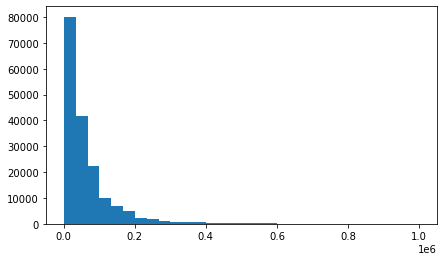

In [35]:
# Histogram for prices
plt.figure(figsize=(7,4))
plt.hist(y_train, bins=30, range=(0, 1000000))
plt.show()

##### Price dependence on the car brand

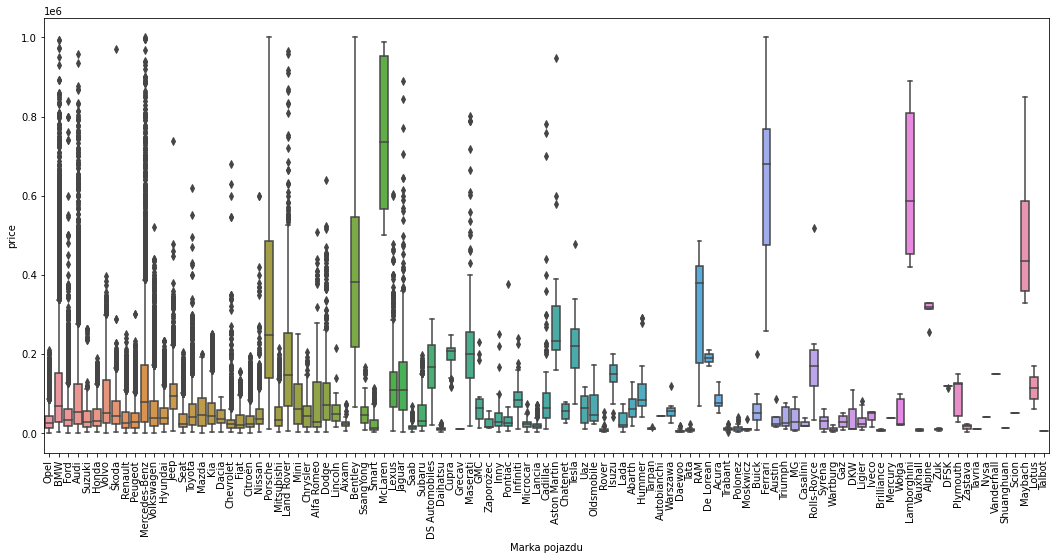

In [36]:
plt.figure(figsize=(18,8))
ax = sns.boxplot(x=X_train["Marka pojazdu"], y=y_train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

## Outliers
The preparation of the training data for model learning by removing or correcting outliers.<br>
Notice: this part will not be executed on the test data set and during the prediction.

#### Year of production

In [37]:
ind = X_train.loc[X_train["Rok produkcji"] < 1920].index
X_train.loc[ind, ["href", "Marka pojazdu", "Model pojazdu", "Generacja", "Rok produkcji"]]

,href,Marka pojazdu,Model pojazdu,Generacja,Rok produkcji
58251,https://www.otomoto.pl/oferta/ford-focus-ford-focus-mk-lift-ii-1-8-tdci-ID6DzBxg.html,Ford,Focus,Mk2 (2004-2011),1908.0000


In [38]:
# Correct the data 
ind = 58251
if ind in X_train.index:
    X_train.loc[ind, "Rok produkcji"] = 2008    # based on generation

C:\Users\malgo\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


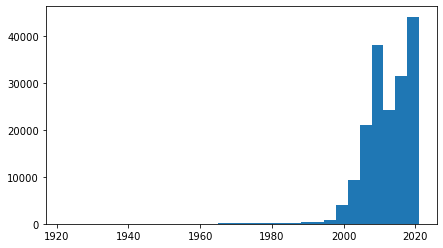

In [39]:
# Histogram for production year
plt.figure(figsize=(7,4))
plt.hist(X_train["Rok produkcji"], bins=30)
plt.show()

#### Mileage

Check offers with outlier mileage:

In [40]:
# Outliers
ind = X_train.loc[X_train["Przebieg"] > 2500000].index
X_train.loc[ind, ["href", "seller_name", "Marka pojazdu", "Rok produkcji", "Przebieg"]]

,href,seller_name,Marka pojazdu,Rok produkcji,Przebieg
34451,https://www.otomoto.pl/oferta/citroen-citroen-hy-foodtruck-lodziarnia-reklama-twojej-firmy-ID6Ddefj.html,hy,Citroën,1978.0000,11111111.0000
113016,https://www.otomoto.pl/oferta/opel-kadett-piekny-zabytkowy-model-ID6D9eld.html,P.P.U.H Andrzej Rybarczyk,Opel,1937.0000,1111111111.0000
30879,https://www.otomoto.pl/oferta/bmw-m3-m3-e46-gotowa-odswiezona-buda-wyscigi-wyscigowka-klatka-laminaty-ID6DABJn.html,Paweł,BMW,2003.0000,11111111.0000
124883,https://www.otomoto.pl/oferta/peugeot-607-okazja-peugeot-607-2-0-b-pelna-wersja-zadbany-ID6DAKvg.html,gosia,Peugeot,2001.0000,3075000.0000
80940,https://www.otomoto.pl/oferta/land-rover-range-rover-sport-2-7-silnik-nominal-na-gwarancji-stan-bardzo-dobry-faktura-vat-ID6Dnrn8.html,Jan,Land Rover,2007.0000,3500000.0000
32520,https://www.otomoto.pl/oferta/chevrolet-camaro-ID6DzDIb.html,Anna,Chevrolet,2012.0000,12345678.0000
34937,https://www.otomoto.pl/oferta/citroen-jumpy-combi-9-osobowy-z-niemiec-ID6DyVz4.html,Tomasz,Citroën,2006.0000,99999999999.0000
74840,https://www.otomoto.pl/oferta/jeep-willys-cj3b-cj-5-4x4-ID6DzBdb.html,P.P.H.U.,Jeep,1957.0000,100000000.0000
178922,https://www.otomoto.pl/oferta/volkswagen-caravelle-zarezerwowane-zarezerwowane-zarezerwowane-ID6DznE8.html,Caravelle 2 x drzwi boczne,Volkswagen,2006.0000,3999999.0000
124774,https://www.otomoto.pl/oferta/peugeot-308-ID6DAJnH.html,Europejskie Centrum Remarketingu Sp. z o.o.,Peugeot,2017.0000,3392021.0000


In [41]:
# Remove
X_train = X_train.drop(index=ind).copy()
y_train = y_train.drop(index=ind).copy()

##### Mileage dependence on the year of production

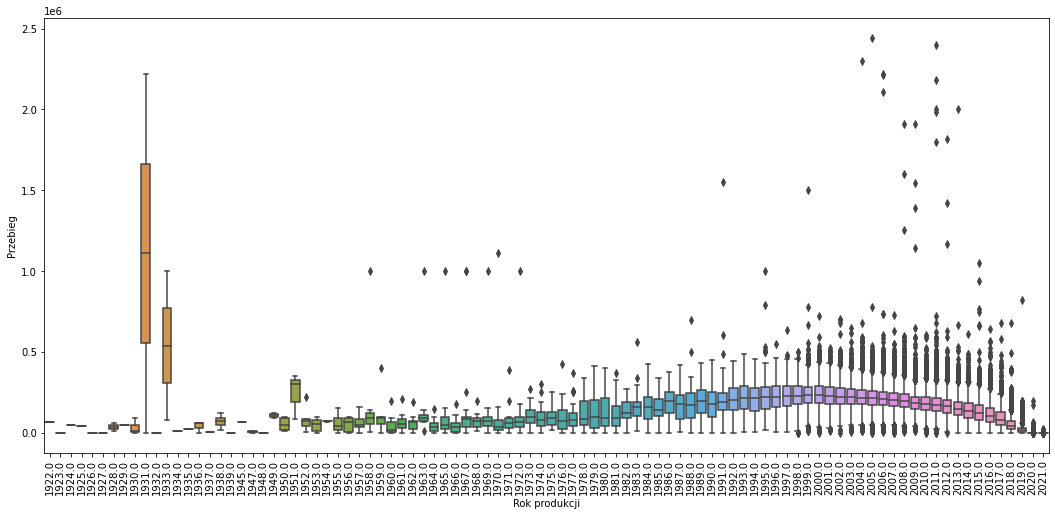

In [42]:
plt.figure(figsize=(18,8))
ax = sns.boxplot(x=X_train["Rok produkcji"], y=X_train["Przebieg"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

#### Car engine capacity

In [43]:
X_train.join(y_train).loc[X_train["Pojemność skokowa"] > 7000, \
                         ["href", "Pojemność skokowa", "Moc", "Marka pojazdu", "Rok produkcji", "price"]]

,href,Pojemność skokowa,Moc,Marka pojazdu,Rok produkcji,price
31399,https://www.otomoto.pl/oferta/cadillac-deville-cadillac-deville-oferta-prywatna-ID6D8GgA.html,8190.0000,193.0000,Cadillac,1974.0000,77000.0000
31376,https://www.otomoto.pl/oferta/cadillac-deville-cadillac-deville-iv-7-7l-v8-dokumenty-palacy-jezdny-ID6DbRHb.html,7700.0000,200.0000,Cadillac,1973.0000,37900.0000
31329,https://www.otomoto.pl/oferta/buick-centurion-1972-buick-centuriun-lesabres-bigblock-v8-ID6DyuSx.html,7456.0000,250.0000,Buick,1972.0000,43000.0000
32285,https://www.otomoto.pl/oferta/chevrolet-camaro-pro-street-68-ID6CUuc9.html,8400.0000,500.0000,Chevrolet,1968.0000,139000.0000
42847,https://www.otomoto.pl/oferta/dodge-charger-dodge-charger-440-magnum-ID6DsDd9.html,7200.0000,400.0000,Dodge,1970.0000,189000.0000
31831,https://www.otomoto.pl/oferta/chevrolet-suburban-7-4-benzyna-v8-klima-ID6DwtXJ.html,7400.0000,255.0000,Chevrolet,1988.0000,39000.0000
55365,https://www.otomoto.pl/oferta/ford-mustang-428-mach-1-ID6BMUdi.html,7031.0000,331.0000,Ford,1969.0000,169999.0000
31589,https://www.otomoto.pl/oferta/chevrolet-suburban-chevrolet-suburban-krystal-limuzyna-9-metrow-ID6DzgsA.html,8000.0000,340.0000,Chevrolet,2001.0000,37000.0000
31377,https://www.otomoto.pl/oferta/cadillac-eldorado-eldorado-100-oryginal-nie-naprawiany-org-lakier-ID6DwvYr.html,8200.0000,234.0000,Cadillac,1972.0000,32999.0000
82786,https://www.otomoto.pl/oferta/lincoln-mark-lincoln-mark-iii-1969-ID6DAMme.html,7596.0000,340.0000,Lincoln,1969.0000,35500.0000


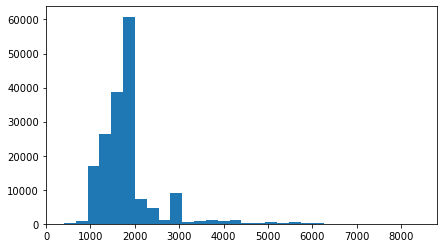

In [44]:
# Engine capacity
plt.figure(figsize=(7,4))
plt.hist(X_train["Pojemność skokowa"], bins=30)
plt.show()

#### Car engine power

In [45]:
X_train.join(y_train).loc[X_train["Moc"] > 750, \
                         ["href", "Pojemność skokowa", "Moc", "Marka pojazdu", "Rok produkcji", "price"]]

,href,Pojemność skokowa,Moc,Marka pojazdu,Rok produkcji,price
42632,https://www.otomoto.pl/oferta/dodge-charger-dodge-charger-hellcat-zamiana-ID6Dr8To.html,6166.0000,850.0000,Dodge,2015.0000,259000.0000
8414,https://www.otomoto.pl/oferta/audi-rs6-avant-900hp-333km-h-5-0-v10-carbon-83tys-km-bezwypadkowa-ID6DyhjZ.html,4999.0000,900.0000,Audi,2010.0000,149900.0000
108847,https://www.otomoto.pl/oferta/opel-meriva-011r-136000km-1-4-benz-import-niemcy-faktura-ID6DrhF2.html,1398.0000,1000.0000,Opel,2011.0000,20999.0000
54272,https://www.otomoto.pl/oferta/ford-mustang-shelby-gt500-performance-blue-dealer-shelby-polska-ID6DxRLZ.html,5163.0000,760.0000,Ford,2020.0000,739900.0000
54909,https://www.otomoto.pl/oferta/ford-f150-shelby-f150-super-snake-oficjalny-dealer-shelby-polska-ID6DB6fl.html,5000.0000,770.0000,Ford,2020.0000,799999.0000
52953,https://www.otomoto.pl/oferta/ford-mustang-shelby-gt500-carbon-fibre-track-oficjalny-dealer-shelby-polska-ID6DyiZs.html,5163.0000,760.0000,Ford,2020.0000,759900.0000
42969,https://www.otomoto.pl/oferta/dodge-challenger-hellcat-2020-6-2l-porysowany-lakier-ID6DAgeu.html,6200.0000,797.0000,Dodge,2020.0000,295000.0000
115844,https://www.otomoto.pl/oferta/opel-astra-1-7-d-ID6DAJxg.html,1686.0000,1100.0000,Opel,2012.0000,20900.0000
49990,https://www.otomoto.pl/oferta/ford-fiesta-ID6DBxPx.html,1450.0000,1499.0000,Ford,2014.0000,19900.0000
130330,https://www.otomoto.pl/oferta/porsche-taycan-porsche-tycan-turbo-s-gwarancja-salon-polska-i-wlasciciel-fv-23-ID6DwaYC.html,NaN,761.0000,Porsche,2020.0000,799900.0000


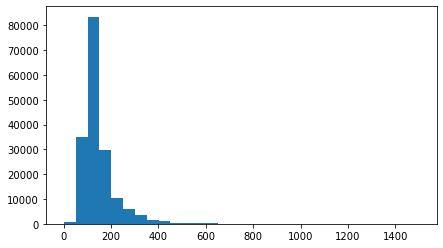

In [46]:
# Engine power
plt.figure(figsize=(7,4))
plt.hist(X_train["Moc"], bins=30)
plt.show()

Some high values of engine power are result of errors in data. These errors will be corrected at the data transformation stage.

In [47]:
# Correct the value for Peugeot Partner 
# (this value can't be corrected like others, because there are only two cars like that in the data)
ind = 123161
if ind in X_train.index:
    X_train.loc[ind, "Moc"] = 100  # instead of 1499

#### CO2 emission

In [48]:
ind = X_train.loc[X_train["Emisja CO2"] > 1000].index
X_train.loc[ind, ["href", "Emisja CO2", "Pojemność skokowa", "Moc", "Marka pojazdu", "Rok produkcji"]]

,href,Emisja CO2,Pojemność skokowa,Moc,Marka pojazdu,Rok produkcji
152792,https://www.otomoto.pl/oferta/skoda-octavia-iv-combi-style-1-5-tsi-ID6DBqs9.html,123134.0000,1498.0000,150.0000,Škoda,2021.0000
44076,https://www.otomoto.pl/oferta/fiat-126-fiat-126-elx-po-remoncie-ID6DztNI.html,1234.0000,652.0000,24.0000,Fiat,1998.0000
38106,https://www.otomoto.pl/oferta/citroen-berlingo-berlingo-1-6-hdi-100km-automat-bezwypadkowy-2-sztuki-ID6DgzVE.html,12345.0000,1560.0000,102.0000,Citroën,2017.0000
151644,https://www.otomoto.pl/oferta/skoda-octavia-iv-combi-style-1-5-tsi-ID6DBqtD.html,123134.0000,1498.0000,150.0000,Škoda,2021.0000
152810,https://www.otomoto.pl/oferta/skoda-octavia-iv-combi-style-1-5-tsi-ID6DBqk7.html,123134.0000,1498.0000,150.0000,Škoda,2021.0000
10661,https://www.otomoto.pl/oferta/audi-a3-audi-a3-1-9-tdi-2007r-3d-boleslawiec-dolny-slask-ID6DAg52.html,1900.0000,1896.0000,105.0000,Audi,2006.0000
147879,https://www.otomoto.pl/oferta/skoda-octavia-iv-combi-style-1-5-tsi-ID6DBg6H.html,123153.0000,1498.0000,150.0000,Škoda,2020.0000


In [49]:
# This column contains multiple NaN values; further proceedings to be decided
X_train.loc[ind, "Emisja CO2"] = np.NaN

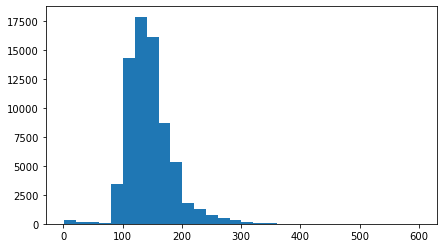

In [50]:
# CO2 emission
plt.figure(figsize=(7,4))
plt.hist(X_train["Emisja CO2"], bins=30)
plt.show()

#### Number of doors

In [51]:
# Number of doors
ind = X_train.loc[X_train["Liczba drzwi"] > 10].index
X_train.loc[ind, ["href", "Liczba drzwi", "Liczba miejsc", "Marka pojazdu"]]

,href,Liczba drzwi,Liczba miejsc,Marka pojazdu
129275,https://www.otomoto.pl/oferta/peugeot-2008-benz-automat-gwarancja-oplacony-ID6DB4WW.html,50.0000,5.0000,Peugeot
9585,https://www.otomoto.pl/oferta/audi-a3-1-5-tfsi-150-km-s-tronic-2-strefy-alarm-salon-pl-audi-centrum-wroclaw-ID6Dy6Dx.html,53.0000,5.0000,Audi
186863,https://www.otomoto.pl/oferta/volvo-s90-dealer-volvo-karlik-poznan-malta-ID6DgqEl.html,55.0000,5.0000,Volvo


In [52]:
# Correct the above outliers
X_train.loc[ind, "Liczba drzwi"] = X_train["Liczba drzwi"].median()

In [53]:
X_train["Liczba drzwi"].value_counts(dropna=False) 

5.0000     135973
4.0000      22256
3.0000       9397
2.0000       4638
NaN          2574
6.0000         69
7.0000          3
8.0000          2
9.0000          1
10.0000         1
1.0000          1
Name: Liczba drzwi, dtype: int64

##### Price dependense on the number of doors

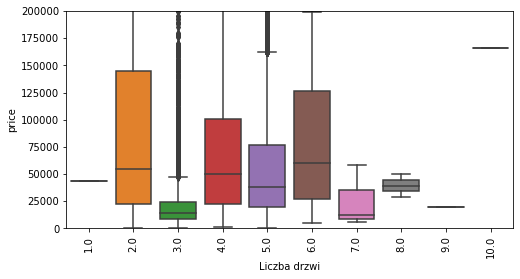

In [54]:
# Number of doors
plt.figure(figsize=(8,4))
ax = sns.boxplot(x=X_train["Liczba drzwi"], y=y_train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylim(ymin=0, ymax=200000)
plt.show()

#### Number of seats

In [55]:
X_train["Liczba miejsc"].value_counts(dropna=False) 

5.0000    143426
NaN        11159
4.0000      8470
7.0000      7251
2.0000      1649
9.0000      1136
8.0000       692
6.0000       603
3.0000       518
1.0000        11
Name: Liczba miejsc, dtype: int64

##### Price dependense on the number of seats

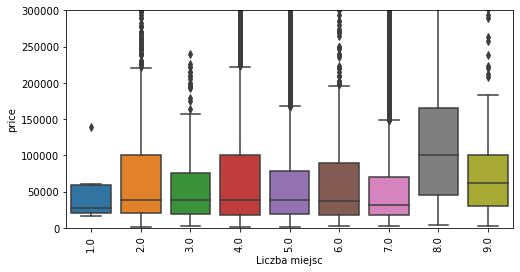

In [56]:
# Number of seats
plt.figure(figsize=(8,4))
ax = sns.boxplot(x=X_train["Liczba miejsc"], y=y_train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylim(ymin=0, ymax=300000)
plt.show()

### Summary after removing outliers

In [57]:
X_train.describe()

,Rok produkcji,Przebieg,Pojemność skokowa,Moc,Liczba drzwi,Liczba miejsc,Emisja CO2
count,174915.0000,173839.0000,173075.0000,173759.0000,172341.0000,163756.0000,71467.0000
mean,2012.4143,132272.7225,1859.3298,150.9040,4.6816,5.0441,146.0020
std,6.5018,97698.8109,698.1699,75.6313,0.6993,0.6957,38.9562
min,1922.0000,1.0000,400.0000,1.0000,1.0000,1.0000,1.0000
25%,2008.0000,44031.5000,1461.0000,105.0000,5.0000,5.0000,120.0000
50%,2013.0000,138650.0000,1796.0000,136.0000,5.0000,5.0000,140.0000
75%,2018.0000,199000.0000,1997.0000,170.0000,5.0000,5.0000,163.0000
max,2021.0000,2444444.0000,8400.0000,1499.0000,10.0000,9.0000,600.0000


#### [Save data]

In [58]:
# Dump X_train to pickle
with open("/".join([path, "X_train.obj"]), "wb") as fp:
    pickle.dump(X_train, fp)
    
# Dump y_train to pickle
with open("/".join([path, "y_train.obj"]), "wb") as fp:
    pickle.dump(y_train, fp)

In [59]:
# Read X_train from pickle 
with open("/".join([path, "X_train.obj"]), 'rb') as fp:
    X_train = pickle.load(fp)
    
# Read y_train from pickle 
with open("/".join([path, "y_train.obj"]), 'rb') as fp:
    y_train = pickle.load(fp)

## Data transformation
Data transformation before machine learning.

### Auxiliary functions and classes

In [60]:
class CustomError(Exception):
    pass

In [61]:
# Count threshold as n * median (to use in agg(...) method)
def threshold(n, label=None):
    def threshold_(x):
        return np.NaN if x.isna().all() else np.nanmedian(x, axis=0) * n
    threshold_.__name__ = (label if label is not None else 'threshold_%s' % n)
    return threshold_

# Get value from DataFrame with multi-index (but simple-index is also supported)
def multi_index_value(df, ind, val):
    """
    Parameters: 
    df = DataFrame
    ind = multi-index or simple-index (for multi-index: for example a row from X[["col1, col2, col3"]])
    val = column or multi-column (fot multi-column: for example "('col', 'median')")
    """
    if isinstance(df.index, pd.MultiIndex):
        return df.loc[tuple([item for item in ind]), val] if tuple([item for item in ind]) in df.index else None
    else:
        return df.loc[ind, val] if ind in df.index else None

In [62]:
class HierarchicalColumnsUnifier(BaseEstimator, TransformerMixin):
    """
    Transformer unifies hierarchical fields in a way that allows them to be grouped effectively.
    Parent columns: columns in hierarchical order.
    Child columns: columns subordinate to the parents, but without any established hierarchy among themselves.
    """
    
    def __init__(self, parent_columns, child_columns = [], unknown_value = "other"): 
        self.parent_columns = parent_columns
        self.child_columns = child_columns
        self.unknown_value = unknown_value
    
    
    def fit(self, X, y=None):       
        return self

    
    def transform(self, X, y=None):
        
        # Change to small letters and fill NaNs        
        for c in self.parent_columns + self.child_columns:
            X.loc[:,c] = X[c].fillna(self.unknown_value).apply(lambda x: x.lower())
        
        # For example, if car brand is unknown, set also car model = unknown
        parent = self.parent_columns[0]
        for c in self.parent_columns[1:]:
            X.loc[X[parent] == self.unknown_value, c] = self.unknown_value
            parent = c
        
        # For example, if car model is unknown, set also version and generation = unknown
        for c in self.child_columns:
            X.loc[X[parent] == self.unknown_value, c] = self.unknown_value
        
        return X

### Preprocessing

In [63]:
class OtoMotoPreprocessor(BaseEstimator, TransformerMixin):
    """
    Preprocessor dedicated for OtoMoto data:
    - standardizes binary fields,
    - all fields related to warranty reduces to one field,
    - divides the field "price_details" into its components,
    - creates new column "gas", 
    - marges similar categories in the field "Rodzaj paliwa" and writes new categories to "fuel",
    - marges similar categories in the field "Napęd",
    - rescales engine capacity and sets capacity = 0 for electric cars, 
    - calls HierarchicalColumnsUnifier for brands, models, generations and versions,
    - fills NaNs (except number fields).
    """
    
    # Type of fuel: according to this dictionary similar categories will be marged
    fuel_dict_ = {    
                      "Benzyna":     "Benzyna",    
                      "Benzyna+LPG": "Benzyna",
                      "Benzyna+CNG": "Benzyna",
                      "Diesel":      "Diesel",
                      "Hybryda":     "Hybryda",
                      "Elektryczny": "Elektryczny"
                   }
    
    # Type of drive: according to this dictionary similar categories will be marged
    drive_dict_ = {
                      "Na przednie koła":              "Na przednie koła",
                      "4x4 (stały)":                   "4x4 (stały)",
                      "Na tylne koła":                 "Na tylne koła",
                      "4x4 (dołączany automatycznie)": "4x4 (dołączany automatycznie)",
                      "4x4 (dołączany ręcznie)":       "Na tylne koła"
                   }

    # Binary columns
    bin_columns_ = [ 'Faktura VAT', 'Zarejestrowany w Polsce', 'Pierwszy właściciel', 'Bezwypadkowy', 'Serwisowany w ASO', \
                     'Metalik', 'ABS', 'Bluetooth', 'Czujnik zmierzchu', 'Elektrycznie ustawiane lusterka', 'Gniazdo USB', \
                     'Klimatyzacja automatyczna', 'MP3', 'Poduszka powietrzna chroniąca kolana', 'Poduszki boczne przednie', \
                     'Radio niefabryczne', 'Światła do jazdy dziennej', 'Szyberdach', 'Alufelgi', 'Centralny zamek', \
                     'Czujniki parkowania tylne', 'ESP (stabilizacja toru jazdy)', 'Immobilizer', 'Komputer pokładowy', \
                     'Ogranicznik prędkości', 'Poduszka powietrzna kierowcy', 'Poduszki boczne tylne', 'Radio fabryczne', \
                     'Światła LED', 'Wielofunkcyjna kierownica', 'ASR (kontrola trakcji)', 'Czujnik deszczu', \
                     'Elektryczne szyby przednie', 'Gniazdo AUX', 'Isofix', 'Kurtyny powietrzne', 'Podgrzewane lusterka boczne', \
                     'Poduszka powietrzna pasażera', 'Przyciemniane szyby', 'Światła Xenonowe', 'Światła przeciwmgielne', \
                     'Wspomaganie kierownicy', 'Perłowy', 'Tuning', 'Alarm', 'CD', 'Tapicerka welurowa', 'Gniazdo SD', 'Tempomat', \
                     'Dach panoramiczny', 'Podgrzewana przednia szyba', 'Klimatyzacja manualna', 'System Start-Stop', \
                     'Akryl (niemetalizowany)', 'VAT marża', 'Asystent parkowania', 'Klimatyzacja dwustrefowa', \
                     'Regulowane zawieszenie', 'Nawigacja GPS', 'Tapicerka skórzana', 'Elektrochromatyczne lusterko wsteczne', \
                     'Czujniki parkowania przednie', 'Kamera cofania', 'Odtwarzacz DVD', 'Podgrzewane przednie siedzenia', \
                     'Elektrochromatyczne lusterka boczne', 'Tuner TV', 'Łopatki zmiany biegów', 'Elektryczne szyby tylne', \
                     'Elektrycznie ustawiane fotele', 'Klimatyzacja czterostrefowa', 'Asystent pasa ruchu', 'Czujnik martwego pola', \
                     'Zmieniarka CD', 'Relingi dachowe', 'Hak', 'Tempomat aktywny', 'Podgrzewane tylne siedzenia', \
                     'Kierownica po prawej (Anglik)', 'Ogrzewanie postojowe', 'Filtr cząstek stałych', 'HUD (wyświetlacz przezierny)', \
                     'first_reg_flg', 'gas', 'Możliwość odliczenia VAT', 'Do negocjacji', 'warranty', 'Uszkodzony', \
                     'Warranty if agreed with the buyer', 'Zarejestrowany jako zabytek', 'Kierownica po prawej (Anglik)', \
                     'Matowy', 'Homologacja ciężarowa']   

    # Values appearing in column "price_details", separated by commas
    price_details_ = ["Możliwość odliczenia VAT", "Do negocjacji", "Faktura VAT"] 

    # Default values
    fuel_default_ = "Benzyna"
    drive_default_ = "Na przednie koła" 
    gearbox_default_ = "Manualna" 
    car_type_default_ = "Auta miejskie"
    seller_default_ = "Osoba prywatna"
    doors_default_ = 5 
    seats_default_ = 5

    
    def __init__(self, max_year=2021):    
        # Year for which the data is valid (notice: model requires periodic update)
        self.max_year_ = max_year     

        pass
        
            
    def fit(self, X, y=None):     
        # Values in the training set
        self.fuel_list_ = X["Rodzaj paliwa"].unique()
        self.drive_list_ = X["Napęd"].unique()
        self.car_type_list_ = X["Typ"].unique()
        self.seller_type_list_ = X["seller_type"].unique()

        # Prepare HierarchicalColumnsUnifier
        self.hierarchical_columns_unifier = HierarchicalColumnsUnifier(\
                                            parent_columns = ["Marka pojazdu", "Model pojazdu"], \
                                            child_columns = ["Generacja", "Wersja"], \
                                            unknown_value = "inny")
        self.hierarchical_columns_unifier.fit(X, y)
        
        return self

    
    def transform(self, X, y=None):
        # Change year of car production to age (new column)
        X.loc[:,"age"] = self.max_year_ - X.loc[:,"Rok produkcji"]

        # All new cars are accident-free
        X.loc[X["Stan"] == "Nowe", "Bezwypadkowy"] = "Tak"
                 
        # Correct atypical values
        X.loc[X["Matowy"] == "matt", "Matowy"] = "Tak"
        X.loc[X["Metalik"] == "metallic", "Metalik"] = "Tak"
        X.loc[X["Akryl (niemetalizowany)"] == "acrylic", "Akryl (niemetalizowany)"] = "Tak"
        X.loc[X["Kierownica po prawej (Anglik)"] == "true", "Kierownica po prawej (Anglik)"] = "Tak"    
                      
        # Change binary columns with values "Tak"/"Nie"/np.NaN to int: 1, 0         
        for c in self.bin_columns_:
            if c in X.columns:
                X.loc[:,c].fillna("0", inplace=True)
                X.loc[:,c].replace(to_replace="^(Tak|tak|true|1).*", value="1", regex=True, inplace=True)
                X.loc[:,c].replace(to_replace="^(?!Tak|tak|true|1).*", value="0", regex=True, inplace=True)
                X.loc[:,c] = X[c].astype("int8")
        
        # Change date of the first registration to first_reg_flg (new column):
        # first_reg_flg = 1, if the car was registered in a year later than the year of production.
        X.loc[X["Pierwsza rejestracja"].notna(), "first_reg_flg"] = X.loc[X["Pierwsza rejestracja"].notna()].\
                                                                    apply(self.__get_first_reg_flg, axis="columns")    
        X.loc[:,"first_reg_flg"].fillna(0, inplace=True)
        X.loc[:,"first_reg_flg"] = X["first_reg_flg"].astype("int8")

        # Check if there are new values in the set that did not occur in the training set
        new_val = [val for val in X["Rodzaj paliwa"].unique() if val not in self.fuel_list_]
        if len(new_val) > 0: X.loc[:,"Rodzaj paliwa"].replace(to_replace=new_val, value=self.fuel_default_, inplace=True) 
        new_val = [val for val in X["Napęd"].unique() if val not in self.drive_list_]
        if len(new_val) > 0: X.loc[:,"Napęd"].replace(to_replace=new_val, value=self.drive_default_, inplace=True)  
        new_val = [val for val in X["Typ"].unique() if val not in self.car_type_list_]
        if len(new_val) > 0: X.loc[:,"Typ"].replace(to_replace=new_val, value=self.car_type_default_, inplace=True)  
        new_val = [val for val in X["seller_type"].unique() if val not in self.seller_type_list_]
        if len(new_val) > 0: X.loc[:,"seller_type"].replace(to_replace=new_val, value=self.seller_default_, inplace=True)  
        
        # Gas installation (new column)
        X.loc[:,"gas"] = X.apply(lambda x: 0 if re.search("LPG|CNG", x["Rodzaj paliwa"]) is None else 1, axis="columns")
        X.loc[:,"gas"].fillna(0, inplace=True)
        X.loc[:,"gas"] = X["gas"].astype("int8")
        
        # Type of fuel: take category from dictionary and fill NaNs with default value
        X.loc[:,"fuel"] = X["Rodzaj paliwa"].apply(lambda x: self.fuel_dict_.get(x, self.fuel_default_))
        X.loc[:,"fuel"].fillna(self.fuel_default_, inplace=True)
                 
        # Type of drive: take category from dictionary and fill NaNs with default value
        X.loc[:,"Napęd"] = X["Napęd"].apply(lambda x: self.drive_dict_.get(x, self.drive_default_))
        X.loc[:,"Napęd"].fillna(self.drive_default_, inplace=True)  
                 
        # Gearbox: fill NaNs with default value, transform to binary, change type to int8,
        # prevent the appearance of additional values in new data
        X.loc[:,"Skrzynia biegów"].fillna(self.gearbox_default_, inplace=True)
        X.loc[:,"Skrzynia biegów"].replace(to_replace="^(Manualna).*", value="1", regex=True, inplace=True)
        X.loc[:,"Skrzynia biegów"].replace(to_replace="^(?!1).*", value="0", regex=True, inplace=True)
        X.loc[:,"Skrzynia biegów"] = X["Skrzynia biegów"].astype("int8")
        
        # Condition (new / used): transform to binary, change type to int8,
        # prevent the appearance of additional values in new data
        X.loc[:,"Stan"].replace(to_replace="^(Używane).*", value="1", regex=True, inplace=True)
        X.loc[:,"Stan"].replace(to_replace="^(?!1).*", value="0", regex=True, inplace=True)
        X.loc[:,"Stan"] = X["Stan"].astype("int8")
                
        # Engine capacity:
        # Scale and round to get rid of small differences in capacities
        X.loc[:,"Pojemność skokowa"] = round(X["Pojemność skokowa"] / 100.0, 0).astype(float)
        # Set 0 for electric cars
        X.loc[X["Rodzaj paliwa"] == "Elektryczny", "Pojemność skokowa"] = 0.0  
        
        # Number of doors: fill NaNs with median
        X.loc[:,"Liczba drzwi"].fillna(self.doors_default_, inplace=True)
        # Change from numeric to categorical
        X.loc[:,"doors"] = X["Liczba drzwi"].astype(str)
        X.loc[X["Liczba drzwi"] <= 2, "doors"] = "<=2" # only one car has a value = 1 (append the value 1 to 2)
        X.loc[X["Liczba drzwi"] >= 5, "doors"] = ">=5" # only a few dozen cars have a value > 5 (append them to moda)
        
        # Number of seats: fill NaNs with median
        X.loc[:,"Liczba miejsc"].fillna(self.seats_default_, inplace=True)
        # Change from numeric to categorical
        X.loc[:,"seats"] = X["Liczba miejsc"].astype(str)
        X.loc[X["Liczba miejsc"] < 8, "seats"] = "<8"  # values < 8 have similar average price
        X.loc[X["Liczba miejsc"] >=8, "seats"] = ">=8" # values >=8 have higher average prices
        
        # Warranty: combine three fields related to the guarantee into one.
        X.loc[:,"warranty"] = (X["Gwarancja dealerska (w cenie)"].notna() | \
                               X["Okres gwarancji producenta"].notna() | \
                               X["lub do (przebieg km)"].notna()).astype("int8")

        # Price details: split them to three separate columns:
        for c in self.price_details_:
            X.loc[:,c] = X["price_details"].apply(\
                   lambda x: int(c in re.split(", ", x if not pd.isnull(x) else ""))).astype("int8")
                
        # Unify hierarchical fields (brands, models, generations, versions) 
        X = self.hierarchical_columns_unifier.transform(X, y)             

        return X
    
    
    # Private method
    def __get_first_reg_flg(self, X):
        try:
            # Return 1, if the car was registered in a year later than the year of production
            return 1 if datetime.strptime(str(X["Pierwsza rejestracja"]), "%d/%m/%Y").year > X["Rok produkcji"] \
                   else 0
        except ValueError as ex:
            return np.NaN

In [64]:
otomoto_preprocessor = OtoMotoPreprocessor()
X_train = otomoto_preprocessor.fit_transform(X_train, y_train)

Data check:

In [65]:
X_train.loc[X_train["Pierwsza rejestracja"].notna(), \
           ["Rok produkcji", "age", "Pierwsza rejestracja", "first_reg_flg"]].head()

,Rok produkcji,age,Pierwsza rejestracja,first_reg_flg
107413,2010.0000,11.0000,31/03/2011,1
20387,2016.0000,5.0000,21/03/2016,0
50599,2009.0000,12.0000,06/03/2009,0
7750,2019.0000,2.0000,01/09/2019,0
157698,2009.0000,12.0000,03/02/2009,0


In [66]:
X_train["age"].isna().any()

False

In [67]:
X_train["first_reg_flg"].value_counts(dropna=False)

0    165609
1      9306
Name: first_reg_flg, dtype: int64

In [68]:
X_train["gas"].value_counts(dropna=False)

0    167832
1      7083
Name: gas, dtype: int64

In [69]:
X_train["fuel"].value_counts(dropna=False)

Benzyna        94067
Diesel         75179
Hybryda         4757
Elektryczny      912
Name: fuel, dtype: int64

In [70]:
X_train[["Rodzaj paliwa", "fuel", "gas"]].head(975).tail(5)

,Rodzaj paliwa,fuel,gas
46794,Benzyna+LPG,Benzyna,1
40279,Benzyna,Benzyna,0
66333,Benzyna,Benzyna,0
164960,Hybryda,Hybryda,0
122074,Diesel,Diesel,0


In [71]:
# Engine capacity for electric car should be equal 0
X_train.loc[X_train["fuel"] == "Elektryczny", ["Pojemność skokowa"]].value_counts()

Pojemność skokowa
0.0000               912
dtype: int64

In [72]:
X_train["Napęd"].value_counts(dropna=False)

Na przednie koła                 131427
Na tylne koła                     15946
4x4 (stały)                       14003
4x4 (dołączany automatycznie)     13539
Name: Napęd, dtype: int64

In [73]:
X_train["doors"].value_counts(dropna=False) 

>=5    138623
4.0     22256
3.0      9397
<=2      4639
Name: doors, dtype: int64

In [74]:
X_train["seats"].value_counts(dropna=False) 

<8     173087
>=8      1828
Name: seats, dtype: int64

In [75]:
X_train["Skrzynia biegów"].value_counts(dropna=False) 

1    113939
0     60976
Name: Skrzynia biegów, dtype: int64

In [76]:
X_train["Stan"].value_counts(dropna=False) 

1    151781
0     23134
Name: Stan, dtype: int64

In [77]:
X_train[["price_details"] + otomoto_preprocessor.price_details_ + ["VAT marża", "seller_type", "Stan"]].head(9000).tail(5)

,price_details,Możliwość odliczenia VAT,Do negocjacji,Faktura VAT,VAT marża,seller_type,Stan
161377,Faktura VAT,0,0,1,0,Autoryzowany Dealer,1
75209,NaN,0,0,0,1,Dealer,1
114494,NaN,0,0,0,0,Osoba prywatna,1
6257,NaN,0,0,0,0,Dealer,1
140088,Faktura VAT,0,0,1,0,Autoryzowany Dealer,1


In [78]:
X_train[otomoto_preprocessor.price_details_ + ["VAT marża"]].sum()

Możliwość odliczenia VAT     7884
Do negocjacji               88793
Faktura VAT                 56309
VAT marża                   54739
dtype: int64

In [79]:
X_train["warranty"].value_counts(dropna=False)

0    162686
1     12229
Name: warranty, dtype: int64

In [80]:
X_train[otomoto_preprocessor.bin_columns_].head(4444).tail(5)

,Faktura VAT,Zarejestrowany w Polsce,Pierwszy właściciel,Bezwypadkowy,Serwisowany w ASO,Metalik,ABS,Bluetooth,Czujnik zmierzchu,Elektrycznie ustawiane lusterka,Gniazdo USB,Klimatyzacja automatyczna,MP3,Poduszka powietrzna chroniąca kolana,Poduszki boczne przednie,Radio niefabryczne,Światła do jazdy dziennej,Szyberdach,Alufelgi,Centralny zamek,Czujniki parkowania tylne,ESP (stabilizacja toru jazdy),Immobilizer,Komputer pokładowy,Ogranicznik prędkości,Poduszka powietrzna kierowcy,Poduszki boczne tylne,Radio fabryczne,Światła LED,Wielofunkcyjna kierownica,ASR (kontrola trakcji),Czujnik deszczu,Elektryczne szyby przednie,Gniazdo AUX,Isofix,Kurtyny powietrzne,Podgrzewane lusterka boczne,Poduszka powietrzna pasażera,Przyciemniane szyby,Światła Xenonowe,Światła przeciwmgielne,Wspomaganie kierownicy,Perłowy,Tuning,Alarm,CD,Tapicerka welurowa,Gniazdo SD,Tempomat,Dach panoramiczny,Podgrzewana przednia szyba,Klimatyzacja manualna,System Start-Stop,Akryl (niemetalizowany),VAT marża,Asystent parkowania,Klimatyzacja dwustrefowa,Regulowane zawieszenie,Nawigacja GPS,Tapicerka skórzana,Elektrochromatyczne lusterko wsteczne,Czujniki parkowania przednie,Kamera cofania,Odtwarzacz DVD,Podgrzewane przednie siedzenia,Elektrochromatyczne lusterka boczne,Tuner TV,Łopatki zmiany biegów,Elektryczne szyby tylne,Elektrycznie ustawiane fotele,Klimatyzacja czterostrefowa,Asystent pasa ruchu,Czujnik martwego pola,Zmieniarka CD,Relingi dachowe,Hak,Tempomat aktywny,Podgrzewane tylne siedzenia,Kierownica po prawej (Anglik),Ogrzewanie postojowe,Filtr cząstek stałych,HUD (wyświetlacz przezierny),first_reg_flg,gas,Możliwość odliczenia VAT,Do negocjacji,warranty,Uszkodzony,Warranty if agreed with the buyer,Zarejestrowany jako zabytek,Kierownica po prawej (Anglik),Matowy,Homologacja ciężarowa
100844,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
57681,0,1,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
104423,0,0,1,1,1,0,1,1,1,1,1,1,0,0,1,0,0,0,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19923,0,0,0,1,1,0,1,1,1,1,1,1,1,0,1,0,1,0,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
168311,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [81]:
with pd.option_context("display.max_rows", X_train.shape[1]):
    print(X_train[otomoto_preprocessor.bin_columns_].sum().sort_values(ascending=True))
    
# Columns to be removed due to low data volume:
# Uszkodzony                                    
# Warranty if agreed with the buyer            
# Zarejestrowany jako zabytek                 
# Kierownica po prawej (Anglik)               
# Matowy                                      
# Homologacja ciężarowa     
# Tuning                  

Uszkodzony                                    0
Warranty if agreed with the buyer            22
Zarejestrowany jako zabytek                 188
Kierownica po prawej (Anglik)               382
Kierownica po prawej (Anglik)               382
Matowy                                      663
Homologacja ciężarowa                       798
Tuning                                     1004
Tuner TV                                   2628
Ogrzewanie postojowe                       5838
Radio niefabryczne                         6636
gas                                        7083
HUD (wyświetlacz przezierny)               7312
Możliwość odliczenia VAT                   7884
Klimatyzacja czterostrefowa                8078
Akryl (niemetalizowany)                    8530
Regulowane zawieszenie                     8674
Podgrzewane tylne siedzenia                8741
first_reg_flg                              9306
warranty                                  12229
Filtr cząstek stałych                   

In [82]:
X_train["Marka pojazdu"].isna().any(), \
X_train["Model pojazdu"].isna().any(), \
X_train["Generacja"].isna().any(), \
X_train["Wersja"].isna().any()

(False, False, False, False)

In [83]:
# Brands, models, generations and versions after HierarchicalColumnsUnifier transformation
X_train.loc[X_train["Model pojazdu"] != "inny", ["Marka pojazdu", "Model pojazdu", "Generacja", "Wersja"]].head(3).append(\
X_train.loc[X_train["Model pojazdu"] == "inny", ["Marka pojazdu", "Model pojazdu", "Generacja", "Wersja"]].head(2))

,Marka pojazdu,Model pojazdu,Generacja,Wersja
107413,opel,astra,j (2009-2015),iv 1.7 cdti enjoy
20387,bmw,seria 7,g11/12 (2015-),750li xdrive
50599,ford,focus,inny,1.6 sport
62588,grecav,inny,inny,inny
25053,bmw,inny,inny,inny


Later, small categories (brands, models, generations and versions) will be combined with larger ones.

### Transformers

#### Engine capacity
Fill NaNs using a median for a given brand, model and fuel type.

In [84]:
class AggregateImputer(BaseEstimator, TransformerMixin):
    """
    Transformer counts the indicated aggregate for the column and uses it to fill NaNs. 
    If grouping_columns is given, aggregates for each group can be viewed in the statistics_ DataFrame. 
    If it is not posibble to count the aggregate for a group, alternative method can be used for filling NaNs 
    in statistics_.[aggragate], i.e. ‘backfill’, ‘bfill’, ‘pad’, ‘ffill’, as for the fillna method. 

    In the transform method, NaNs in X[column] are filled using the aggregate value counted for the group or, 
    if the appropriate group does not exist in statistics_, using the aggregate for whole Series.
    """
    
    def __init__(self, column, grouping_columns=None, aggregate="median", alternative=None):   
        self.column = column        
        self.grouping_columns = grouping_columns
        self.aggregate = aggregate    
        self.alternative = alternative
        
        
    def fit(self, X, y=None):              
        aggregates = ["count", "min", "max"]
        if self.aggregate not in aggregates:
            aggregates = aggregates + [self.aggregate]
        
        if isinstance(self.grouping_columns, list):
            columns = self.grouping_columns + [self.column]
            if len(self.grouping_columns) == 1:
                # self.grouping_columns should be a string, if it contains only 1 column  
                self.grouping_columns = self.grouping_columns[0]
        else:
            columns = [self.grouping_columns, self.column]

        # Calculate statistics for column
        if self.grouping_columns is not None:
            self.statistics_ = X[columns].groupby(self.grouping_columns).agg(aggregates)
            if self.alternative is not None:
                self.statistics_.fillna(method=self.alternative, inplace=True)
        
        # And count for all rows:
        self.agg_value_ = X[self.column].agg(self.aggregate)
        
        return self

    
    def transform(self, X, y=None):  
        if not X[self.column].isna().any():
            return X
        
        # Set aggregate of given group      
        if self.grouping_columns is not None:            
            X.loc[:,self.column].fillna(X.loc[X[self.column].isna()].apply(lambda x: \
                       multi_index_value(self.statistics_, x[self.grouping_columns], (self.column, self.aggregate)),\
                       axis="columns"), inplace=True)

        # And for remaining NaNs 
        X.loc[:,self.column].fillna(self.agg_value_, inplace=True)
        
        return X

In [85]:
capacity_imputer = AggregateImputer(column="Pojemność skokowa",\
                                    grouping_columns=["Marka pojazdu", "Model pojazdu", "fuel"],\
                                    aggregate="median")
X_train = capacity_imputer.fit_transform(X_train, y_train)

Data check:

In [86]:
capacity_imputer.statistics_.head(100).tail(5)

Pojemność skokowa                        
                                                count     min     max  median
Marka pojazdu Model pojazdu fuel                                             
audi          inny          Diesel                  1 30.0000 30.0000 30.0000
              q2            Benzyna                88 10.0000 20.0000 15.0000
                            Diesel                 14 16.0000 20.0000 18.0000
              q3            Benzyna               206 14.0000 25.0000 15.0000
                            Diesel                147 20.0000 20.0000 20.0000

In [87]:
X_train["Pojemność skokowa"].isna().any()

False

#### Engine power
Some records have invalid values in this field. The discrepancies are large, so we want to not only fill NaNs but also correct unbelievable values.

We operate on two subsets of data:
- subset1 - brand, model, generation and version are known,
- subset2 - brand and model are known, generation or version are unknown.

It can be expected that cars of the same make, model, generation, version, type of fuel and capacity have the same engine power or similar. If generation and version are unknown, engine power may differ but still discrepancy should not be significant.

Through thresholds, we define the tolerance for discrepancies. We set thresholds:
- lower_limit = n_lower * median,
- upper_limit = n_upper * median,

where parameters n_lower, n_upper will be selected experimentally.

Discrepancies will be reduced using the median calculated separately for each group.

In [88]:
class DiscrepanciesReducer(BaseEstimator, TransformerMixin):
    """
    Transformer reduces discrepancies.  
    Through thresholds, we define the tolerance for discrepancies, by setting: 
    lower_threshold = n_lower * aggregate (medium or mean),
    upper_threshold = n_upper * aggregate (medium or mean).
    Values below the lower_threshold or above the upper_threshold will be changed to the aggregate (median or mean)
    calculated for the given group.
    If fillna=True, the transformer also fills NaNs in the groups for which the aggregate was calculated.
    """
    
    def __init__(self, column, grouping_columns, n_lower=1.0, n_upper=1.0, aggregate="median", fillna=True):   
        self.column = column        
        self.grouping_columns = grouping_columns
        self.aggregate = aggregate 
        self.n_lower = n_lower
        self.n_upper = n_upper
        self.fillna = fillna
        
        
    def fit(self, X, y=None):              
        aggregates = ["count", "min", "max"]
        if self.aggregate not in aggregates:
            aggregates = aggregates + [self.aggregate]
            
        # Calculate statistics
        self.statistics_ = pd.DataFrame(X.loc[:,self.grouping_columns + [self.column]].\
                                        groupby(self.grouping_columns).agg(aggregates + \
                                        [threshold(self.n_lower, "lower_threshold"),  \
                                         threshold(self.n_upper, "upper_threshold")]).to_records())
        return self

    
    def transform(self, X, y=None):  
        # Merge copy of X with self.statistics_
        X_tmp = X[self.grouping_columns + [self.column]].copy()
        X_tmp["index"] = X_tmp.index
        X_tmp = X_tmp.merge(self.statistics_, on=self.grouping_columns, how="left")
        X_tmp.set_index("index", inplace=True)
        
        # Correct ouliers  
        X_tmp.loc[(X_tmp[self.column] > X_tmp[str((self.column, "upper_threshold"))]) | \
                  (X_tmp[self.column] < X_tmp[str((self.column, "lower_threshold"))]), self.column] = \
        X_tmp.loc[(X_tmp[self.column] > X_tmp[str((self.column, "upper_threshold"))]) | \
                  (X_tmp[self.column] < X_tmp[str((self.column, "lower_threshold"))]), str((self.column, self.aggregate))]
        
        # Fill NaNs 
        if self.fillna:
            X_tmp.loc[:,self.column].fillna(X_tmp[str((self.column, self.aggregate))], inplace=True)

        # Rewrite column from X_tmp to X
        X.loc[:,self.column] = X_tmp[self.column]
        
        return X

In [89]:
class EnginePowerDiscrReducer(DiscrepanciesReducer):
    """
    Transformer reduces discrepancies for engine power and fills NaNs. 
    The operation will be performed independently on two subsets: 
    - subset1 - brand, model, generation and version are known,
    - subset2 - brand and model are known, generation or version are unknown.
    Transformer inherits from BaseEstimator and TransformerMixin via DiscrepanciesReducer.
    """  
    
    __column = "Moc"
    __grouping_columns_dict = {
        "subset1": ["Marka pojazdu", "Model pojazdu", "Generacja", "Wersja", "fuel", "Pojemność skokowa"],
        "subset2": ["Marka pojazdu", "Model pojazdu", "fuel", "Pojemność skokowa"],
    }    
    
        
    def __init__(self, subset, n_lower, n_upper, aggregate="median"): 
        self.subset = subset
        self.columns = self.__grouping_columns_dict[subset] + [self.__column]
        DiscrepanciesReducer.__init__(self, column=self.__column, grouping_columns=self.__grouping_columns_dict[subset],\
                                      n_lower=n_lower, n_upper=n_upper, aggregate=aggregate, fillna=True)
                
        
    def fit(self, X, y=None):          
        DiscrepanciesReducer.fit(self, self.__get_subset(X))            
        return self

    
    def transform(self, X, y=None):        
        # Reduce discrepancies by DiscrepanciesReducer for a given subset
        X_subset = DiscrepanciesReducer.transform(self, self.__get_subset(X))
        # Rewrite subset to X
        X.loc[X_subset.index, self.__column] = X_subset[self.__column]
        return X
    
    
    # Private method returning subset1 or subset2
    def __get_subset(self, X):
        if self.subset == "subset1":
            return X.loc[(X["Generacja"] != "inny") & (X["Wersja"] != "inny"), self.columns].copy()
                       
        elif self.subset == "subset2":
            return X.loc[(X["Marka pojazdu"] != "inny") & (X["Model pojazdu"] != "inny") & \
                        ((X["Generacja"] == "inny") | (X["Wersja"] == "inny")), self.columns].copy()
        else:
            return None

In [90]:
n_lower = 0.5
n_upper = 2.5

# Subset 1: brand, model, generation and version are known
# Outliers and NaNs will be change to median
engine_power_discr_reducer1 = EnginePowerDiscrReducer(subset="subset1", n_lower=n_lower, n_upper=n_upper)
X_train = engine_power_discr_reducer1.fit_transform(X_train, y_train)

In [91]:
n_lower = 0.15
n_upper = 3

# Subset 2: brand and model are known, generation or version are unknown
# Outliers and NaNs will be change to median
engine_power_discr_reducer2 = EnginePowerDiscrReducer(subset="subset2", n_lower=n_lower, n_upper=n_upper)
X_train = engine_power_discr_reducer2.fit_transform(X_train, y_train)

In [92]:
# Remaining NaNs
aggregate_imputer = AggregateImputer(column="Moc", aggregate="median")
X_train = aggregate_imputer.fit_transform(X_train, y_train)

Data check:

In [93]:
# Statistics calculated for subset1:
statistics1 = engine_power_discr_reducer1.statistics_
statistics1.head()

,Marka pojazdu,Model pojazdu,Generacja,Wersja,fuel,Pojemność skokowa,"('Moc', 'count')","('Moc', 'min')","('Moc', 'max')","('Moc', 'median')","('Moc', 'lower_threshold')","('Moc', 'upper_threshold')"
0,alfa romeo,90,b2 (1984-1986),2.5 l v6 jetronic,Benzyna,25.0000,1,158.0000,158.0000,158.0000,79.0000,395.0000
1,audi,100,c3 (1982-1991),1.8 cc,Benzyna,18.0000,1,90.0000,90.0000,90.0000,45.0000,225.0000
2,audi,100,c3 (1982-1991),2.0,Benzyna,20.0000,1,116.0000,116.0000,116.0000,58.0000,290.0000
3,audi,100,c3 (1982-1991),2.0 e,Benzyna,20.0000,2,115.0000,115.0000,115.0000,57.5000,287.5000
4,audi,100,c4 (1991-1994),2.3 e,Benzyna,23.0000,1,133.0000,133.0000,133.0000,66.5000,332.5000


In [94]:
# Outliers for subset1 (for given parameters), which have been corrected:
outliers1 = statistics1[(statistics1["('Moc', 'max')"] > statistics1["('Moc', 'upper_threshold')"]) | \
                        (statistics1["('Moc', 'min')"] < statistics1["('Moc', 'lower_threshold')"])]
outliers1

,Marka pojazdu,Model pojazdu,Generacja,Wersja,fuel,Pojemność skokowa,"('Moc', 'count')","('Moc', 'min')","('Moc', 'max')","('Moc', 'median')","('Moc', 'lower_threshold')","('Moc', 'upper_threshold')"
10669,opel,meriva,ii (2010-),ii (2010-2017),Benzyna,14.0000,6,100.0000,1000.0000,120.0000,60.0000,300.0000
15058,volkswagen,golf,v (2003-2009),v (2003-2009),Benzyna,14.0000,4,80.0000,200.0000,185.0000,92.5000,462.5000


In [95]:
# Statistics calculated for subset2:
statistics2 = engine_power_discr_reducer2.statistics_
statistics2.head()

,Marka pojazdu,Model pojazdu,fuel,Pojemność skokowa,"('Moc', 'count')","('Moc', 'min')","('Moc', 'max')","('Moc', 'median')","('Moc', 'lower_threshold')","('Moc', 'upper_threshold')"
0,abarth,500,Benzyna,14.0000,8,140.0000,185.0000,162.5000,24.3750,487.5000
1,abarth,595,Benzyna,14.0000,17,145.0000,190.0000,160.0000,24.0000,480.0000
2,abarth,695,Benzyna,14.0000,3,165.0000,180.0000,180.0000,27.0000,540.0000
3,abarth,grande punto,Benzyna,14.0000,6,155.0000,185.0000,165.0000,24.7500,495.0000
4,acura,mdx,Benzyna,35.0000,2,300.0000,300.0000,300.0000,45.0000,900.0000


In [96]:
# Outliers for subset2 (for given parameters), which have been corrected:
outliers2 = statistics2[(statistics2["('Moc', 'max')"] > statistics2["('Moc', 'upper_threshold')"]) | \
                        (statistics2["('Moc', 'min')"] < statistics2["('Moc', 'lower_threshold')"])]
outliers2

,Marka pojazdu,Model pojazdu,fuel,Pojemność skokowa,"('Moc', 'count')","('Moc', 'min')","('Moc', 'max')","('Moc', 'median')","('Moc', 'lower_threshold')","('Moc', 'upper_threshold')"
15,aixam,city,Diesel,6.0000,3,5.0000,30.0000,6.0000,0.9000,18.0000
695,citroën,berlingo,Benzyna,16.0000,27,90.0000,1000.0000,110.0000,16.5000,330.0000
766,citroën,c4 picasso,Benzyna,20.0000,6,140.0000,1400.0000,140.0000,21.0000,420.0000
904,daewoo,lanos,Benzyna,15.0000,17,1.0000,100.0000,86.0000,12.9000,258.0000
919,daihatsu,materia,Benzyna,15.0000,6,101.0000,1000.0000,103.0000,15.4500,309.0000
1243,ford,fiesta,Diesel,14.0000,30,50.0000,1499.0000,68.0000,10.2000,204.0000
2328,mercedes-benz,klasa s,Benzyna,50.0000,28,2.0000,388.0000,293.0000,43.9500,879.0000
2414,mercedes-benz,w123,Benzyna,23.0000,11,1.0000,230.0000,109.0000,16.3500,327.0000
2713,opel,astra,Benzyna,14.0000,676,3.0000,150.0000,140.0000,21.0000,420.0000
2723,opel,astra,Diesel,17.0000,176,74.0000,1100.0000,110.0000,16.5000,330.0000


In [97]:
X_train["Moc"].isna().any()

False

In [98]:
X_train["Moc"].describe()

count   174915.0000
mean       150.8405
std         75.2836
min          1.0000
25%        105.0000
50%        136.0000
75%        170.0000
max        900.0000
Name: Moc, dtype: float64

#### Mileage
Fill NaNs using a median for a given age of car. If median does not exist for the age, take last known median (alternatively linear regression would be good too).

In [99]:
mileage_imputer = AggregateImputer(column="Przebieg", grouping_columns="age", aggregate="median", alternative="ffill")
X_train = mileage_imputer.fit_transform(X_train, y_train)

Data check:

In [100]:
# Statistics calculated for mileage:
mileage_imputer.statistics_.head()

Przebieg                              
          count    min         max     median
age                                          
0.0000     4028 1.0000  25485.0000     5.0000
1.0000    21657 1.0000 200000.0000     5.0000
2.0000     9121 1.0000 820586.0000 16697.0000
3.0000     8291 1.0000 677215.0000 44096.0000
4.0000    11973 1.0000 680000.0000 82000.0000

In [101]:
X_train["Przebieg"].isna().any()

False

#### [Save data]

In [102]:
# Dump X_train to pickle
with open("/".join([path, "X_train_1.obj"]), "wb") as fp:
    pickle.dump(X_train, fp)

In [103]:
# Read X_train from pickle 
with open("/".join([path, "X_train_1.obj"]), 'rb') as fp:
    X_train = pickle.load(fp)

#### Models of cars: join small classes with "inny"
Combine brands, models, generations and versions to obtain groups with a cardinality >= "min_size".

Notice: versions, generations and models with the same name, belonging to different parents, are not the same. 
Their names will be changed to ensure their uniqueness (except groups which are less than "min_size").

In [104]:
class HierarchicalColumnsCategorizer(BaseEstimator, TransformerMixin):
    """
    Transformer:
    - joins groups with cardinality less than "min_size" using label "unknown_value",
    - ensures the uniqueness of category names at different levels (different parents shouldn't have the same children,
    - except group with "unknown_value", which are less than "min_size")
    """
    
    def __init__(self, columns, min_size=100, unknown_value="other"): 
        self.columns = columns
        self.min_size = min_size
        self.unknown_value = unknown_value
    
    
    def fit(self, X, y=None): 
        X_tmp = X[self.columns].copy()        
        if X_tmp.isna().any().any():
            raise CustomError("Data set includes NaNs.")
            
        X_tmp["index"] = X_tmp.index 
        self.clear_flg = ["_".join([c, "clear"]) for c in self.columns]
        self.new_columns = ["_".join([c, "new"]) for c in self.columns]
        
        # If the group size < "min_size", change category's name to unknown_value
        for i in range(len(self.columns)): 
            counted = pd.DataFrame(X_tmp[self.columns[0:i+1] + ["index"]].\
                                   groupby(self.columns[0:i+1]).count() < self.min_size).\
                                   reset_index().rename(columns={"index": self.clear_flg[i]}) 
                                   # the column "index" isn't an index but boolean: count(index) < min_size     
            X_tmp = X_tmp.merge(counted, on=self.columns[0:i+1], how="left")       
            
            # Ensuring the uniqueness of names
            X_tmp[self.new_columns[i]] = X_tmp.apply(lambda x: \
                  ", ".join([self.unknown_value if x[self.clear_flg[j]] else x[self.columns[j]] for j in range(i+1)]), \
                  axis="columns")
        
        # For groups still smaller than min_size
        for c in self.new_columns[1:]: 
            values = X_tmp[c].value_counts()[(X_tmp[c].value_counts() < self.min_size)].index
            X_tmp.loc[X_tmp[c].isin(values), c] = self.unknown_value            
        
        self.pattern_ = X_tmp[self.columns + self.new_columns].drop_duplicates().copy()           
        return self

    
    def transform(self, X, y=None):
        X_tmp = X[self.columns].copy() 
            
        X_tmp["index"] = X_tmp.index         
        
        # Join data with pattern_ (column by column)
        for i in range(len(self.columns)):
            X_tmp = X_tmp.merge(self.pattern_[self.columns[0:i+1] + self.new_columns[i:i+1]].drop_duplicates(), \
                                              on=self.columns[0:i+1], how="left")   
                
            # If matching pattern_ doesn't exist, set "unknown_value"
            X_tmp.loc[:,self.new_columns[i]].fillna(self.unknown_value, inplace=True)  
            
        X_tmp.set_index("index", inplace=True)
        
        # Rewrite values from new_columns to columns
        for i in range(len(self.columns)):
            X.loc[:,self.columns[i]] = X_tmp[self.new_columns[i]]   
                
        return X.sort_index()

In [105]:
min_size = 300

hierarchical_columns_categorizer = HierarchicalColumnsCategorizer(
                                   columns=["Marka pojazdu", "Model pojazdu", "Generacja", "Wersja"], 
                                   min_size=min_size,
                                   unknown_value="inny")
X_train = hierarchical_columns_categorizer.fit_transform(X_train, y_train)

Data check: 

In [106]:
# Pattern generated by the fit method
hierarchical_columns_categorizer.pattern_.head()

,Marka pojazdu,Model pojazdu,Generacja,Wersja,Marka pojazdu_new,Model pojazdu_new,Generacja_new,Wersja_new
0,opel,astra,j (2009-2015),iv 1.7 cdti enjoy,opel,"opel, astra","opel, astra, j (2009-2015)","opel, astra, j (2009-2015), inny"
1,bmw,seria 7,g11/12 (2015-),750li xdrive,bmw,"bmw, seria 7","bmw, seria 7, inny","bmw, seria 7, inny, inny"
2,ford,focus,inny,1.6 sport,ford,"ford, focus",inny,inny
3,ford,galaxy,mk3 (2015-),2.0 tdci titanium,ford,"ford, galaxy","ford, galaxy, inny","ford, galaxy, inny, inny"
4,ford,s-max,i (2006-2015),2.0 tdci trend,ford,"ford, s-max","ford, s-max, i (2006-2015)","ford, s-max, i (2006-2015), inny"


In [107]:
X_train[["Marka pojazdu", "Model pojazdu", "Generacja", "Wersja", "href"]].head(10000).tail(5)

,Marka pojazdu,Model pojazdu,Generacja,Wersja,href
11037,audi,"audi, a8","audi, a8, inny","audi, a8, inny, inny",https://www.otomoto.pl/oferta/audi-a8-audi-a8-w12-quattro-6-3-fsi-mr14-4h-lang-tiptronic-w12-fv-vat-ID6Drjnl.html
11038,audi,"audi, q5","audi, q5, fy (2017-)","audi, q5, fy (2017-), inny",https://www.otomoto.pl/oferta/audi-q5-rocznik-2021-jasna-tapicerka-sportowe-fotele-led-ID6Dzhvd.html
11039,audi,"audi, a6","audi, a6, c6 (2004-2011)","audi, a6, c6 (2004-2011), inny",https://www.otomoto.pl/oferta/audi-a6-bezwypadkowy-serwis-aso-dostawa-gratis-gwarancja-ID6DzrxV.html
11040,audi,"audi, a4","audi, a4, b6 (2000-2004)","audi, a4, b6 (2000-2004), inny",https://www.otomoto.pl/oferta/audi-a4-1-8-t-190-km-bex-s-line-e4j-xenony-duza-nawigacja-komputer-z-de-ID6DyHML.html
11041,audi,"audi, a3","audi, a3, 8p (2003-2012)","audi, a3, 8p (2003-2012), inny",https://www.otomoto.pl/oferta/audi-a3-150-km-2-0-benzyna-automat-xenon-klima-hak-pdc-alu-ID6DARHQ.html


In [108]:
X_train["Marka pojazdu"].isna().any(), \
X_train["Model pojazdu"].isna().any(), \
X_train["Generacja"].isna().any(), \
X_train["Wersja"].isna().any()

(False, False, False, False)

In [109]:
X_train["Marka pojazdu"].nunique(), \
X_train["Model pojazdu"].nunique(), \
X_train["Generacja"].nunique(), \
X_train["Wersja"].nunique()

(35, 168, 249, 249)

In [110]:
print(X_train["Marka pojazdu"].value_counts(), \
X_train["Model pojazdu"].value_counts(), \
X_train["Generacja"].value_counts(), \
X_train["Wersja"].value_counts(), sep="\r\n\r\n")

volkswagen       14517
opel             14344
bmw              14034
ford             13600
audi             13073
mercedes-benz     9887
toyota            9484
škoda             9345
renault           9178
peugeot           6957
citroën           6058
hyundai           5133
volvo             5102
kia               5082
seat              4380
nissan            4355
fiat              4038
mazda             3822
honda             3617
inny              2366
suzuki            2302
mitsubishi        1816
dacia             1526
jeep              1350
chevrolet         1275
mini              1261
alfa romeo        1187
land rover         974
porsche            967
lexus              935
subaru             796
jaguar             767
chrysler           554
dodge              483
saab               350
Name: Marka pojazdu, dtype: int64

opel, astra            4741
škoda, octavia         3733
bmw, seria 3           3624
audi, a4               3566
volkswagen, golf       3427
                    

#### Country of origin
Merge countries with less than "min_size" entries with category "Inny".

In [111]:
class SmallGroupsMerger(BaseEstimator, TransformerMixin):
    """
    Transformer:
    - joins small groups into one
    """
    
    def __init__(self, column, min_size=100, unknown_value="other", fillna_value="other"): 
        self.column = column
        self.min_size = min_size
        self.unknown_value = unknown_value
        self.fillna_value = fillna_value
        
    
    def fit(self, X, y=None): 
        self.column_dict_ = dict(X[self.column].fillna(self.fillna_value).value_counts())
        
        return self

    
    def transform(self, X, y=None):
        X.loc[:,self.column].fillna(self.fillna_value, inplace=True)  
        X.loc[:,self.column] = X[self.column].apply(lambda x: x if self.column_dict_.get(x, 0) > self.min_size 
                                                    else self.unknown_value)

        return X

In [112]:
min_size = 2000
countries_marger = SmallGroupsMerger(column="Kraj pochodzenia", min_size=min_size, unknown_value="Inny", fillna_value="Polska")
X_train = countries_marger.fit_transform(X_train, y_train)

Check data:

In [113]:
countries_marger.column_dict_

{'Polska': 122895,
 'Niemcy': 34298,
 'Belgia': 3379,
 'Francja': 3123,
 'Stany Zjednoczone': 2590,
 'Szwajcaria': 1712,
 'Holandia': 1561,
 'Włochy': 1089,
 'Austria': 1066,
 'Szwecja': 720,
 'Inny': 693,
 'Dania': 596,
 'Kanada': 448,
 'Wielka Brytania': 202,
 'Luksemburg': 137,
 'Czechy': 126,
 'Hiszpania': 96,
 'Finlandia': 52,
 'Norwegia': 31,
 'Słowenia': 23,
 'Słowacja': 22,
 'Irlandia': 9,
 'Grecja': 7,
 'Rosja': 6,
 'Monako': 6,
 'Turcja': 5,
 'Litwa': 5,
 'Łotwa': 3,
 'Węgry': 3,
 'Rumunia': 2,
 'Chorwacja': 2,
 'Ukraina': 2,
 'Liechtenstein': 2,
 'Estonia': 2,
 'Islandia': 1,
 'Bułgaria': 1}

In [114]:
X_train["Kraj pochodzenia"].value_counts(dropna=False)

Polska               122895
Niemcy                34298
Inny                   8630
Belgia                 3379
Francja                3123
Stany Zjednoczone      2590
Name: Kraj pochodzenia, dtype: int64

#### Colour

In [115]:
class QuantilesMerger(BaseEstimator, TransformerMixin):
    """
    Transformer:
    - splits data using quantiles, and then combines the quantiles into categories,
    - fills NaN using the category with default value (if is not None)
    """
    
    def __init__(self, column, bins=4, default_value=None): 
        self.column = column
        self.bins = bins
        self.default_value = default_value
        
    
    def fit(self, X, y): 
        labels = ["_".join([self.column, str(i)]) for i in range(0, self.bins)]
        y_name = pd.DataFrame(y).columns[0]
        
        df = pd.DataFrame(X.join(y).groupby(self.column)[y_name].median())
        self.column_dict_ = pd.qcut(df[y_name], q=self.bins, labels=labels, precision=0).to_dict()
        self.default_category_ = self.column_dict_[self.default_value]
        
        return self

    
    def transform(self, X, y=None):
        X.loc[:,self.column].fillna(self.default_category_, inplace=True)  
        X.loc[:,self.column] = X[self.column].apply(lambda x: self.column_dict_.get(x, self.default_category_))

        return X

In [116]:
colours_marger = QuantilesMerger(column="Kolor", bins=4, default_value="Inny kolor")
X_train = colours_marger.fit_transform(X_train, y_train)

Check data:

In [117]:
colours_marger.column_dict_

{'Beżowy': 'Kolor_2',
 'Biały': 'Kolor_3',
 'Bordowy': 'Kolor_1',
 'Brązowy': 'Kolor_3',
 'Czarny': 'Kolor_2',
 'Czerwony': 'Kolor_3',
 'Fioletowy': 'Kolor_0',
 'Inny kolor': 'Kolor_1',
 'Niebieski': 'Kolor_1',
 'Srebrny': 'Kolor_0',
 'Szary': 'Kolor_3',
 'Zielony': 'Kolor_0',
 'Złoty': 'Kolor_0',
 'Żółty': 'Kolor_2'}

In [118]:
colours_marger.default_category_  # category with "Inny kolor"

'Kolor_1'

In [119]:
X_train["Kolor"].value_counts(dropna=False)

Kolor_3    66242
Kolor_2    44959
Kolor_1    32228
Kolor_0    31486
Name: Kolor, dtype: int64

### Visualization of correlations

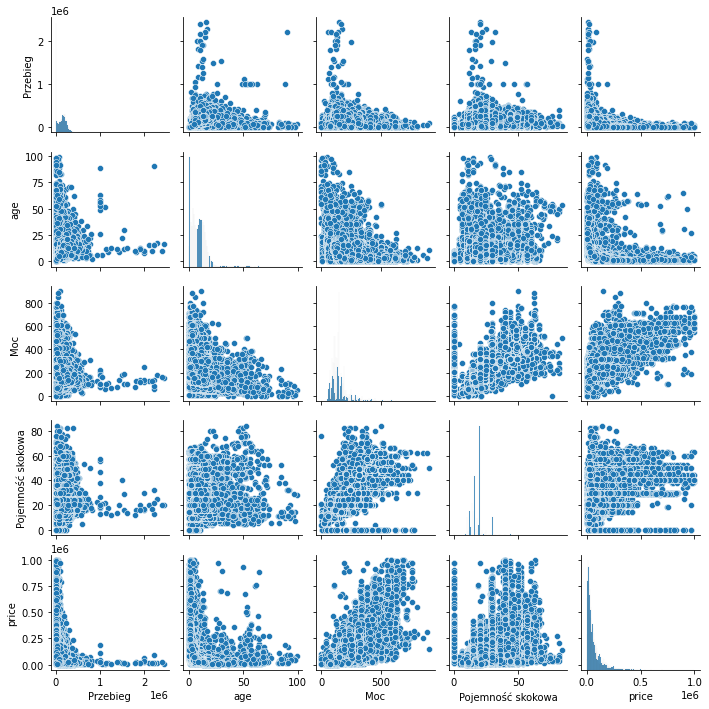

In [120]:
sns.pairplot(X_train.join(y_train)[["Przebieg", "age", "Moc", "Pojemność skokowa", "price"]], height=2)
plt.show()

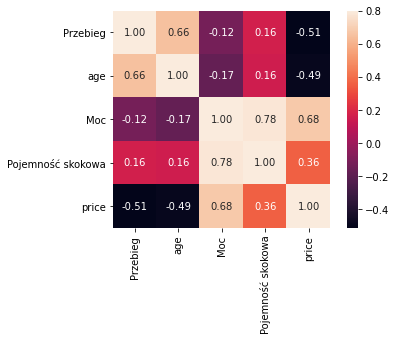

In [121]:
# Correlation matrix
corr_matr = X_train.join(y_train)\
            [["Przebieg", "age", "Moc", "Pojemność skokowa", "price"]]\
            .corr()
f, ax = plt.subplots(figsize=(6,4))
sns.heatmap(corr_matr, annot=True, fmt='.2f', vmax=.8, square=True);

##### Price dependence on the country of origin

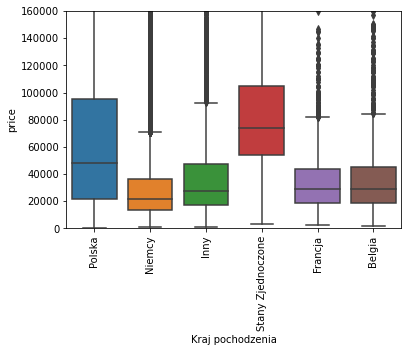

In [122]:
plt.figure(figsize=(6,4))
ax = sns.boxplot(x=X_train["Kraj pochodzenia"], y=y_train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylim(ymin=0, ymax=160000)
plt.show()

##### Price dependence on the colour

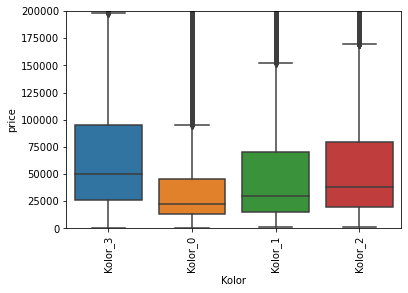

In [123]:
plt.figure(figsize=(6,4))
ax = sns.boxplot(x=X_train["Kolor"], y=y_train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylim(ymin=0, ymax=200000)
plt.show()

##### Price dependence on drive type 

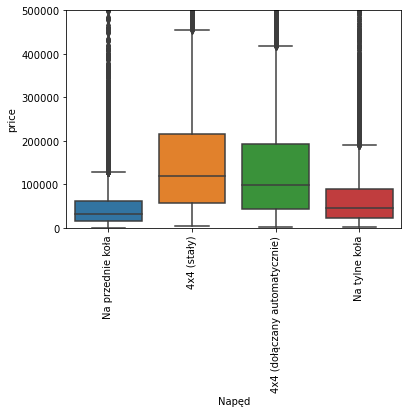

In [124]:
plt.figure(figsize=(6,4))
ax = sns.boxplot(x=X_train["Napęd"], y=y_train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylim(ymin=0, ymax=500000)
plt.show()

##### Price dependence on number of doors

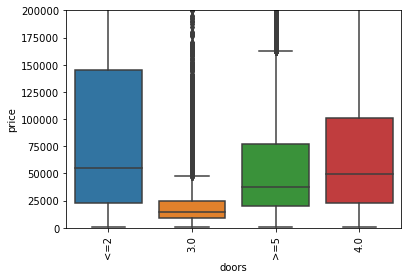

In [125]:
plt.figure(figsize=(6,4))
ax = sns.boxplot(x=X_train["doors"], y=y_train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylim(ymin=0, ymax=200000)
plt.show()

##### Price dependence on number of seats

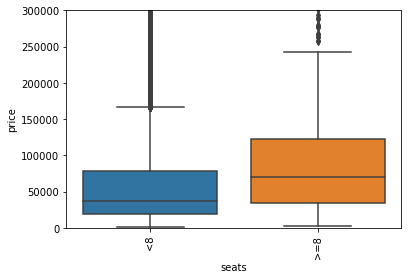

In [126]:
plt.figure(figsize=(6,4))
ax = sns.boxplot(x=X_train["seats"], y=y_train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylim(ymin=0, ymax=300000)
plt.show()

#### Top 20 features (binary columns) most correlated with the price

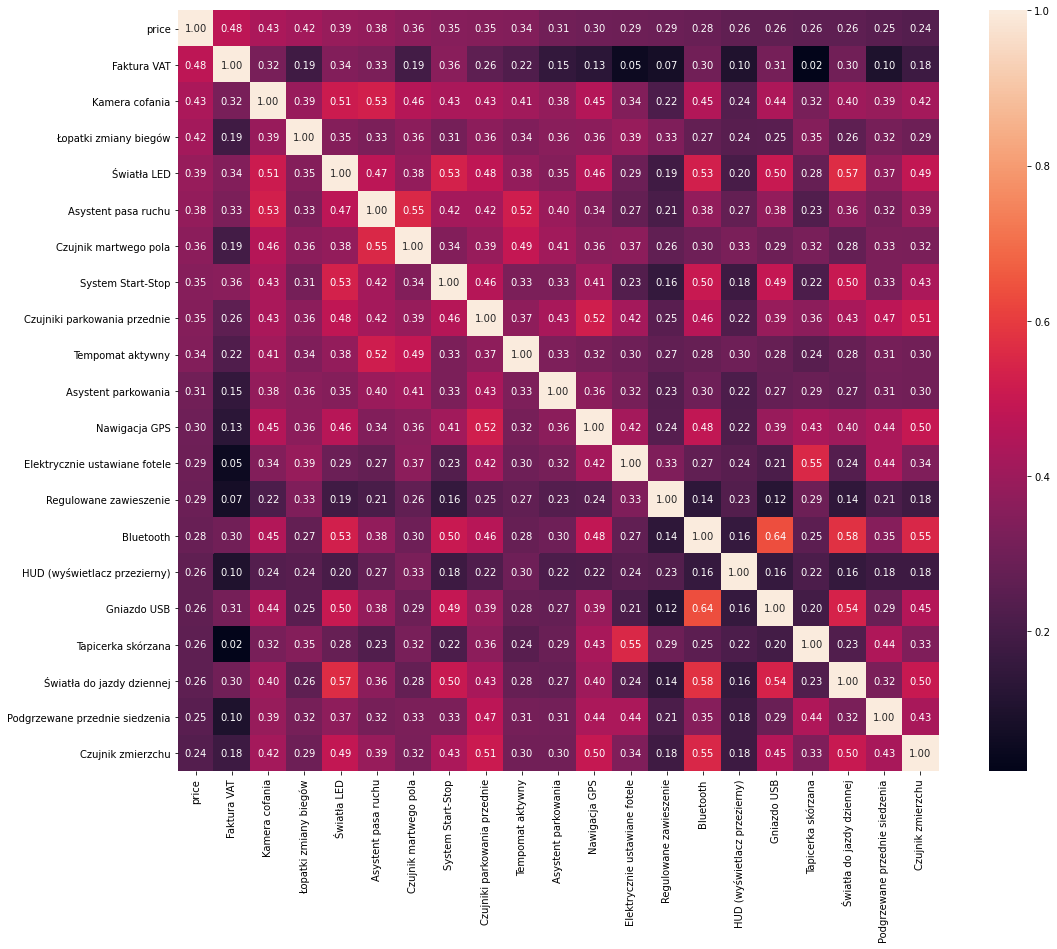

In [127]:
cols = [c for c in otomoto_preprocessor.bin_columns_ if c not in \
     ['Uszkodzony', 'Zarejestrowany jako zabytek', 'Matowy', 'Warranty if agreed with the buyer', 'Homologacja ciężarowa']]

# 20 features most correlated with the price
corr_matr = X_train[cols].join(y_train).corr()
corr_cols = corr_matr.nlargest(21, columns="price")["price"].index
cm = np.corrcoef(X_train.join(y_train)[corr_cols].values.T)
f, ax = plt.subplots(figsize=(18,14))
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', \
            annot_kws={'size': 10}, yticklabels=corr_cols.values, xticklabels=corr_cols.values);

##### Price dependence on price details

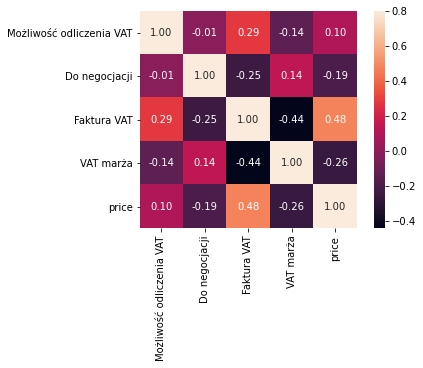

In [128]:
# Correlation matrix
corr_matr = X_train.join(y_train)[otomoto_preprocessor.price_details_ + ["VAT marża", "price"]].corr()
f, ax = plt.subplots(figsize=(6,4))
sns.heatmap(corr_matr, annot=True, fmt='.2f', vmax=.8, square=True);

### Columns

#### The columns to be removed 
Columns without value for the prediction or converted to others:
- "href", "price_evaluation", "seller_name" - without value for price prediction
- "currency" - only PLN,
- "Oferta od" - duplicates the information from the "seller_type" field,
- "Zarejestrowany jako zabytek", "Homologacja ciężarowa", "Warranty if agreed with the buyer", "Matowy", "Kod Silnika", "Tuning" - small number of records,
- "Emisja CO2" - small number of records and correlation with "Pojemność skokowa",
- "price_details", "Rok produkcji", "Pierwsza rejestracja", "Rodzaj paliwa", "Liczba drzwi", "Liczba miejsc", "Gwarancja dealerska (w cenie)", "Okres gwarancji producenta", "lub do (przebieg km)" - transformed to other columns,
- "Uszkodzony" - only undamaged cars are supported.

#### The columns that remain
Remaining columns will be divided into three groups:
- categorical features,
- numerical features,
- binary features.

In [129]:
remaining_cols = list(X_train.drop(columns=["href", "currency", "price_evaluation", "Oferta od", "seller_name", \
                      "Zarejestrowany jako zabytek", "Homologacja ciężarowa", "Kod Silnika", "price_details", \
                      "Emisja CO2", "Matowy", "Warranty if agreed with the buyer", "Rok produkcji", "Rodzaj paliwa", \
                      "Pierwsza rejestracja", "Liczba drzwi", "Liczba miejsc", "Gwarancja dealerska (w cenie)", \
                      "Okres gwarancji producenta", "lub do (przebieg km)", "Uszkodzony", "Tuning"]).columns)

In [130]:
# categorical features
cat_features = [c for c in remaining_cols if X_train[c].dtype == object]
cat_features

['seller_type',
 'Marka pojazdu',
 'Model pojazdu',
 'Napęd',
 'Typ',
 'Kolor',
 'Kraj pochodzenia',
 'Wersja',
 'Generacja',
 'fuel',
 'doors',
 'seats']

In [131]:
# numerical features
num_features = [c for c in remaining_cols if X_train[c].dtype == float]
num_features

['Przebieg', 'Pojemność skokowa', 'Moc', 'age']

In [132]:
# binary features
bin_features = [c for c in remaining_cols if X_train[c].dtype == "int8"]
bin_features

['Skrzynia biegów',
 'Faktura VAT',
 'Zarejestrowany w Polsce',
 'Pierwszy właściciel',
 'Bezwypadkowy',
 'Serwisowany w ASO',
 'Stan',
 'Metalik',
 'ABS',
 'Bluetooth',
 'Czujnik zmierzchu',
 'Elektrycznie ustawiane lusterka',
 'Gniazdo USB',
 'Klimatyzacja automatyczna',
 'MP3',
 'Poduszka powietrzna chroniąca kolana',
 'Poduszki boczne przednie',
 'Radio niefabryczne',
 'Światła do jazdy dziennej',
 'Szyberdach',
 'Alufelgi',
 'Centralny zamek',
 'Czujniki parkowania tylne',
 'ESP (stabilizacja toru jazdy)',
 'Immobilizer',
 'Komputer pokładowy',
 'Ogranicznik prędkości',
 'Poduszka powietrzna kierowcy',
 'Poduszki boczne tylne',
 'Radio fabryczne',
 'Światła LED',
 'Wielofunkcyjna kierownica',
 'ASR (kontrola trakcji)',
 'Czujnik deszczu',
 'Elektryczne szyby przednie',
 'Gniazdo AUX',
 'Isofix',
 'Kurtyny powietrzne',
 'Podgrzewane lusterka boczne',
 'Poduszka powietrzna pasażera',
 'Przyciemniane szyby',
 'Światła Xenonowe',
 'Światła przeciwmgielne',
 'Wspomaganie kierownicy',
 

In [133]:
len(bin_features)

88

In [134]:
# Check:
len(cat_features + num_features + bin_features) == len(remaining_cols)

True

In [135]:
# To arrange columns according to types for easier viewing:
remaining_cols = cat_features + num_features + bin_features

In [136]:
len(remaining_cols)

104

In [137]:
# Check NaNs
X_train[remaining_cols].isna().any().any()

False

In [138]:
X_train[remaining_cols].head(10000).tail(5)

,seller_type,Marka pojazdu,Model pojazdu,Napęd,Typ,Kolor,Kraj pochodzenia,Wersja,Generacja,fuel,doors,seats,Przebieg,Pojemność skokowa,Moc,age,Skrzynia biegów,Faktura VAT,Zarejestrowany w Polsce,Pierwszy właściciel,Bezwypadkowy,Serwisowany w ASO,Stan,Metalik,ABS,Bluetooth,Czujnik zmierzchu,Elektrycznie ustawiane lusterka,Gniazdo USB,Klimatyzacja automatyczna,MP3,Poduszka powietrzna chroniąca kolana,Poduszki boczne przednie,Radio niefabryczne,Światła do jazdy dziennej,Szyberdach,Alufelgi,Centralny zamek,Czujniki parkowania tylne,ESP (stabilizacja toru jazdy),Immobilizer,Komputer pokładowy,Ogranicznik prędkości,Poduszka powietrzna kierowcy,Poduszki boczne tylne,Radio fabryczne,Światła LED,Wielofunkcyjna kierownica,ASR (kontrola trakcji),Czujnik deszczu,Elektryczne szyby przednie,Gniazdo AUX,Isofix,Kurtyny powietrzne,Podgrzewane lusterka boczne,Poduszka powietrzna pasażera,Przyciemniane szyby,Światła Xenonowe,Światła przeciwmgielne,Wspomaganie kierownicy,Perłowy,Alarm,CD,Tapicerka welurowa,Gniazdo SD,Tempomat,Dach panoramiczny,Podgrzewana przednia szyba,Klimatyzacja manualna,System Start-Stop,Akryl (niemetalizowany),VAT marża,Asystent parkowania,Klimatyzacja dwustrefowa,Regulowane zawieszenie,Nawigacja GPS,Tapicerka skórzana,Elektrochromatyczne lusterko wsteczne,Czujniki parkowania przednie,Kamera cofania,Odtwarzacz DVD,Podgrzewane przednie siedzenia,Elektrochromatyczne lusterka boczne,Tuner TV,Łopatki zmiany biegów,Elektryczne szyby tylne,Elektrycznie ustawiane fotele,Klimatyzacja czterostrefowa,Asystent pasa ruchu,Czujnik martwego pola,Zmieniarka CD,Relingi dachowe,Hak,Tempomat aktywny,Podgrzewane tylne siedzenia,Kierownica po prawej (Anglik),Ogrzewanie postojowe,Filtr cząstek stałych,HUD (wyświetlacz przezierny),first_reg_flg,gas,warranty,Możliwość odliczenia VAT,Do negocjacji
11037,Osoba prywatna,audi,"audi, a8",4x4 (stały),Sedan,Kolor_2,Polska,"audi, a8, inny, inny","audi, a8, inny",Benzyna,4.0,<8,148500.0000,63.0000,500.0000,7.0000,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,0,1,1,0,0,0,1,0,0,1,0,1,1,1,1,1,1,0,1,1,0,1,1,1,1,1,1,1,0,0,1,1,0,0,0,1,0,0,0,1,1
11038,Autoryzowany Dealer,audi,"audi, q5",4x4 (stały),SUV,Kolor_3,Polska,"audi, q5, fy (2017-), inny","audi, q5, fy (2017-)",Benzyna,>=5,<8,10.0000,20.0000,245.0000,0.0000,0,1,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,0,1,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,1,1,1,0,1,1,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
11039,Dealer,audi,"audi, a6",Na przednie koła,Kombi,Kolor_3,Polska,"audi, a6, c6 (2004-2011), inny","audi, a6, c6 (2004-2011)",Benzyna,>=5,<8,203000.0000,24.0000,177.0000,15.0000,1,0,0,1,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,1,1,1,0,1,0,1,0,0,1,0,1,1,1,1,1,1,0,0,1,1,0,1,1,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
11040,Dealer,audi,"audi, a4",Na przednie koła,Kombi,Kolor_3,Niemcy,"audi, a4, b6 (2000-2004), inny","audi, a4, b6 (2000-2004)",Benzyna,>=5,<8,229258.0000,18.0000,190.0000,18.0000,1,0,0,1,0,1,1,1,1,0,0,0,1,1,1,0,1,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,1,1,1,1,0,1,1,1,0,1,1,1,1,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1
11041,Dealer,audi,"audi, a3",Na przednie koła,Kompakt,Kolor_0,Polska,"audi, a3, 8p (2003-2012), inny","audi, a3, 8p (2003-2012)",Benzyna,>=5,<8,196000.0000,20.0000,150.0000,15.0000,0,0,0,0,0,0,1,1,1,0,1,1,0,1,1,0,1,0,1,0,1,1,1,1,1,1,0,1,1,1,0,0,1,0,1,0,1,1,0,1,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


#### ColumnTransformer
Change categorical columns to one-hots and scale numeric columns. <br>
Choose K-best from binary columns.

SelectKBest is a primitive method but fast and does not require high computing power.

In [139]:
class MyOneHotEncoder(OneHotEncoder):
    """
    OneHotEncoder with the option of giving y as a parameter (y will be ignored) 
    """
    
    def __init__(self, dtype="int8", sparse=False, drop=None, handle_unknown="ignore"):     
        super().__init__(sparse=sparse, dtype=dtype, drop=None, handle_unknown=handle_unknown)
            
            
    def fit(self, X, y=None):
        return super().fit(X, y)

    
    def transform(self, X, y=None):        
        return super().transform(X)

In [140]:
class MyStandardScaler(StandardScaler):
    """
    StandardScaler which provides get_feature_names
    """          
            
    def fit(self, X, y=None):
        self.features = X.columns
        return super().fit(X, y)

    
    def transform(self, X, y=None):        
        return super().transform(X)
    
    
    def get_feature_names(self):
        return self.features

In [141]:
class MySelectKBest(SelectKBest):
    """
    SelectKBest which provides get_feature_names
    """    
    def fit(self, X, y=None):
        fitting = super().fit(X, y)            
        mask = super().get_support()
        self.features = X.columns[mask]        
        return fitting

    
    def transform(self, X, y=None):        
        return super().transform(X)
    
    
    def get_feature_names(self):
        return self.features

In [142]:
class MyLabelEncoder(LabelEncoder):
    """
    LabelEncoder which provides get_feature_names
    """    
    def fit(self, X, y=None):
        self.features = X.columns       
        return super().fit(X) 

    
    def transform(self, X, y=None):        
        return super().transform(X)
    
    
    def get_feature_names(self):
        return self.features

In [143]:
class MyColumnTransformer(ColumnTransformer):
    """
    ColumnTransformer with the option of giving y as a parameter (y will be ignored).
    Due to the available RAM, it changes data to float32.
    """               
    def fit(self, X, y=None):
        return super().fit(X, y)
    
    def transform(self, X, y=None):   
        X = super().transform(X)
        if X.dtype == "float64":
            X = X.astype("float32")
        return X

In [144]:
column_transformer = MyColumnTransformer(transformers=[
    ("cat_pipe", MyOneHotEncoder(), cat_features),
    ("num_pipe", MyStandardScaler(), num_features),
    ("bin_pipe", MySelectKBest(k=40), bin_features)],
    remainder="drop",
    n_jobs=2
)

In [145]:
column_transformer.fit(X_train, y_train)

MyColumnTransformer(n_jobs=2,
                    transformers=[('cat_pipe', MyOneHotEncoder(),
                                   ['seller_type', 'Marka pojazdu',
                                    'Model pojazdu', 'Napęd', 'Typ', 'Kolor',
                                    'Kraj pochodzenia', 'Wersja', 'Generacja',
                                    'fuel', 'doors', 'seats']),
                                  ('num_pipe', MyStandardScaler(),
                                   ['Przebieg', 'Pojemność skokowa', 'Moc',
                                    'age']),
                                  ('bin_pipe', MySelectKBest(k=40),
                                   ['Skrzynia biegów', 'Faktura VAT',
                                    'Zareje...
                                    'Gniazdo USB', 'Klimatyzacja automatyczna',
                                    'MP3',
                                    'Poduszka powietrzna chroniąca kolana',
                                    'Poduszki boczne przednie',
                                    'Radio niefabryczne',
                                    'Światła do jazdy dziennej', 'Szyberdach',
                                    'Alufelgi', 'Centralny zamek',
                                    'Czujniki parkowania tylne',
                                    'ESP (stabilizacja toru jazdy)',
                                    'Immobilizer', 'Komputer pokładowy',
                                    'Ogranicznik prędkości',
                                    'Poduszka powietrzna kierowcy',
                                    'Poduszki boczne tylne', 'Radio fabryczne', ...])])

In [146]:
X_train = column_transformer.transform(X_train)

In [147]:
X_train.dtype

dtype('float32')

In [148]:
# Data set after transformation:
pd.DataFrame(X_train, columns=column_transformer.get_feature_names()).head()

,cat_pipe__x0_Autoryzowany Dealer,cat_pipe__x0_Dealer,cat_pipe__x0_Osoba prywatna,cat_pipe__x1_alfa romeo,cat_pipe__x1_audi,cat_pipe__x1_bmw,cat_pipe__x1_chevrolet,cat_pipe__x1_chrysler,cat_pipe__x1_citroën,cat_pipe__x1_dacia,cat_pipe__x1_dodge,cat_pipe__x1_fiat,cat_pipe__x1_ford,cat_pipe__x1_honda,cat_pipe__x1_hyundai,cat_pipe__x1_inny,cat_pipe__x1_jaguar,cat_pipe__x1_jeep,cat_pipe__x1_kia,cat_pipe__x1_land rover,cat_pipe__x1_lexus,cat_pipe__x1_mazda,cat_pipe__x1_mercedes-benz,cat_pipe__x1_mini,cat_pipe__x1_mitsubishi,cat_pipe__x1_nissan,cat_pipe__x1_opel,cat_pipe__x1_peugeot,cat_pipe__x1_porsche,cat_pipe__x1_renault,cat_pipe__x1_saab,cat_pipe__x1_seat,cat_pipe__x1_subaru,cat_pipe__x1_suzuki,cat_pipe__x1_toyota,cat_pipe__x1_volkswagen,cat_pipe__x1_volvo,cat_pipe__x1_škoda,"cat_pipe__x2_alfa romeo, inny","cat_pipe__x2_audi, a3","cat_pipe__x2_audi, a4","cat_pipe__x2_audi, a5","cat_pipe__x2_audi, a6","cat_pipe__x2_audi, a8","cat_pipe__x2_audi, inny","cat_pipe__x2_audi, q3","cat_pipe__x2_audi, q5","cat_pipe__x2_audi, q7","cat_pipe__x2_bmw, inny","cat_pipe__x2_bmw, seria 1","cat_pipe__x2_bmw, seria 2","cat_pipe__x2_bmw, seria 3","cat_pipe__x2_bmw, seria 4","cat_pipe__x2_bmw, seria 5","cat_pipe__x2_bmw, seria 7","cat_pipe__x2_bmw, x1","cat_pipe__x2_bmw, x3","cat_pipe__x2_bmw, x5","cat_pipe__x2_bmw, x6","cat_pipe__x2_chevrolet, inny","cat_pipe__x2_chrysler, inny","cat_pipe__x2_citroën, berlingo","cat_pipe__x2_citroën, c3","cat_pipe__x2_citroën, c4","cat_pipe__x2_citroën, c4 grand picasso","cat_pipe__x2_citroën, c4 picasso","cat_pipe__x2_citroën, c5","cat_pipe__x2_citroën, inny","cat_pipe__x2_dacia, duster","cat_pipe__x2_dacia, inny","cat_pipe__x2_dodge, inny","cat_pipe__x2_fiat, 500","cat_pipe__x2_fiat, bravo","cat_pipe__x2_fiat, grande punto","cat_pipe__x2_fiat, inny","cat_pipe__x2_fiat, panda","cat_pipe__x2_fiat, tipo","cat_pipe__x2_ford, c-max","cat_pipe__x2_ford, fiesta","cat_pipe__x2_ford, focus","cat_pipe__x2_ford, galaxy","cat_pipe__x2_ford, inny","cat_pipe__x2_ford, kuga","cat_pipe__x2_ford, mondeo","cat_pipe__x2_ford, mustang","cat_pipe__x2_ford, s-max","cat_pipe__x2_honda, accord","cat_pipe__x2_honda, civic","cat_pipe__x2_honda, cr-v","cat_pipe__x2_honda, inny","cat_pipe__x2_honda, jazz","cat_pipe__x2_hyundai, i20","cat_pipe__x2_hyundai, i30","cat_pipe__x2_hyundai, i40","cat_pipe__x2_hyundai, inny","cat_pipe__x2_hyundai, ix35","cat_pipe__x2_hyundai, tucson","cat_pipe__x2_inny, inny","cat_pipe__x2_jaguar, inny","cat_pipe__x2_jeep, grand cherokee","cat_pipe__x2_jeep, inny","cat_pipe__x2_jeep, renegade","cat_pipe__x2_kia, ceed","cat_pipe__x2_kia, inny","cat_pipe__x2_kia, picanto","cat_pipe__x2_kia, rio","cat_pipe__x2_kia, sportage","cat_pipe__x2_land rover, inny","cat_pipe__x2_lexus, inny","cat_pipe__x2_mazda, 3","cat_pipe__x2_mazda, 5","cat_pipe__x2_mazda, 6","cat_pipe__x2_mazda, cx-5","cat_pipe__x2_mazda, inny","cat_pipe__x2_mercedes-benz, cla","cat_pipe__x2_mercedes-benz, gla","cat_pipe__x2_mercedes-benz, glc","cat_pipe__x2_mercedes-benz, gle","cat_pipe__x2_mercedes-benz, inny","cat_pipe__x2_mercedes-benz, klasa a","cat_pipe__x2_mercedes-benz, klasa b","cat_pipe__x2_mercedes-benz, klasa c","cat_pipe__x2_mercedes-benz, klasa e","cat_pipe__x2_mercedes-benz, klasa s","cat_pipe__x2_mini, countryman","cat_pipe__x2_mini, inny","cat_pipe__x2_mitsubishi, asx","cat_pipe__x2_mitsubishi, inny","cat_pipe__x2_mitsubishi, outlander","cat_pipe__x2_nissan, inny","cat_pipe__x2_nissan, juke","cat_pipe__x2_nissan, micra","cat_pipe__x2_nissan, note","cat_pipe__x2_nissan, qashqai","cat_pipe__x2_nissan, x-trail","cat_pipe__x2_opel, astra","cat_pipe__x2_opel, corsa","cat_pipe__x2_opel, crossland x","cat_pipe__x2_opel, inny","cat_pipe__x2_opel, insignia","cat_pipe__x2_opel, meriva","cat_pipe__x2_opel, mokka","cat_pipe__x2_opel, vectra","cat_pipe__x2_opel, vivaro","cat_pipe__x2_opel, zafira","cat_pipe__x2_peugeot, 2008","cat_pipe__x2_peugeot, 207","cat_pipe__x2_peugeot, 208","cat_pipe__x2_peugeot, 3008","cat_pipe__x2_peugeot, 307","cat_pipe__x2_pe

In [149]:
X_train.shape

(174915, 781)

#### [Save data]

In [150]:
# Dump X_train to pickle
with open("/".join([path, "X_train_2.obj"]), "wb") as fp:
    pickle.dump(X_train, fp)

In [151]:
# Read X_train from pickle 
with open("/".join([path, "X_train_2.obj"]), 'rb') as fp:
    X_train = pickle.load(fp)

### Dimensionality reduction
Principal Component Analysis for dimensionality reduction. It is carried out by the orthogonal projection of the data onto a lower dimensional linear space, known as the principal subspace, such that the variance of the projected data is maximized. After projection original features no longer exist and new features are constructed from the available data.

In [152]:
# Reduce the dimension maintaining 90% of the variance
pca = PCA(n_components=0.90)
pca.fit(X_train)

PCA(n_components=0.9)

In [153]:
X_train = pca.transform(X_train)

In [154]:
print("Number of new variables: {}\r\nShape of data after the projection onto new space: {}".\
      format(pca.n_components_, str(X_train.shape)))

Number of new variables: 110
Shape of data after the projection onto new space: (174915, 110)


In [155]:
# Shares of the obtained new variables in the variance:
print(pca.explained_variance_ratio_)

[0.1488747  0.1106459  0.0654194  0.02959065 0.02601677 0.02128244
 0.01787797 0.01625324 0.01611287 0.0159882  0.01425551 0.0131052
 0.01261829 0.01249699 0.01138743 0.01094362 0.01072837 0.01045784
 0.01007763 0.00986981 0.00953689 0.00896012 0.00878383 0.00866418
 0.00829452 0.00796937 0.00763922 0.00758861 0.00740487 0.00697833
 0.00679591 0.00669072 0.00642666 0.00625097 0.00612898 0.00607977
 0.005942   0.00567913 0.0055515  0.00542118 0.00521079 0.0051672
 0.00511537 0.00498723 0.00489868 0.00470253 0.00448411 0.00440311
 0.00429662 0.00418403 0.00406251 0.00397602 0.00389074 0.00382217
 0.00379029 0.00368008 0.00351289 0.00345184 0.00334894 0.0032774
 0.0031428  0.00306038 0.00294159 0.00287799 0.00279033 0.00266073
 0.00258378 0.00247835 0.00240145 0.0023909  0.00234542 0.00230151
 0.0022283  0.00218943 0.00208649 0.00200022 0.00194948 0.00189467
 0.00185152 0.00179864 0.00177498 0.00176525 0.0016944  0.00164398
 0.00159807 0.00156104 0.0015445  0.00153372 0.00150785 0.0014940

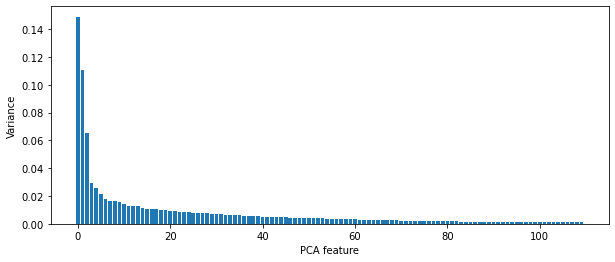

In [156]:
# Shares in variance for successive features:
plt.figure(figsize=(10,4))
features = range(pca.n_components_) 
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(np.arange(0, pca.n_components_, step=20)) 
plt.show()

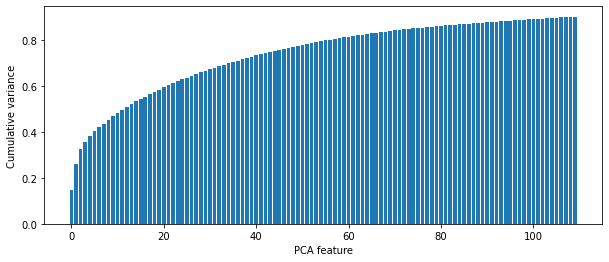

In [157]:
# Cumulative diagram
plt.figure(figsize=(10,4))
plt.bar(range(pca.n_components_), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('PCA feature')
plt.ylabel('Cumulative variance')
plt.xticks(np.arange(0, pca.n_components_, step=20)) 
plt.show()

In [158]:
# Shares of individual columns in features after dimension reduction
pca_columns = ["_".join(["pca", str(i)]) for i in range (pca.n_components_)]
loadings = pd.DataFrame(pca.components_.T, columns=pca_columns, index=column_transformer.get_feature_names())
loadings

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49,pca_50,pca_51,pca_52,pca_53,pca_54,pca_55,pca_56,pca_57,pca_58,pca_59,pca_60,pca_61,pca_62,pca_63,pca_64,pca_65,pca_66,pca_67,pca_68,pca_69,pca_70,pca_71,pca_72,pca_73,pca_74,pca_75,pca_76,pca_77,pca_78,pca_79,pca_80,pca_81,pca_82,pca_83,pca_84,pca_85,pca_86,pca_87,pca_88,pca_89,pca_90,pca_91,pca_92,pca_93,pca_94,pca_95,pca_96,pca_97,pca_98,pca_99,pca_100,pca_101,pca_102,pca_103,pca_104,pca_105,pca_106,pca_107,pca_108,pca_109
cat_pipe__x0_Autoryzowany Dealer,-0.0723,-0.1148,-0.0855,0.0479,0.0752,0.0118,0.0055,-0.0379,0.0236,0.0685,0.2786,0.0708,-0.0130,0.0639,-0.0295,-0.0040,0.0017,-0.0331,-0.0087,0.0457,0.0928,0.1849,0.1985,0.0730,0.0588,0.1295,0.2016,-0.0095,0.1993,0.1307,0.2846,0.0372,-0.1816,0.1967,0.2299,-0.0025,-0.0845,-0.0215,0.0149,0.0689,-0.1828,-0.0342,-0.0918,0.0762,0.1328,0.0008,-0.0135,-0.0411,-0.0355,-0.0244,-0.0995,0.0191,0.0124,-0.0009,0.0192,0.0691,0.0290,-0.0239,0.0247,-0.0021,-0.0082,-0.0021,-0.0150,0.0270,0.0210,-0.0108,0.0035,0.0096,0.0247,-0.0076,0.0380,0.0068,-0.0160,0.0138,0.0021,0.0592,-0.0180,0.0211,0.0742,0.0157,-0.0638,0.0427,0.0109,0.0133,0.0006,0.0002,-0.0149,0.0020,0.0007,-0.0063,-0.0178,-0.0001,-0.0025,-0.0045,0.0026,0.0055,0.0058,0.0059,0.0150,-0.0046,-0.0033,-0.0015,-0.0002,-0.0015,-0.0037,0.0062,-0.0041,0.0023,0.0044,0.0033
cat_pipe__x0_Dealer,0.0202,-0.0171,0.0561,-0.1372,-0.4861,-0.2368,0.3460,0.0742,0.0564,0.0977,-0.2798,0.0268,0.0500,-0.0497,0.0252,0.0484,0.0706,0.0661,0.0572,-0.0032,-0.0439,-0.0763,-0.1176,0.0647,-0.0904,-0.0982,-0.1588,0.0064,-0.0761,-0.0690,-0.1145,-0.0360,0.0513,-0.0742,-0.0711,0.0070,0.0217,0.0208,0.0158,-0.0155,0.0414,0.0017,0.0083,0.0122,-0.0226,-0.0054,0.0098,-0.0049,0.0023,0.0043,0.0301,-0.0212,0.0016,-0.0037,0.0042,-0.0179,-0.0021,0.0029,-0.0050,0.0077,0.0098,-0.0034,0.0031,-0.0052,-0.0115,0.0062,-0.0012,-0.0062,-0.0069,-0.0005,-0.0101,0.0020,0.0062,-0.0082,0.0045,-0.0084,-0.0008,0.0013,-0.0060,-0.0054,0.0009,0.0038,-0.0008,0.0003,0.0001,-0.0006,0.0057,0.0043,-0.0036,0.0013,0.0040,-0.0026,-0.0031,-0.0013,-0.0003,0.0006,-0.0014,-0.0038,-0.0055,-0.0006,0.0017,0.0002,0.0004,0.0004,0.0005,-0.0018,0.0000,-0.0004,-0.0030,0.0002
cat_pipe__x0_Osoba prywatna,0.0520,0.1319,0.0294,0.0892,0.4109,0.2250,-0.3516,-0.0364,-0.0800,-0.1662,0.0012,-0.0976,-0.0370,-0.0143,0.0043,-0.0444,-0.0723,-0.0330,-0.0485,-0.0425,-0.0488,-0.1086,-0.0809,-0.1377,0.0315,-0.0313,-0.0428,0.0031,-0.1231,-0.0618,-0.1701,-0.0012,0.1303,-0.1226,-0.1588,-0.0045,0.0627,0.0008,-0.0308,-0.0534,0.1414,0.0325,0.0835,-0.0884,-0.1102,0.0046,0.0037,0.0460,0.0332,0.0200,0.0694,0.0021,-0.0140,0.0046,-0.0234,-0.0512,-0.0269,0.0211,-0.0197,-0.0056,-0.0016,0.0055,0.0119,-0.0218,-0.0094,0.0047,-0.0023,-0.0033,-0.0177,0.0081,-0.0279,-0.0087,0.0099,-0.0056,-0.0066,-0.0508,0.0188,-0.0224,-0.0682,-0.0102,0.0628,-0.0465,-0.0102,-0.0137,-0.0007,0.0004,0.0092,-0.0063,0.0029,0.0049,0.0138,0.0026,0.0055,0.0058,-0.0024,-0.0061,-0.0044,-0.0021,-0.0095,0.0052,0.0016,0.0013,-0.0002,0.0011,0.0031,-0.0044,0.0041,-0.0019,-0.0014,-0.0035
cat_pipe__x1_alfa romeo,-0.0003,0.0004,-0.0020,-0.0017,0.0019,0.0025,0.0043,-0.0035,0.0022,-0.0014,-0.0013,0.0044,-0.0068,-0.0016,0.0019,0.0019,0.0027,0.0012,-0.0008,0.0020,-0.0014,0.0038,-0.0023,0.0025,0.0054,0.0001,0.0000,-0.0040,-0.0114,0.0159,-0.0026,-0.0016,-0.0021,0.0062,-0.0009,0.0023,0.0044,0.0047,-0.0069,0.0093,-0.0024,-0.0074,-0.0063,-0.0097,0.0005,0.0064,-0.0013,0.0061,0.0137,-0.0006,0.0004,-0.0030,0.0010,-0.0020,-0.0058,-0.0025,0.0000,0.0036,0.0094,0.0059,-0.0074,0.0048,0.0049,-0.0013,0.0067,-0.0019,-0.0073,0.0047,-0.0022,-0.0011,0.0012,-0.0002,0.0011,-0.0346,0.0023,0.0029,-0.0340,0.0270,-0.0036,0.0122,-0.0156,-0.0441,-0.0377,0.0565,-0.0285,0.0692,0.102

In [159]:
X_train.dtype

dtype('float32')

In [160]:
pd.DataFrame(X_train).isna().any().any()

False

In [161]:
# Data after transformation
pd.DataFrame(X_train, columns=pca_columns).head(3)

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49,pca_50,pca_51,pca_52,pca_53,pca_54,pca_55,pca_56,pca_57,pca_58,pca_59,pca_60,pca_61,pca_62,pca_63,pca_64,pca_65,pca_66,pca_67,pca_68,pca_69,pca_70,pca_71,pca_72,pca_73,pca_74,pca_75,pca_76,pca_77,pca_78,pca_79,pca_80,pca_81,pca_82,pca_83,pca_84,pca_85,pca_86,pca_87,pca_88,pca_89,pca_90,pca_91,pca_92,pca_93,pca_94,pca_95,pca_96,pca_97,pca_98,pca_99,pca_100,pca_101,pca_102,pca_103,pca_104,pca_105,pca_106,pca_107,pca_108,pca_109
0,0.7307,-1.3623,-2.3254,0.3109,-0.3839,1.1604,-0.6855,0.8118,-0.3631,-0.7295,0.3536,0.3260,-0.1930,-0.7380,0.0307,-0.2420,-0.0917,-0.0836,-0.5327,-0.3489,-0.0911,-0.4359,-0.3369,-0.0516,-0.2108,-0.0880,-0.2255,0.0219,-0.3058,0.2621,-0.2984,-0.0902,0.3679,-0.0772,0.1611,0.2673,0.3271,0.2054,0.0558,-0.1552,0.0765,-0.1006,-0.0547,-0.3269,-0.1610,0.2264,-0.0399,0.0652,0.2187,-0.1515,-0.1502,0.0484,-0.0209,-0.1578,-0.3498,0.1246,-0.1886,-0.3709,-0.3015,-0.1844,0.2533,-0.6648,-0.0724,0.1847,1.5971,0.0662,0.0055,-0.0590,0.2178,0.1409,-0.5772,-0.0369,-0.0313,0.5046,0.3877,-0.0571,0.2348,-0.1443,0.1403,0.1432,0.3055,0.0785,-0.0221,0.0278,0.0635,-0.0037,-0.0065,-0.0403,0.0734,-0.1126,-0.1491,0.1004,0.0600,-0.0913,-0.0274,0.1117,-0.0293,-0.1747,0.1987,0.1349,0.1907,0.1355,0.1062,0.0182,0.1671,-0.0531,-0.0072,-0.0036,-0.0393,0.0345
1,-0.6150,-1.7871,-0.8686,-0.7046,0.5748,0.0758,0.1166,-1.0212,0.0637,-0.0508,0.1241,-0.3120,0.2241,0.0318,0.5901,0.8190,0.2062,-0.3266,-0.1207,0.5586,0.6803,-0.4380,0.6762,0.5179,-0.1669,0.7205,0.0907,0.1230,-0.7142,0.5157,-0.2224,-0.0821,-0.2354,0.6848,0.0874,1.2230,-0.2365,0.4682,-0.0627,-0.3670,-0.4044,0.0889,-0.2975,0.2356,-0.2036,0.4672,-0.3995,-0.0986,-0.1008,0.2048,-0.3215,0.2320,0.3540,-0.2168,-0.2984,0.1829,0.0460,-0.2107,-0.0561,-0.0937,0.4383,-0.4191,0.0264,0.0481,1.6212,-0.0613,-0.1392,-0.2386,0.1984,0.1367,-0.6199,0.0105,-0.2049,0.3840,-0.5168,-0.1601,-0.1183,-0.0430,-0.1068,-0.0972,0.2009,-0.0531,-0.0128,-0.0760,0.1010,0.2122,0.0235,0.2551,-0.1235,0.2790,0.2208,-0.2174,-0.0128,0.0208,-0.0613,-0.1954,0.0365,-0.0993,-0.1804,-0.1339,-0.1568,-0.2373,0.4141,0.2624,-0.2037,-0.1089,0.0056,-0.0099,0.1014,-0.0301
2,1.0265,-1.1927,-2.2166,0.3520,0.0652,0.8836,-0.5182,0.6793,-0.2994,-0.8411,0.2459,0.4426,-0.2080,-0.6024,0.0491,-0.2004,-0.0191,-0.0903,-0.5394,-0.3305,-0.1219,-0.4521,-0.2778,0.1591,-0.2515,-0.1487,-0.5070,0.0472,-0.3743,0.2229,-0.5104,-0.0700,0.3734,-0.0294,0.0937,0.4076,0.4770,-0.0774,0.3815,0.1381,-0.2289,-0.2668,-0.1452,-0.1345,0.0225,0.2681,-0.0292,-0.1309,0.1275,-0.1527,-0.1026,0.1648,0.0329,-0.2674,-0.3706,0.2350,-0.2480,-0.3160,-0.2046,-0.1211,0.2541,-0.6989,-0.0596,0.2419,1.5631,-0.3219,-0.0647,-0.1070,0.2620,0.1130,-0.7267,0.1291,-0.0992,0.4421,-0.3816,-0.1459,-0.1249,-0.0108,0.1318,-0.0722,0.0435,0.0959,0.0826,0.0382,0.1259,0.0237,0.0462,-0.0112,0.1015,-0.0870,-0.1518,0.1623,0.0761,0.0134,0.0188,0.0232,-0.1110,0.0723,0.1249,0.1262,0.1605,0.1082,0.0863,-0.0091,0.1408,-0.0666,-0.0097,0.0077,0.0258,0.0963


#### [Save data]

In [162]:
# Dump X_train to pickle
with open("/".join([path, "X_train_pca.obj"]), "wb") as fp:
    pickle.dump(X_train, fp)

In [163]:
# Read X_train from pickle 
with open("/".join([path, "X_train_pca.obj"]), 'rb') as fp:
    X_train = pickle.load(fp)

## Model building and evaluation

### Auxiliary functions and variables

In [164]:
# Get data from pickle (full or reduced size)
# if size=1, get original size, if <> 1, reduce size
def get_data(training_set=True, size=1):
    file_x = "X_train.obj" if training_set else "X_test.obj"
    file_y = "y_train.obj" if training_set else "y_test.obj"
    
    with open("/".join([path, file_x]), 'rb') as fp:
        X = pickle.load(fp)
    
    with open("/".join([path, file_y]), 'rb') as fp:
        y = pickle.load(fp)   

    if size != 1:
        numbers_of_records = size if size > 1 else int(X.shape[0] * size)            
        X = X.head(numbers_of_records)
        y = y.head(numbers_of_records)      
        
    return X, y

In [177]:
class RegressionModelsCollector():   
    
    """
    Collection of models and their metrics
    Method "add" adds new model to collection, prints metrics and plots prediction error
    """
    
    def __init__(self):
        self.descriptions_ = {}
        self.models_ = {}
        self.x_shape_ ={}
        self.cv_results_ = {}
        self.cv_mean_ = {}
        self.cv_std_ = {}
        self.metrics_ = {}
        self.data_size_reduction_ = {}
        
    def add(self, name, description, model, cv_results, y_true, y_pred, x_shape, size_reduction=1, \
            with_print=True, with_plot=True):
        
        self.descriptions_[name] = description
        self.models_[name] = model
        self.x_shape_[name] = x_shape
        self.cv_results_[name] = cv_results
        self.cv_mean_[name] = cv_results.mean()
        self.cv_std_[name] = cv_results.std()
        self.metrics_[name] = self._get_metrics(y_true, y_pred)
        self.data_size_reduction_[name] = size_reduction 
        
        if with_print:
            self.info(name)
        if with_plot and y_true is not None and y_pred is not None:
            self._plot_prediction_error(y_true, y_pred)
    
                                                              
    def info(self, name):
        frm = '{:<30}{:>30.4f}'
        if name in self.models_:
            print("Model: {}, description: {}".format(name, self.descriptions_[name]))
            print("Shape of data: {}, REDUCTION = {}".format(self.x_shape_[name], self.data_size_reduction_[name]))
            print("Results for K-Folds: \r\n", self.cv_results_[name])
            print("Mean: {}, Std: {}".format(self.cv_mean_[name], self.cv_std_[name]))
            print()
            print("Metrics for the entire dataset:")
            print(frm.format("R^2 (coef. of determination):", self.metrics_[name]["r_2"]))
            print(frm.format("Explained variance score:", self.metrics_[name]["evs"]))
            print(frm.format("Mean squared error (MSE):", self.metrics_[name]["mse"]))
            print(frm.format("Mean absolute errors (MAE):", self.metrics_[name]["mae"]))  
            print(frm.format("Median absolute error:", self.metrics_[name]["med"]))
                                                              
    
    def get_list_of_models(self):
        return [k for k in self.models_keys]
        
    def get(self, name): 
        return self.descriptions_.get(name, None), \
               self.models_.get(name, None), \
               self.x_shape_.get(name, None), \
               self.cv_results_.get(name, None), \
               self.cv_mean_.get(name, None), \
               self.cv_std_.get(name, None), \
               self.metrics_.get(name, None), \
               self.data_size_reduction_.get(name, None)   
    
    
    def _get_metrics(self, y_true, y_pred):
        model_metrics = {
            "r_2": metrics.r2_score(y_true, y_pred),
            "mse": metrics.mean_squared_error(y_true, y_pred),
            "mae": metrics.mean_absolute_error(y_true, y_pred),
            "evs": metrics.explained_variance_score(y_true, y_pred),
            "med": metrics.median_absolute_error(y_true,y_pred)
        }
        return model_metrics
    

    def _plot_prediction_error(self, y_true, y_pred):
        # Prediction error plot
        plt.figure(figsize=(6,4));
        plt.plot(y_pred, (y_true-y_pred), '.', label= "1")
        plt.plot(np.linspace(min(y_pred), max(y_pred)), np.zeros(50), 'k')
        plt.xlabel('Predicted values')
        plt.ylabel("Residual values (error)")
        plt.show()

In [178]:
models_collector = RegressionModelsCollector()
scoring = "neg_mean_squared_error"

### The transforming pipeline 1

In [179]:
# Transformation hiperparameters (sample values - can be changed to fit)
enginepowerred1_n_lower = 0.50
enginepowerred1_n_upper = 1.50 
enginepowerred2_n_lower = 0.15
enginepowerred2_n_upper = 3.00
hierarchicalcat_min_size = 200
countrymerger_min_size = 2000
coloursmerger_bins = 4
pca_n_components = 0.90
pca_whiten = False
k_best = 40


# Data transformation through pipeline (to call after preprocessing)
estimators = []
estimators.append(("capacityimputer", AggregateImputer(column="Pojemność skokowa", \
                                      grouping_columns=["Marka pojazdu", "Model pojazdu", "fuel"], \
                                      aggregate="median")))
estimators.append(("enginepowerred1", EnginePowerDiscrReducer(subset="subset1", \
                                      n_lower=enginepowerred1_n_lower, \
                                      n_upper=enginepowerred1_n_upper)))  
estimators.append(("enginepowerred2", EnginePowerDiscrReducer(subset="subset1", \
                                      n_lower=enginepowerred2_n_lower, \
                                      n_upper=enginepowerred2_n_upper)))   
estimators.append(("enginepoweraggr", AggregateImputer(column="Moc", aggregate="median")))
estimators.append(("mileageimputer",  AggregateImputer(column="Przebieg", grouping_columns="age", \
                                      aggregate="median", alternative="ffill")))
estimators.append(("hierarchicalcat", HierarchicalColumnsCategorizer( \
                                      columns=["Marka pojazdu", "Model pojazdu", "Generacja", "Wersja"], 
                                      min_size=hierarchicalcat_min_size, unknown_value="inny")))
estimators.append(("countrymerger",   SmallGroupsMerger(column="Kraj pochodzenia", min_size=countrymerger_min_size, \
                                      unknown_value="Inny", fillna_value="Polska")))
estimators.append(("coloursmerger",   QuantilesMerger(column="Kolor", bins=coloursmerger_bins, \
                                      default_value="Inny kolor")))
estimators.append(("columntransform", MyColumnTransformer(transformers=[
                                      ("cat_pipe", MyOneHotEncoder(), cat_features),
                                      ("num_pipe", MyStandardScaler(), num_features),
                                      ("bin_pipe", MySelectKBest(k=k_best), bin_features)],
                                      remainder="drop", 
                                      n_jobs=2)))
estimators.append(("pca",             PCA(n_components=pca_n_components, whiten=pca_whiten)))

transformer = Pipeline(estimators)

##### The training data
Load the raw data and transform it throw the pipeline.

If "REDUCTION" < 1, the size of the training set will be reduced accordingly for the duration of the testing (for performance reasons or due to the available computing power). Some of the models require a reduction in the amount of data due to the required computing resources.

In [180]:
REDUCTION = 1  # full data set
X_train, y_train = get_data(training_set=True, size=REDUCTION)
X_train.shape, y_train.shape

((174915, 117), (174915,))

In [181]:
# Prepare the training data  
otomoto_preprocessor = OtoMotoPreprocessor()
X_train = otomoto_preprocessor.fit_transform(X_train, y_train)

In [182]:
# Setting parameters for transformation 
transformer.set_params(enginepowerred1__n_lower=enginepowerred1_n_lower, \
                       enginepowerred1__n_upper=enginepowerred1_n_upper, \
                       enginepowerred2__n_lower=enginepowerred2_n_lower, \
                       enginepowerred2__n_upper=enginepowerred2_n_upper, \
                       hierarchicalcat__min_size=int(hierarchicalcat_min_size * REDUCTION), \
                       countrymerger__min_size=int(countrymerger_min_size * REDUCTION), \
                       coloursmerger__bins=coloursmerger_bins, \
                       columntransform__bin_pipe__k=k_best, \
                       pca__n_components=pca_n_components, \
                       pca__whiten=pca_whiten)

# Fit the transformer on the trainig data
transformer.fit(X_train, y_train)

Pipeline(steps=[('capacityimputer',
                 AggregateImputer(column='Pojemność skokowa',
                                  grouping_columns=['Marka pojazdu',
                                                    'Model pojazdu', 'fuel'])),
                ('enginepowerred1',
                 EnginePowerDiscrReducer(n_lower=0.5, n_upper=1.5,
                                         subset='subset1')),
                ('enginepowerred2',
                 EnginePowerDiscrReducer(n_lower=0.15, n_upper=3.0,
                                         subset='subset1')),
                ('enginepoweraggr', AggregateImputer(colum...
                                                     'chroniąca kolana',
                                                     'Poduszki boczne przednie',
                                                     'Radio niefabryczne',
                                                     'Światła do jazdy '
                                                     'dziennej',
                                                     'Szyberdach', 'Alufelgi',
                                                     'Centralny zamek',
                                                     'Czujniki parkowania '
                                                     'tylne',
                                                     'ESP (stabilizacja toru '
                                                     'jazdy)',
                                                     'Immobilizer',
                                                     'Komputer pokładowy',
                                                     'Ogranicznik prędkości',
                                                     'Poduszka powietrzna '
                                                     'kierowcy',
                                                     'Poduszki boczne tylne',
                                                     'Radio fabryczne', ...])])),
                ('pca', PCA(n_components=0.9))])

In [183]:
# Transform the training data
X_train = transformer.transform(X_train)
X_train.shape

(174915, 124)

##### The test data
To check that transformer works also on the test data.

In [184]:
X_test, y_test = get_data(False)
X_test.shape, y_test.shape

((9207, 117), (9207,))

In [185]:
# Transform the test data
X_test = otomoto_preprocessor.transform(X_test, y_test)

In [186]:
# Transform the test data
X_test = transformer.transform(X_test)
X_test.shape

(9207, 124)

### Models with the transforming pipeline 1

In [187]:
kfold = KFold(n_splits=5, shuffle=True, random_state=123)

#### Linear regression without regularization

Model: LR1, description: Linear model without regularization
Shape of data: (174915, 124), REDUCTION = 1
Results for K-Folds: 
 [-6.62472994e+09 -6.63667545e+09 -6.66004670e+09 -6.66811805e+09
 -6.49066575e+09]
Mean: -6616047176.546129, Std: 64604567.253152214

Metrics for the entire dataset:
R^2 (coef. of determination):                         0.0007
Explained variance score:                             0.0007
Mean squared error (MSE):                    6607245218.3413
Mean absolute errors (MAE):                       50712.1119
Median absolute error:                            40866.0000


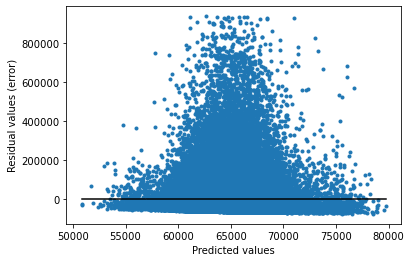

In [188]:
name, description, model = ("LR1", "Linear model without regularization", \
                            linear_model.LinearRegression())
cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)

model.fit(X_train, y_train)
y_pred = model.predict(X_train)

models_collector.add(name=name, description=description, model=model, cv_results=cv_results, \
                     y_true=y_train, y_pred=y_pred, x_shape=X_train.shape, size_reduction=REDUCTION)

The linear regression model does not predict prices well. We can see that the dependence is not linear. <br>
The coeficient R2 is close to zero and the measures of errors are high.

Attempts with polynomial regression would require a reduction in the amount of data due to memory consumption. Let's try to apply a tree algorithm.

#### Decision Tree Regression

In [189]:
grid = GridSearchCV(DecisionTreeRegressor(criterion="mse", random_state=33),
                    param_grid = {'min_samples_leaf': [10,50,100,150],
                                  'min_samples_split': [2,4,20,40],
                                  'max_features': [None,"sqrt","log2"]},
                    cv=kfold,
                    refit=False,
                    pre_dispatch=2
                   )

grid.fit(X_train, y_train)
grid.best_params_  # grid.best_estimator_ is not available if refit is a function.

{'max_features': 'log2', 'min_samples_leaf': 150, 'min_samples_split': 2}

Model: DTR1, description: DecisionTreeRegressor: log2, min_samples_leaf=150, min_samples_split=2
Shape of data: (174915, 124), REDUCTION = 1
Results for K-Folds: 
 [-6.81557400e+09 -6.82843653e+09 -6.85382947e+09 -6.85403831e+09
 -6.67191936e+09]
Mean: -6804759533.454022, Std: 68059267.4568168

Metrics for the entire dataset:
R^2 (coef. of determination):                         0.0300
Explained variance score:                             0.0300
Mean squared error (MSE):                    6413790620.5926
Mean absolute errors (MAE):                       49982.2767
Median absolute error:                            37651.0176


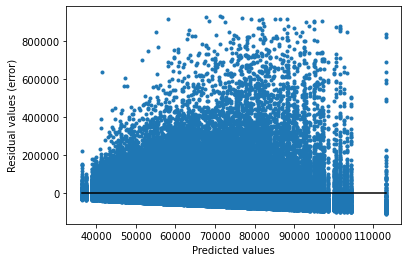

In [191]:
name, description, model = ("DTR1", "DecisionTreeRegressor: log2, min_samples_leaf=150, min_samples_split=2", \
               DecisionTreeRegressor(criterion="mse", random_state=33, \
                                     max_features="log2", min_samples_leaf=150, min_samples_split= 2))
cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)

model.fit(X_train, y_train)
y_pred = model.predict(X_train)

models_collector.add(name=name, description=description, model=model, cv_results=cv_results, \
                     y_true=y_train, y_pred=y_pred, x_shape=X_train.shape, size_reduction=REDUCTION)

The above model still does not predict prices well. <br>
The coeficient R2 is close to zero and the measures of errors are high.

With further hyperparameter tuning, the model does not improve significantly.

#### Neural Network 1

In [195]:
# Define base model
def baseline_model():
    # Create model
    model = Sequential()
    model.add(Dense(40, input_dim=X_train.shape[1], kernel_initializer='normal', activation="relu"))
    model.add(Dense(1, kernel_initializer="normal", activation="linear"))    
    
    # Compile model
    model.compile(loss="mean_squared_error", optimizer="adam")
    return model


# Evaluate model
name, description, model = ("NN1", "KerasRegressor layers: [40, 1], without regularization", \
               KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=32, verbose=2))
cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)

Epoch 1/100
4373/4373 - 2s - loss: 10430217216.0000
Epoch 2/100
4373/4373 - 2s - loss: 9103727616.0000
Epoch 3/100
4373/4373 - 2s - loss: 7656061440.0000
Epoch 4/100
4373/4373 - 2s - loss: 6846487552.0000
Epoch 5/100
4373/4373 - 2s - loss: 6673901568.0000
Epoch 6/100
4373/4373 - 2s - loss: 6660099072.0000
Epoch 7/100
4373/4373 - 2s - loss: 6655821824.0000
Epoch 8/100
4373/4373 - 2s - loss: 6652047360.0000
Epoch 9/100
4373/4373 - 2s - loss: 6648622592.0000
Epoch 10/100
4373/4373 - 2s - loss: 6645491200.0000
Epoch 11/100
4373/4373 - 2s - loss: 6642665472.0000
Epoch 12/100
4373/4373 - 2s - loss: 6640062464.0000
Epoch 13/100
4373/4373 - 2s - loss: 6637630976.0000
Epoch 14/100
4373/4373 - 2s - loss: 6635493376.0000
Epoch 15/100
4373/4373 - 2s - loss: 6633492992.0000
Epoch 16/100
4373/4373 - 2s - loss: 6631641600.0000
Epoch 17/100
4373/4373 - 2s - loss: 6629942272.0000
Epoch 18/100
4373/4373 - 2s - loss: 6628392448.0000
Epoch 19/100
4373/4373 - 2s - loss: 6626913792.0000
Epoch 20/100
4373/43

Epoch 59/100
4373/4373 - 2s - loss: 6605150720.0000
Epoch 60/100
4373/4373 - 2s - loss: 6605030400.0000
Epoch 61/100
4373/4373 - 2s - loss: 6604918272.0000
Epoch 62/100
4373/4373 - 2s - loss: 6604825088.0000
Epoch 63/100
4373/4373 - 2s - loss: 6604694016.0000
Epoch 64/100
4373/4373 - 2s - loss: 6604550656.0000
Epoch 65/100
4373/4373 - 2s - loss: 6604532736.0000
Epoch 66/100
4373/4373 - 2s - loss: 6604400128.0000
Epoch 67/100
4373/4373 - 2s - loss: 6604326400.0000
Epoch 68/100
4373/4373 - 2s - loss: 6604268032.0000
Epoch 69/100
4373/4373 - 2s - loss: 6604157952.0000
Epoch 70/100
4373/4373 - 2s - loss: 6604126720.0000
Epoch 71/100
4373/4373 - 2s - loss: 6604011008.0000
Epoch 72/100
4373/4373 - 2s - loss: 6603963392.0000
Epoch 73/100
4373/4373 - 2s - loss: 6603912192.0000
Epoch 74/100
4373/4373 - 2s - loss: 6603850752.0000
Epoch 75/100
4373/4373 - 2s - loss: 6603803648.0000
Epoch 76/100
4373/4373 - 2s - loss: 6603764736.0000
Epoch 77/100
4373/4373 - 2s - loss: 6603655168.0000
Epoch 78/100

4373/4373 - 2s - loss: 6619193344.0000
Epoch 17/100
4373/4373 - 2s - loss: 6617551360.0000
Epoch 18/100
4373/4373 - 2s - loss: 6616062976.0000
Epoch 19/100
4373/4373 - 2s - loss: 6614682624.0000
Epoch 20/100
4373/4373 - 2s - loss: 6613407232.0000
Epoch 21/100
4373/4373 - 2s - loss: 6612207616.0000
Epoch 22/100
4373/4373 - 2s - loss: 6611116544.0000
Epoch 23/100
4373/4373 - 2s - loss: 6610036736.0000
Epoch 24/100
4373/4373 - 2s - loss: 6609046528.0000
Epoch 25/100
4373/4373 - 2s - loss: 6608309760.0000
Epoch 26/100
4373/4373 - 2s - loss: 6607463424.0000
Epoch 27/100
4373/4373 - 2s - loss: 6606724608.0000
Epoch 28/100
4373/4373 - 2s - loss: 6606004736.0000
Epoch 29/100
4373/4373 - 2s - loss: 6605327872.0000
Epoch 30/100
4373/4373 - 2s - loss: 6604722688.0000
Epoch 31/100
4373/4373 - 2s - loss: 6604116992.0000
Epoch 32/100
4373/4373 - 2s - loss: 6603563008.0000
Epoch 33/100
4373/4373 - 2s - loss: 6603089920.0000
Epoch 34/100
4373/4373 - 2s - loss: 6602601472.0000
Epoch 35/100
4373/4373 - 

Epoch 74/100
4373/4373 - 2s - loss: 6639474688.0000
Epoch 75/100
4373/4373 - 2s - loss: 6639380480.0000
Epoch 76/100
4373/4373 - 2s - loss: 6639353344.0000
Epoch 77/100
4373/4373 - 2s - loss: 6639285760.0000
Epoch 78/100
4373/4373 - 2s - loss: 6639262208.0000
Epoch 79/100
4373/4373 - 2s - loss: 6639207424.0000
Epoch 80/100
4373/4373 - 2s - loss: 6639191040.0000
Epoch 81/100
4373/4373 - 2s - loss: 6639119360.0000
Epoch 82/100
4373/4373 - 2s - loss: 6639108096.0000
Epoch 83/100
4373/4373 - 2s - loss: 6639066624.0000
Epoch 84/100
4373/4373 - 2s - loss: 6639042048.0000
Epoch 85/100
4373/4373 - 2s - loss: 6638996992.0000
Epoch 86/100
4373/4373 - 2s - loss: 6638955520.0000
Epoch 87/100
4373/4373 - 2s - loss: 6638929408.0000
Epoch 88/100
4373/4373 - 2s - loss: 6638909440.0000
Epoch 89/100
4373/4373 - 2s - loss: 6638829568.0000
Epoch 90/100
4373/4373 - 2s - loss: 6638877184.0000
Epoch 91/100
4373/4373 - 2s - loss: 6638810112.0000
Epoch 92/100
4373/4373 - 2s - loss: 6638777344.0000
Epoch 93/100

Epoch 1/100
5467/5467 - 2s - loss: 10339581952.0000
Epoch 2/100
5467/5467 - 2s - loss: 8723777536.0000
Epoch 3/100
5467/5467 - 2s - loss: 7218074112.0000
Epoch 4/100
5467/5467 - 2s - loss: 6702550016.0000
Epoch 5/100
5467/5467 - 2s - loss: 6663158272.0000
Epoch 6/100
5467/5467 - 2s - loss: 6657827840.0000
Epoch 7/100
5467/5467 - 2s - loss: 6653378048.0000
Epoch 8/100
5467/5467 - 2s - loss: 6649432576.0000
Epoch 9/100
5467/5467 - 2s - loss: 6645937152.0000
Epoch 10/100
5467/5467 - 2s - loss: 6642700800.0000
Epoch 11/100
5467/5467 - 2s - loss: 6639934464.0000
Epoch 12/100
5467/5467 - 2s - loss: 6637367808.0000
Epoch 13/100
5467/5467 - 2s - loss: 6635058176.0000
Epoch 14/100
5467/5467 - 2s - loss: 6632956416.0000
Epoch 15/100
5467/5467 - 3s - loss: 6631143936.0000
Epoch 16/100
5467/5467 - 2s - loss: 6629376000.0000
Epoch 17/100
5467/5467 - 2s - loss: 6627814912.0000
Epoch 18/100
5467/5467 - 2s - loss: 6626358784.0000
Epoch 19/100
5467/5467 - 2s - loss: 6625065984.0000
Epoch 20/100
5467/54

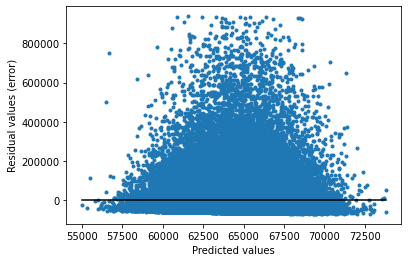

In [196]:
model.fit(X_train, y_train)
y_pred = model.predict(X_train)

models_collector.add(name=name, description=description, model=model, cv_results=cv_results, \
                     y_true=y_train, y_pred=y_pred, x_shape=X_train.shape, size_reduction=REDUCTION)

The above model has not learned to predict.<br>
Let's try to transform the data in a different way.

### The transforming pipeline 2

In [198]:
# Transformation hiperparameters (sample values - can be changed to fit)
enginepowerred1_n_lower = 0.50
enginepowerred1_n_upper = 2.50   
enginepowerred2_n_lower = 0.15
enginepowerred2_n_upper = 3.00
hierarchicalcat_min_size = 200    
modelsmerger_bins = 10            # divide car models on 10 classes
countrymerger_min_size = 2000
coloursmerger_bins = 4
pca_n_components = 0.99           # higer then previously
pca_whiten = True                 # changed
k_best = 50                       # higer then previously


# remain only "Model pojazdu" (after joining with a brand and after transformation to classes),
# drop columns "Marka pojazdu", "Generacja" i "Wersja"
cat_features2 = [e for e in cat_features if e not in ["Marka pojazdu", "Generacja", "Wersja"]]


# Data transformation through pipeline (to call after preprocessing)
estimators = []
estimators.append(("capacityimputer", AggregateImputer(column="Pojemność skokowa", \
                                      grouping_columns=["Marka pojazdu", "Model pojazdu", "fuel"], \
                                      aggregate="median")))
estimators.append(("enginepowerred1", EnginePowerDiscrReducer(subset="subset1", \
                                      n_lower=enginepowerred1_n_lower, \
                                      n_upper=enginepowerred1_n_upper)))  
estimators.append(("enginepowerred2", EnginePowerDiscrReducer(subset="subset1", \
                                      n_lower=enginepowerred2_n_lower, \
                                      n_upper=enginepowerred2_n_upper)))   
estimators.append(("enginepoweraggr", AggregateImputer(column="Moc", aggregate="median")))
estimators.append(("mileageimputer",  AggregateImputer(column="Przebieg", grouping_columns="age", \
                                      aggregate="median", alternative="ffill")))
estimators.append(("hierarchicalcat", HierarchicalColumnsCategorizer( \
                                      columns=["Marka pojazdu", "Model pojazdu"], \
                                      min_size=hierarchicalcat_min_size, unknown_value="inny")))
estimators.append(("modelsmerger",    QuantilesMerger(column="Model pojazdu", bins=modelsmerger_bins, \
                                      default_value="inny")))      # new element in transformation
estimators.append(("countrymerger",   SmallGroupsMerger(column="Kraj pochodzenia", min_size=countrymerger_min_size, \
                                      unknown_value="Inny", fillna_value="Polska")))
estimators.append(("coloursmerger",   QuantilesMerger(column="Kolor", bins=coloursmerger_bins, \
                                      default_value="Inny kolor")))
estimators.append(("columntransform", MyColumnTransformer(transformers=[
                                      ("cat_pipe", MyOneHotEncoder(), cat_features2),
                                      ("num_pipe", MyStandardScaler(), num_features),
                                      ("bin_pipe", MySelectKBest(k=k_best), bin_features)],
                                      remainder="drop", 
                                      n_jobs=2)))
estimators.append(("pca",             PCA(n_components=pca_n_components, whiten=pca_whiten)))

transformer = Pipeline(estimators)

In [199]:
REDUCTION = 1  # full data set
X_train, y_train = get_data(training_set=True, size=REDUCTION)
X_train.shape, y_train.shape

((174915, 117), (174915,))

In [200]:
# Prepare the training data  
otomoto_preprocessor = OtoMotoPreprocessor()
X_train = otomoto_preprocessor.fit_transform(X_train, y_train)

In [201]:
# Setting parameters for transformation 
transformer.set_params(enginepowerred1__n_lower=enginepowerred1_n_lower, \
                       enginepowerred1__n_upper=enginepowerred1_n_upper, \
                       enginepowerred2__n_lower=enginepowerred2_n_lower, \
                       enginepowerred2__n_upper=enginepowerred2_n_upper, \
                       hierarchicalcat__min_size=int(hierarchicalcat_min_size * REDUCTION), \
                       modelsmerger__bins=modelsmerger_bins, \
                       countrymerger__min_size=int(countrymerger_min_size * REDUCTION), \
                       coloursmerger__bins=coloursmerger_bins, \
                       columntransform__bin_pipe__k=k_best, \
                       pca__n_components=pca_n_components, \
                       pca__whiten=pca_whiten)

# Fit the transformer on the trainig data
transformer.fit(X_train, y_train)

Pipeline(steps=[('capacityimputer',
                 AggregateImputer(column='Pojemność skokowa',
                                  grouping_columns=['Marka pojazdu',
                                                    'Model pojazdu', 'fuel'])),
                ('enginepowerred1',
                 EnginePowerDiscrReducer(n_lower=0.5, n_upper=2.5,
                                         subset='subset1')),
                ('enginepowerred2',
                 EnginePowerDiscrReducer(n_lower=0.15, n_upper=3.0,
                                         subset='subset1')),
                ('enginepoweraggr', AggregateImputer(colum...
                                                     'Poduszki boczne przednie',
                                                     'Radio niefabryczne',
                                                     'Światła do jazdy '
                                                     'dziennej',
                                                     'Szyberdach', 'Alufelgi',
                                                     'Centralny zamek',
                                                     'Czujniki parkowania '
                                                     'tylne',
                                                     'ESP (stabilizacja toru '
                                                     'jazdy)',
                                                     'Immobilizer',
                                                     'Komputer pokładowy',
                                                     'Ogranicznik prędkości',
                                                     'Poduszka powietrzna '
                                                     'kierowcy',
                                                     'Poduszki boczne tylne',
                                                     'Radio fabryczne', ...])])),
                ('pca', PCA(n_components=0.99, whiten=True))])

In [202]:
# Transform the training data
X_train = transformer.transform(X_train)
X_train.shape

(174915, 81)

### Models with the transforming pipeline 2

#### Decision Tree Regression

In [203]:
grid = GridSearchCV(DecisionTreeRegressor(criterion="mse", random_state=33),
                    param_grid = {'min_samples_leaf': [10,80,150],
                                  'min_samples_split': [2,10],
                                  'max_features': ["log2"]},
                    cv=kfold,
                    refit=False,
                    pre_dispatch=2
                   )

grid.fit(X_train, y_train)
grid.best_params_  # grid.best_estimator_ is not available if refit is a function.

{'max_features': 'log2', 'min_samples_leaf': 150, 'min_samples_split': 2}

Model: DTR1/TR2, description: Transformer2, DecisionTreeRegressor: log2, min_samples_leaf=150, min_samples_split=2
Shape of data: (174915, 81), REDUCTION = 1
Results for K-Folds: 
 [-6.82425869e+09 -6.81491689e+09 -6.85062385e+09 -6.86818068e+09
 -6.70393810e+09]
Mean: -6812383643.859499, Std: 57416884.54277387

Metrics for the entire dataset:
R^2 (coef. of determination):                         0.0306
Explained variance score:                             0.0306
Mean squared error (MSE):                    6409287770.3636
Mean absolute errors (MAE):                       49943.0974
Median absolute error:                            37643.9750


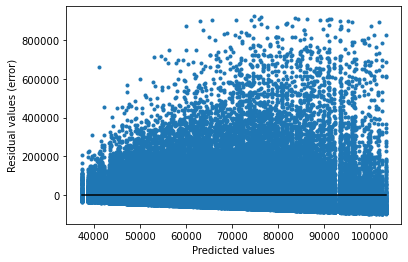

In [204]:
name, description, model = ("DTR1/TR2", \
                            "Transformer2, DecisionTreeRegressor: log2, min_samples_leaf=150, min_samples_split=2", \
                            DecisionTreeRegressor(criterion="mse", random_state=33, \
                                                  max_features="log2", min_samples_leaf=150, min_samples_split= 2))
cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)

model.fit(X_train, y_train)
y_pred = model.predict(X_train)

models_collector.add(name=name, description=description, model=model, cv_results=cv_results, \
                     y_true=y_train, y_pred=y_pred, x_shape=X_train.shape, size_reduction=REDUCTION)

No effects.

#### Neural network 1, without regularization

In [207]:
# Define base model
def baseline_model():
    # Create model
    model = Sequential()
    model.add(Dense(40, input_dim=X_train.shape[1], kernel_initializer='normal', activation="relu"))
    model.add(Dense(1, kernel_initializer="normal", activation="linear"))    
    
    # Compile model
    model.compile(loss="mean_squared_error", optimizer="adam")
    return model


# Evaluate model
name, description, model = ("NN1/TR2", "Transformer2, KerasRegressor layers: [40, 1], without regularization", \
               KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=32, verbose=2))
cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)

Epoch 1/100
4373/4373 - 2s - loss: 9863155712.0000
Epoch 2/100
4373/4373 - 2s - loss: 7409774080.0000
Epoch 3/100
4373/4373 - 2s - loss: 6691848192.0000
Epoch 4/100
4373/4373 - 1s - loss: 6660611072.0000
Epoch 5/100
4373/4373 - 2s - loss: 6649115136.0000
Epoch 6/100
4373/4373 - 2s - loss: 6640353280.0000
Epoch 7/100
4373/4373 - 2s - loss: 6633554944.0000
Epoch 8/100
4373/4373 - 2s - loss: 6628274688.0000
Epoch 9/100
4373/4373 - 2s - loss: 6624077824.0000
Epoch 10/100
4373/4373 - 1s - loss: 6620814336.0000
Epoch 11/100
4373/4373 - 1s - loss: 6618244608.0000
Epoch 12/100
4373/4373 - 1s - loss: 6616218112.0000
Epoch 13/100
4373/4373 - 2s - loss: 6614519808.0000
Epoch 14/100
4373/4373 - 2s - loss: 6613235200.0000
Epoch 15/100
4373/4373 - 2s - loss: 6612205568.0000
Epoch 16/100
4373/4373 - 2s - loss: 6611348480.0000
Epoch 17/100
4373/4373 - 2s - loss: 6610610688.0000
Epoch 18/100
4373/4373 - 2s - loss: 6609942528.0000
Epoch 19/100
4373/4373 - 2s - loss: 6609590784.0000
Epoch 20/100
4373/437

Epoch 59/100
4373/4373 - 2s - loss: 6604922880.0000
Epoch 60/100
4373/4373 - 2s - loss: 6604883456.0000
Epoch 61/100
4373/4373 - 2s - loss: 6604947456.0000
Epoch 62/100
4373/4373 - 2s - loss: 6604972032.0000
Epoch 63/100
4373/4373 - 2s - loss: 6604932608.0000
Epoch 64/100
4373/4373 - 2s - loss: 6604936704.0000
Epoch 65/100
4373/4373 - 2s - loss: 6604937728.0000
Epoch 66/100
4373/4373 - 2s - loss: 6604917248.0000
Epoch 67/100
4373/4373 - 2s - loss: 6604900864.0000
Epoch 68/100
4373/4373 - 2s - loss: 6604978688.0000
Epoch 69/100
4373/4373 - 2s - loss: 6604908032.0000
Epoch 70/100
4373/4373 - 2s - loss: 6604890624.0000
Epoch 71/100
4373/4373 - 2s - loss: 6604944896.0000
Epoch 72/100
4373/4373 - 1s - loss: 6604896768.0000
Epoch 73/100
4373/4373 - 2s - loss: 6604918784.0000
Epoch 74/100
4373/4373 - 1s - loss: 6604911104.0000
Epoch 75/100
4373/4373 - 2s - loss: 6604931584.0000
Epoch 76/100
4373/4373 - 2s - loss: 6604908032.0000
Epoch 77/100
4373/4373 - 2s - loss: 6604887552.0000
Epoch 78/100

Epoch 17/100
4373/4373 - 2s - loss: 6600303616.0000
Epoch 18/100
4373/4373 - 2s - loss: 6599654912.0000
Epoch 19/100
4373/4373 - 2s - loss: 6599227392.0000
Epoch 20/100
4373/4373 - 2s - loss: 6598792704.0000
Epoch 21/100
4373/4373 - 2s - loss: 6598460416.0000
Epoch 22/100
4373/4373 - 2s - loss: 6598228480.0000
Epoch 23/100
4373/4373 - 2s - loss: 6597966848.0000
Epoch 24/100
4373/4373 - 2s - loss: 6597762048.0000
Epoch 25/100
4373/4373 - 2s - loss: 6597517824.0000
Epoch 26/100
4373/4373 - 2s - loss: 6597509120.0000
Epoch 27/100
4373/4373 - 2s - loss: 6597335552.0000
Epoch 28/100
4373/4373 - 2s - loss: 6597322752.0000
Epoch 29/100
4373/4373 - 2s - loss: 6597241344.0000
Epoch 30/100
4373/4373 - 2s - loss: 6597184512.0000
Epoch 31/100
4373/4373 - 2s - loss: 6597110272.0000
Epoch 32/100
4373/4373 - 2s - loss: 6596996608.0000
Epoch 33/100
4373/4373 - 2s - loss: 6597062144.0000
Epoch 34/100
4373/4373 - 2s - loss: 6596989440.0000
Epoch 35/100
4373/4373 - 2s - loss: 6596938752.0000
Epoch 36/100

Epoch 75/100
4373/4373 - 2s - loss: 6640545792.0000
Epoch 76/100
4373/4373 - 2s - loss: 6640539648.0000
Epoch 77/100
4373/4373 - 2s - loss: 6640530944.0000
Epoch 78/100
4373/4373 - 2s - loss: 6640554496.0000
Epoch 79/100
4373/4373 - 2s - loss: 6640547328.0000
Epoch 80/100
4373/4373 - 2s - loss: 6640516096.0000
Epoch 81/100
4373/4373 - 2s - loss: 6640506880.0000
Epoch 82/100
4373/4373 - 2s - loss: 6640536064.0000
Epoch 83/100
4373/4373 - 2s - loss: 6640506880.0000
Epoch 84/100
4373/4373 - 2s - loss: 6640517632.0000
Epoch 85/100
4373/4373 - 2s - loss: 6640487936.0000
Epoch 86/100
4373/4373 - 2s - loss: 6640546816.0000
Epoch 87/100
4373/4373 - 2s - loss: 6640542720.0000
Epoch 88/100
4373/4373 - 2s - loss: 6640508416.0000
Epoch 89/100
4373/4373 - 2s - loss: 6640514048.0000
Epoch 90/100
4373/4373 - 2s - loss: 6640505344.0000
Epoch 91/100
4373/4373 - 2s - loss: 6640478208.0000
Epoch 92/100
4373/4373 - 2s - loss: 6640524288.0000
Epoch 93/100
4373/4373 - 2s - loss: 6640506880.0000
Epoch 94/100

In [208]:
model.fit(X_train, y_train)
y_pred = model.predict(X_train)

Epoch 1/100
5467/5467 - 3s - loss: 9649927168.0000
Epoch 2/100
5467/5467 - 2s - loss: 7140891136.0000
Epoch 3/100
5467/5467 - 2s - loss: 6676889088.0000
Epoch 4/100
5467/5467 - 2s - loss: 6657929216.0000
Epoch 5/100
5467/5467 - 2s - loss: 6646478848.0000
Epoch 6/100
5467/5467 - 2s - loss: 6637899264.0000
Epoch 7/100
5467/5467 - 2s - loss: 6631482368.0000
Epoch 8/100
5467/5467 - 2s - loss: 6626595328.0000
Epoch 9/100
5467/5467 - 2s - loss: 6623055360.0000
Epoch 10/100
5467/5467 - 2s - loss: 6620288512.0000
Epoch 11/100
5467/5467 - 2s - loss: 6618186752.0000
Epoch 12/100
5467/5467 - 2s - loss: 6616538624.0000
Epoch 13/100
5467/5467 - 2s - loss: 6615286784.0000
Epoch 14/100
5467/5467 - 2s - loss: 6614328320.0000
Epoch 15/100
5467/5467 - 2s - loss: 6613497344.0000
Epoch 16/100
5467/5467 - 2s - loss: 6612973568.0000
Epoch 17/100
5467/5467 - 2s - loss: 6612496896.0000
Epoch 18/100
5467/5467 - 2s - loss: 6612096512.0000
Epoch 19/100
5467/5467 - 2s - loss: 6611864064.0000
Epoch 20/100
5467/546

Model: NN1/TR2, description: Transformer2, KerasRegressor layers: [40, 1], without regularization
Shape of data: (174915, 81), REDUCTION = 1
Results for K-Folds: 
 [-6.62607513e+09 -6.63774899e+09 -6.65794109e+09 -6.66892110e+09
 -6.49327167e+09]
Mean: -6616791593.112859, Std: 63550507.02567605

Metrics for the entire dataset:
R^2 (coef. of determination):                         0.0003
Explained variance score:                             0.0003
Mean squared error (MSE):                    6609783965.6180
Mean absolute errors (MAE):                       50560.9336
Median absolute error:                            40524.8555


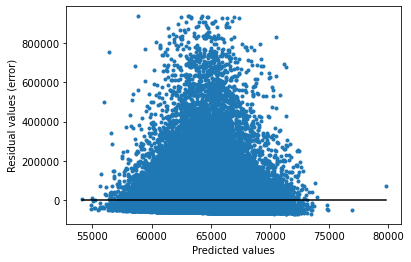

In [209]:
models_collector.add(name=name, description=description, model=model, cv_results=cv_results, \
                     y_true=y_train, y_pred=y_pred, x_shape=X_train.shape, size_reduction=REDUCTION)

No effect.

#### Neural Network 2, with regularization L2

In [221]:
# Define base model
def baseline_model():
    regularization = l2(0.001)
    
    # Create model
    model = Sequential()
    model.add(Dense(40, input_dim=X_train.shape[1], \
                    kernel_initializer='normal', kernel_regularizer=regularization, activation="relu"))
    model.add(Dense(10, input_dim=X_train.shape[1], \
                    kernel_initializer='normal', kernel_regularizer=regularization, activation="relu"))
    model.add(Dense(1, kernel_initializer="normal", kernel_regularizer=regularization, activation="linear"))    
    
    # Compile model
    model.compile(loss="mean_squared_error", optimizer="adam")
    return model


# Evaluate model
name, description, model = ("NN2 L2/TR2", "Transformer2, KerasRegressor layers: [40, 10, 1], with regularization L2", \
                            KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=32, verbose=2))
cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)

Epoch 1/100
4373/4373 - 2s - loss: 7555841024.0000
Epoch 2/100
4373/4373 - 2s - loss: 6639211008.0000
Epoch 3/100
4373/4373 - 2s - loss: 6622435328.0000
Epoch 4/100
4373/4373 - 2s - loss: 6615322624.0000
Epoch 5/100
4373/4373 - 2s - loss: 6611534848.0000
Epoch 6/100
4373/4373 - 2s - loss: 6610418176.0000
Epoch 7/100
4373/4373 - 2s - loss: 6609598976.0000
Epoch 8/100
4373/4373 - 2s - loss: 6609260544.0000
Epoch 9/100
4373/4373 - 2s - loss: 6609037824.0000
Epoch 10/100
4373/4373 - 2s - loss: 6608820736.0000
Epoch 11/100
4373/4373 - 2s - loss: 6608871936.0000
Epoch 12/100
4373/4373 - 2s - loss: 6608490496.0000
Epoch 13/100
4373/4373 - 2s - loss: 6608720896.0000
Epoch 14/100
4373/4373 - 2s - loss: 6608810496.0000
Epoch 15/100
4373/4373 - 2s - loss: 6608870912.0000
Epoch 16/100
4373/4373 - 2s - loss: 6608903680.0000
Epoch 17/100
4373/4373 - 2s - loss: 6608724480.0000
Epoch 18/100
4373/4373 - 2s - loss: 6608675840.0000
Epoch 19/100
4373/4373 - 2s - loss: 6608726528.0000
Epoch 20/100
4373/437

Epoch 59/100
4373/4373 - 2s - loss: 6606855680.0000
Epoch 60/100
4373/4373 - 2s - loss: 6606542848.0000
Epoch 61/100
4373/4373 - 2s - loss: 6606622720.0000
Epoch 62/100
4373/4373 - 2s - loss: 6606616576.0000
Epoch 63/100
4373/4373 - 2s - loss: 6606529024.0000
Epoch 64/100
4373/4373 - 2s - loss: 6606366208.0000
Epoch 65/100
4373/4373 - 2s - loss: 6606694912.0000
Epoch 66/100
4373/4373 - 2s - loss: 6606550016.0000
Epoch 67/100
4373/4373 - 2s - loss: 6606576128.0000
Epoch 68/100
4373/4373 - 2s - loss: 6606510080.0000
Epoch 69/100
4373/4373 - 2s - loss: 6606617088.0000
Epoch 70/100
4373/4373 - 2s - loss: 6606374912.0000
Epoch 71/100
4373/4373 - 2s - loss: 6606648832.0000
Epoch 72/100
4373/4373 - 2s - loss: 6606466048.0000
Epoch 73/100
4373/4373 - 2s - loss: 6605967360.0000
Epoch 74/100
4373/4373 - 2s - loss: 6606461440.0000
Epoch 75/100
4373/4373 - 2s - loss: 6606623744.0000
Epoch 76/100
4373/4373 - 2s - loss: 6606615552.0000
Epoch 77/100
4373/4373 - 2s - loss: 6606123008.0000
Epoch 78/100

Epoch 17/100
4373/4373 - 2s - loss: 6598631424.0000
Epoch 18/100
4373/4373 - 2s - loss: 6598395904.0000
Epoch 19/100
4373/4373 - 2s - loss: 6598453760.0000
Epoch 20/100
4373/4373 - 2s - loss: 6598141440.0000
Epoch 21/100
4373/4373 - 2s - loss: 6598504448.0000
Epoch 22/100
4373/4373 - 2s - loss: 6598259200.0000
Epoch 23/100
4373/4373 - 2s - loss: 6598475776.0000
Epoch 24/100
4373/4373 - 2s - loss: 6598448640.0000
Epoch 25/100
4373/4373 - 2s - loss: 6598294528.0000
Epoch 26/100
4373/4373 - 2s - loss: 6598544896.0000
Epoch 27/100
4373/4373 - 2s - loss: 6598417408.0000
Epoch 28/100
4373/4373 - 2s - loss: 6598532608.0000
Epoch 29/100
4373/4373 - 2s - loss: 6598165504.0000
Epoch 30/100
4373/4373 - 2s - loss: 6598289920.0000
Epoch 31/100
4373/4373 - 2s - loss: 6598600192.0000
Epoch 32/100
4373/4373 - 2s - loss: 6598361600.0000
Epoch 33/100
4373/4373 - 2s - loss: 6598191616.0000
Epoch 34/100
4373/4373 - 2s - loss: 6597940736.0000
Epoch 35/100
4373/4373 - 2s - loss: 6598139904.0000
Epoch 36/100

Epoch 75/100
4373/4373 - 2s - loss: 6641510912.0000
Epoch 76/100
4373/4373 - 2s - loss: 6641943552.0000
Epoch 77/100
4373/4373 - 2s - loss: 6641705472.0000
Epoch 78/100
4373/4373 - 2s - loss: 6641932288.0000
Epoch 79/100
4373/4373 - 2s - loss: 6641918464.0000
Epoch 80/100
4373/4373 - 2s - loss: 6641768960.0000
Epoch 81/100
4373/4373 - 2s - loss: 6641556992.0000
Epoch 82/100
4373/4373 - 2s - loss: 6641515008.0000
Epoch 83/100
4373/4373 - 2s - loss: 6641641472.0000
Epoch 84/100
4373/4373 - 2s - loss: 6641777152.0000
Epoch 85/100
4373/4373 - 2s - loss: 6641900544.0000
Epoch 86/100
4373/4373 - 2s - loss: 6641342976.0000
Epoch 87/100
4373/4373 - 2s - loss: 6641603584.0000
Epoch 88/100
4373/4373 - 2s - loss: 6641781248.0000
Epoch 89/100
4373/4373 - 2s - loss: 6641696256.0000
Epoch 90/100
4373/4373 - 2s - loss: 6641692672.0000
Epoch 91/100
4373/4373 - 2s - loss: 6641646592.0000
Epoch 92/100
4373/4373 - 2s - loss: 6641944576.0000
Epoch 93/100
4373/4373 - 2s - loss: 6641623552.0000
Epoch 94/100

No effects.

#### Linear Regression with Box-Cox's Transformation

In [212]:
# Box-Cox Transformation (normalizes decomposition)
y_boxcox, fitted_lambda = stats.boxcox(y_train)  

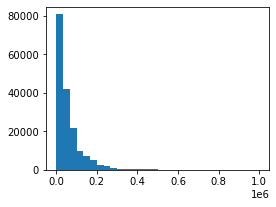

In [218]:
plt.figure(figsize=(4,3))
plt.hist(y_train, bins=30)
plt.show()

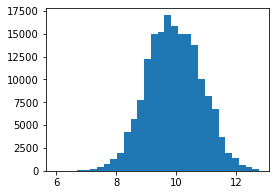

In [219]:
plt.figure(figsize=(4,3))
plt.hist(y_boxcox, bins=30)
plt.show()

Model: LR-BoxCox/TR2, description: Transformer2, Linear model without regularization, with Box-Cox transformation
Shape of data: (174915, 81), REDUCTION = 1
Results for K-Folds: 
 [-0.80949063 -0.81838448 -0.80716388 -0.82293824 -0.8177941 ]
Mean: -0.8151542659834794, Std: 0.0058977308302245405

Metrics for the entire dataset:
R^2 (coef. of determination):                        -0.1042
Explained variance score:                             0.0002
Mean squared error (MSE):                    7301166021.7880
Mean absolute errors (MAE):                       45019.3847
Median absolute error:                            23440.7379


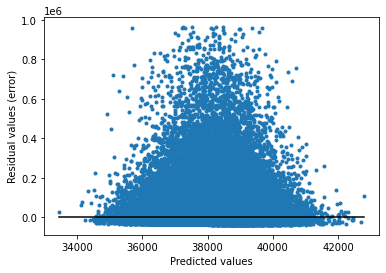

In [214]:
name, description, model = ("LR-BoxCox/TR2", "Transformer2, Linear model without regularization, with Box-Cox transformation", \
                            linear_model.LinearRegression())
cv_results = cross_val_score(model, X_train, y_boxcox, cv=kfold, scoring=scoring)

model.fit(X_train, y_boxcox)
y_pred_boxcox = model.predict(X_train)
y_pred = scipy.special.inv_boxcox(y_pred_boxcox, fitted_lambda)

models_collector.add(name=name, description=description, model=model, cv_results=cv_results, \
                     y_true=y_train, y_pred=y_pred, x_shape=X_train.shape, size_reduction=REDUCTION)

No effect.

#### Polynomial regression with regularization L2

In [ ]:
name, description, model = ('PR3/TR2', "Polynomial regression with regularization L2", \
                            make_pipeline(PolynomialFeatures(3), linear_model.Ridge(alpha=0.01)))
cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)

model.fit(X_train, y_train)
y_pred = model.predict(X_train)

models_collector.add(name=name, description=description, model=model, cv_results=cv_results, \
                     y_true=y_train, y_pred=y_pred, x_shape=X_train.shape, size_reduction=REDUCTION)

## Final tests for the best models
We are looking for a model with the highest possible R2 coefficient and low error values, for which the results on the test set do not differ significantly from the results on the training set.

In [ ]:
X_test, y_test = get_data(training_set=False)
X_test.shape, y_test.shape

In [ ]:
# Preprocessing for test data
X_test = otomoto_preprocessor.transform(X_test, y_test)

# Transformation for the test data
X_test = transformer.transform(X_test)
X_test.shape

In [ ]:
name = ...  # name of choosen model
model = models_collector.model_[name]
models_collector.info(name)

In [ ]:
# model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Method saves results but also prints metrics and shows prediction error plot
models_collector.add(name="/".join(["TEST",name]), description=models_collector.description_[name], \
                     model=model, cv_results=cv_results, y_true=y_test, y_pred=y_pred, x_shape=X_test.shape)

## Learned model, ready for prediction
The following code should be considered as an example (correct model not found above).

In [ ]:
# Add the transformer (estimators) to the best model pipeline

# Example
model = make_pipeline(estimators, PolynomialFeatures(3), linear_model.Ridge(alpha=0.01))
model.fit(X_train, y_train)

In [ ]:
with open("OtoMoto_model.pkl", "wb") as f:
    pickle.dump(model, f)

## Description of requirements for data

#### Data format

The data, which are forwarded to the transformer, should be structured as follows (additional fields are possible but will be ignored):

**Categorical data:**<br>

 'seller_type',
 'Marka pojazdu',
 'Model pojazdu', 
 'Generacja',
 'Wersja',
 'Napęd',
 'Typ',
 'Kolor',
 'Kraj pochodzenia',
 'Stan' (Używane/Nowe),
 'Skrzynia biegów' (Manualna/Automatyczna)


**Numerical data:** <br>

'Przebieg', 'Pojemność skokowa', 'Moc', 'Rok produkcji', "Liczba miejsc", "Liczba drzwi"


**Binary data:** <br>


'Faktura VAT',
 'Zarejestrowany w Polsce',
 'Pierwszy właściciel',
 'Bezwypadkowy',
 'Serwisowany w ASO',
 'Metalik',
 'ABS',
 'Bluetooth',
 'Czujnik zmierzchu',
 'Elektrycznie ustawiane lusterka',
 'Gniazdo USB',
 'Klimatyzacja automatyczna',
 'MP3',
 'Poduszka powietrzna chroniąca kolana',
 'Poduszki boczne przednie',
 'Radio niefabryczne',
 'Światła do jazdy dziennej',
 'Szyberdach',
 'Alufelgi',
 'Centralny zamek',
 'Czujniki parkowania tylne',
 'ESP (stabilizacja toru jazdy)',
 'Immobilizer',
 'Komputer pokładowy',
 'Ogranicznik prędkości',
 'Poduszka powietrzna kierowcy',
 'Poduszki boczne tylne',
 'Radio fabryczne',
 'Światła LED',
 'Wielofunkcyjna kierownica',
 'ASR (kontrola trakcji)',
 'Czujnik deszczu',
 'Elektryczne szyby przednie',
 'Gniazdo AUX',
 'Isofix',
 'Kurtyny powietrzne',
 'Podgrzewane lusterka boczne',
 'Poduszka powietrzna pasażera',
 'Przyciemniane szyby',
 'Światła Xenonowe',
 'Światła przeciwmgielne',
 'Wspomaganie kierownicy',
 'Perłowy',
 'Alarm',
 'CD',
 'Tapicerka welurowa',
 'Gniazdo SD',
 'Tempomat',
 'Dach panoramiczny',
 'Podgrzewana przednia szyba',
 'Klimatyzacja manualna',
 'System Start-Stop',
 'Akryl (niemetalizowany)',
 'VAT marża',
 'Asystent parkowania',
 'Klimatyzacja dwustrefowa',
 'Regulowane zawieszenie',
 'Nawigacja GPS',
 'Tapicerka skórzana',
 'Elektrochromatyczne lusterko wsteczne',
 'Czujniki parkowania przednie',
 'Kamera cofania',
 'Odtwarzacz DVD',
 'Podgrzewane przednie siedzenia',
 'Elektrochromatyczne lusterka boczne',
 'Tuner TV',
 'Łopatki zmiany biegów',
 'Elektryczne szyby tylne',
 'Elektrycznie ustawiane fotele',
 'Klimatyzacja czterostrefowa',
 'Asystent pasa ruchu',
 'Czujnik martwego pola',
 'Zmieniarka CD',
 'Relingi dachowe',
 'Hak',
 'Tempomat aktywny',
 'Podgrzewane tylne siedzenia',
 'Kierownica po prawej (Anglik)',
 'Ogrzewanie postojowe',
 'Filtr cząstek stałych',
 'HUD (wyświetlacz przezierny)',
 "price_details", 
 "Matowy", 
 "Rodzaj paliwa", 
 "Pierwsza rejestracja", 
 "Gwarancja dealerska (w cenie)", 
 "Okres gwarancji producenta", 
 "lub do (przebieg km)"
 

#### Additional remarks:
The model does not support:
- prices in currencies other than PLN,
- price predictions for damaged cars,
- price prediction for luxury cars.

The above mentioned data should be removed from the data set.


Numeric fields should be passed as float variables (after removing units). <br>
The remaining fields (including binary variables) should be passed to the transformer as text variables.



#### Description of selected columns:
- **href:** link to the offer on the website (auxiliary for data analysis),
- **price_evaluation:** indicates whether the car's price is in the mid-range, above or below; not used in price prediction (not used for price prediction, but can be the basis for offer classification)
- **currency:** only PLN supported (offers in other currencies should be removed from the data)
- **price_details:** additional information regarding the price, e.g. whether the price is negotiable,
- **seller_type:** offer from a private person or from a dealer,
- **seller_name:** field not used in price prediction,
- **Oferta od:** similar to "seller_type",
- **Marka pojazdu:** car brands,
- **Model pojazdu:** car models,
- **Generacja:** car generation, 
- **Wersja:** car version, 
- **Rok produkcji:** year of production,
- **Przebieg:** mileage,
- **Pojemność skokowa:** engine capacity,
- **Rodzaj paliwa:** type of fuel,
- **Moc:** engine power,	
- **Emisja CO2:** CO2 emission, 
- **Skrzynia biegów:** gearbox (automatic / manual),
- **Napęd:** drive (front wheel / rear wheel / 4x4),
- **Typ:** types of cars,
- **Liczba drzwi:** number of doors,
- **Liczba miejsc:** number of seats,
- **Kolor:** colours,
- **Faktura VAT:** the invoice includes VAT,
- **VAT marża:** the possibility of tax reduction by settling VAT on the margin, 
- **Kraj pochodzenia:** country of origin,
- **Pierwsza rejestracja:** date of the first registration,
- **Zarejestrowany w Polsce:** car registered in Poland,
- **Pierwszy właściciel:** purchase from the first owner,
- **Bezwypadkowy:** accident-free,
- **Serwisowany w ASO:** serviced at authorized service station,
- **Stan:** condition (new / used),
- **Uszkodzony:** damaged car, 
- **ADDITIONAL FEATURES** (yes/no): On board computer, ABS, ESP (stabilization program), ASR (traction control), Power steering, Multifunction steering wheel, Manual air conditioning, Automatic air conditioning, Four-zone air conditioning, Dual-zone air conditioning, Particulate filter, Driver airbag, Passenger airbag, Sidebags Rear, Knee protection airbag, Front side airbags, Curtains, Dusk sensor, Daytime running lights, Xenon lights, Fog lights, LED lights, Blind spot sensor, Rear parking sensors, Front parking sensors, Reversing camera, Central locking, Immobilizer , Alarm, Cruise control active, Speed limiter, Rain sensor, Heated windshield, Electric front windows, Electric mirrors, Heated door mirrors, Tinted windows, Metallic, Pearl, Matt, Acrylic (non-metallic), Tuning, Cruise control, Panoramic roof, System Start-Stop, Parking assistant, Adjustable hinge Sewing, Velor upholstery, Leather upholstery, Electrochromic rearview mirror, Electrochromic side mirrors, Electric rear windows, Electrically adjustable seats, Heated front seats, Heated rear seats, Auxiliary heating, Gear shift paddles, Lane assistant, Sunroof, Roof rails, Alloy rims, Hook, Right hand drive (English), Manufacturer's warranty period, or up to (mileage), Dealer warranty (included), Isofix, HUD (Head-up display), Truck approval, Registered historic, Code Engine, GPS Navigation, Aftermarket Radio, Factory Radio, SD Slot, TV Tuner, Bluetooth, USB Slot, MP3, CD, CD Changer, DVD Player, AUX Socket


Data set y_train/y_test should contain car prices in PLN.

